In [1]:
# Libraries for ML models:

import sklearn                                                    # version: 1.3.0
import eurostat                                                   # version: 1.0.4
import numpy as np                                                # version: 1.24.3
from sklearn.svm import SVC                                       # version: 1.3.0
from sklearn import metrics,tree                                  # version: 1.3.0
from sklearn.cluster import KMeans                                # version: 1.3.0
from matplotlib.lines import Line2D                               # version: 3.7.2
from sklearn.decomposition import PCA                             # version: 1.3.0
from sklearn.feature_selection import RFE                         # version: 1.3.0
from matplotlib.ticker import FuncFormatter                       # version: 3.7.2
from sklearn.metrics import silhouette_score                      # version: 1.3.0
from sklearn.tree import DecisionTreeClassifier                   # version: 1.3.0
from sklearn.linear_model import LinearRegression                 # version: 1.3.0
from sklearn.neighbors import KNeighborsClassifier                # version: 1.3.0
from sklearn.ensemble import RandomForestClassifier               # version: 1.3.0
from sklearn.preprocessing import StandardScaler, scale           # version: 1.3.0
from sklearn.metrics import classification_report, accuracy_score # version: 1.3.0
from sklearn.model_selection import KFold, GridSearchCV           # version: 1.3.0

# Libraries for Sentiment Analysis:

import nltk                                                       # version: 3.8.1
from sklearn.metrics import roc_curve, auc                        # version: 1.3.0
from sklearn.naive_bayes import MultinomialNB                     # version: 1.3.0
from sklearn.feature_extraction.text import CountVectorizer       # version: 1.3.0

# Libraries used for ML models and Sentiment Analysis:

import pandas as pd                                               # version: 2.0.3
import seaborn as sns                                             # version: 0.12.2
import matplotlib.pyplot as plt                                   # version: 3.7.2
from sklearn.metrics import confusion_matrix                      # version: 1.3.0
from sklearn.preprocessing import LabelEncoder                    # version: 1.3.0
from sklearn.model_selection import train_test_split              # version: 1.3.0

In [2]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

# 4.1. Supervised learning, GridSearchCV hyperparameter tunning.

In [3]:
# Modal split of inland passenger transport
# Unit of measure (% based on passenger-kilometres) : one passenger-km is one passenger transported over one kilometre
# https://ec.europa.eu/eurostat/databrowser/view/TRAN_HV_PSMOD__custom_2638259/bookmark/table?lang=en&bookmarkId=2d735f97-a7d6-4b24-bc27-a6c8e21db6a7
# Legal notice: https://commission.europa.eu/legal-notice_en
# Licence: Creative Commons Attribution 4.0 International (CC BY 4.0) licence

mldf = eurostat.get_data_df('TRAN_HV_PSMOD',True)                                                                 
mldf.head()
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

mldf.head()

freq unit  vehicle geo\TIME_PERIOD  1990_value 1990_flag  1991_value  \
0    A   PC  BUS_TOT              AT       11.00                 10.60   
1    A   PC  BUS_TOT              BE       10.60         e       10.70   
2    A   PC  BUS_TOT              BG         NaN         :         NaN   
3    A   PC  BUS_TOT              CH        3.70                  3.90   
4    A   PC  BUS_TOT              CY         NaN         :         NaN   

  1991_flag  1992_value 1992_flag  ...  2017_value 2017_flag  2018_value  \
0                 10.50            ...       10.00                  9.50   
1         e       10.70         e  ...       10.20         e       10.30   
2         :         NaN         :  ...       13.10         e       12.00   
3                  4.00            ...        5.90         e        5.90   
4         :         NaN         :  ...       19.00         e       18.90   

  2018_flag  2019_value 2019_flag  2020_value 2020_flag  2021_value 2021_flag  
0        be        9.70         e        9.30         e        9.00         e  
1         e       10.40         e        8.20         e        8.20         e  
2         e       13.00         e        8.60         e        8.00         e  
3         e        6.10         e        5.80         e        5.90         e  
4         e       18.50         e       12.60         e       12.70         e  

[5 rows x 68 columns]

In [4]:
# Tyding up mldf

# Filter columns that do not contain '_flag'
mldf = mldf.filter(regex='^(?!.*_flag)')

# Renaming columns
mldf = mldf.rename(columns={'geo\\TIME_PERIOD': 'Country_code','vehicle':'Vehicle_type'})

# Dropping not needed rows:
# From column 'Vehicle_type' we don't need 'TRN_BUS_TOT_AVD'
# From column 'Country_code' we don't need 'EU27_2020' and 'EU28'
mldf = mldf[(mldf['Vehicle_type'] != 'TRN_BUS_TOT_AVD') & ~mldf['Country_code'].isin(['EU27_2020', 'EU28'])]

# Drop rows with null values
mldf = mldf.dropna()

# Dropping columns 'freq' and 'unit' we don't need them. Unit of measurement for this dataset is percentage
mldf = mldf.drop(['freq', 'unit'], axis=1).reset_index(drop=True)

# Trimming 'BUS_TOT' to have just 'BUS'
mldf['Vehicle_type'] = mldf['Vehicle_type'].str.replace('_TOT', '')

# Concatenate 'Country_code' and 'Vehicle_type'
mldf['Country_Vehicle'] = mldf['Country_code'] + '_' + mldf['Vehicle_type']

# Drop the original columns
mldf = mldf.drop(['Vehicle_type', 'Country_code'], axis=1)

mldf.head()

1990_value  1991_value  1992_value  1993_value  1994_value  1995_value  \
0       11.00       10.60       10.50       10.70       10.60       10.90   
1       10.60       10.70       10.70       10.90       11.80       11.30   
2        3.70        3.90        4.00        3.90        4.00        3.80   
3        9.10        8.50        8.30        8.10        7.30        7.20   
4       11.30       11.10       15.20       15.30       15.50       16.60   

   1996_value  1997_value  1998_value  1999_value  ...  2013_value  \
0       10.70       10.90       10.90       10.70  ...        9.90   
1       11.30       11.10       11.00       10.90  ...       15.20   
2        3.60        3.60        5.30        5.20  ...        5.70   
3        7.10        7.10        7.00        6.90  ...        7.20   
4       17.40       16.90       14.10       13.90  ...        9.80   

   2014_value  2015_value  2016_value  2017_value  2018_value  2019_value  \
0        9.90        9.90        9.90       10.00        9.50        9.70   
1       11.50       11.00       10.50       10.20       10.30       10.40   
2        5.80        5.90        5.90        5.90        5.90        6.10   
3        7.20        7.40        7.30        7.30        7.20        7.40   
4        9.80        9.80        9.80       10.00        9.60        9.20   

   2020_value  2021_value  Country_Vehicle  
0        9.30        9.00           AT_BUS  
1        8.20        8.20           BE_BUS  
2        5.80        5.90           CH_BUS  
3        4.80        4.80           DE_BUS  
4        6.80        7.10           DK_BUS  

[5 rows x 33 columns]

In [5]:
# We need to organise mldf, basically I want to have 'Year', 'Country_Vehicle' and 'value'
    
# Empty list to store results, initialising it
final_list = []

# Iterating over columns to extract the year from columns
for col in mldf.columns:
    if col.endswith('_value'):
        # Extracting each year from the columns
        year = col.split('_')[0]

        # Getting 'Vehicle_Country' for each row to get its corresponding values
        for index, row in mldf.iterrows():
            value = row[col]
            country_vehicle = row['Country_Vehicle']
            category = col.split('_')[1]  # Extract the category from the column name

            # Appending the final list as a dictionary
            final_list.append({
                'Year': year,
                'Country_Vehicle': country_vehicle,
                'Category': category,
                'Value': value
            })
            
# Converting 'final_list' to a DataFrame
Y_CV_V_df = pd.DataFrame(final_list)

# Pivot the DataFrame
Y_CV_V_df = Y_CV_V_df.pivot_table(index=['Year', 'Country_Vehicle'], columns='Category', values='Value').reset_index()
Y_CV_V_df = Y_CV_V_df.rename_axis(None, axis=1) # Index with no name as it should be
   
mldf = Y_CV_V_df.copy() #Reusing variable mldf

mldf.head()

Year Country_Vehicle  value
0  1990          AT_BUS  11.00
1  1990          AT_CAR  77.10
2  1990          AT_TRN  11.90
3  1990          BE_BUS  10.60
4  1990          BE_CAR  83.30

In [6]:
mldf.shape

(1728, 3)

In [7]:
# Dataset will be used in the second part of this section
mldf1a = mldf.copy() 

In [8]:
# Creating mdf1 for stats

mldf1 = mldf.copy()

In [9]:
# Pivot the DataFrame
mldf1 = mldf1.pivot(index='Year', columns='Country_Vehicle', values='value').reset_index()
mldf1 = mldf1.rename_axis(None, axis=1)
mldf1.head()

Year  AT_BUS  AT_CAR  AT_TRN  BE_BUS  BE_CAR  BE_TRN  CH_BUS  CH_CAR  \
0  1990   11.00   77.10   11.90   10.60   83.30    6.10    3.70   82.10   
1  1991   10.60   77.00   12.40   10.70   83.30    6.10    3.90   81.10   
2  1992   10.50   77.00   12.50   10.70   83.30    6.00    4.00   81.40   
3  1993   10.70   77.20   12.10   10.90   83.30    5.90    3.90   80.90   
4  1994   10.60   77.80   11.60   11.80   82.60    5.60    4.00   79.80   

   CH_TRN  ...  PL_TRN  PT_BUS  PT_CAR  PT_TRN  SE_BUS  SE_CAR  SE_TRN  \
0   14.20  ...   30.50   18.40   71.50   10.10    9.50   84.10    6.50   
1   15.00  ...   24.60   18.60   71.40    9.90    9.50   84.70    5.90   
2   14.60  ...   20.30   22.70   68.20    9.00    9.40   84.80    5.80   
3   15.20  ...   17.70   19.30   72.20    8.50    9.30   84.40    6.30   
4   16.20  ...   15.60   17.90   74.30    7.80    9.30   84.40    6.30   

   SI_BUS  SI_CAR  SI_TRN  
0   30.60   62.70    6.70  
1   29.30   66.40    4.30  
2   23.00   73.90    3.00  
3   21.10   75.80    3.10  
4   20.40   76.60    3.00  

[5 rows x 55 columns]

In [10]:
# Dataset for Unsupervised ML models
mldf2 = mldf1.copy()

In [11]:
# sdf1.describe(include='all').T # Transposing columns to see each Country_Vehicle
# passing the stats into 'mldf1' dataframe
mldf1 = (mldf1.describe(include='all').T).reset_index().rename_axis(None, axis=1).copy()

# Dropping first row we don't need Years we already now that year range goes from 1990 to 2021
mldf1 = mldf1.drop(0)

# Renaming columns
mldf1 = mldf1.rename(columns={'index': 'Country_Vehicle'}).drop(['unique', 'top','freq','count','std','25%','50%','75%','max','min'], axis=1).sort_values(by='mean', ascending=False).reset_index(drop=True)

mldf1

Country_Vehicle  mean
0           NL_CAR 86.12
1           FR_CAR 85.38
2           DE_CAR 85.35
3           LU_CAR 84.58
4           PT_CAR 84.52
5           FI_CAR 83.88
6           SE_CAR 83.50
7           IE_CAR 82.85
8           SI_CAR 82.72
9           IT_CAR 82.16
10          BE_CAR 81.70
11          ES_CAR 81.39
12          DK_CAR 79.91
13          AT_CAR 78.61
14          CH_CAR 78.53
15          EL_CAR 76.23
16          PL_CAR 72.92
17          HU_CAR 66.61
18          HU_BUS 22.21
19          EL_BUS 22.08
20          PL_BUS 16.63
21          CH_TRN 16.38
22          SI_BUS 14.62
23          IE_BUS 14.03
24          ES_BUS 12.76
25          IT_BUS 12.00
26          DK_BUS 11.74
27          BE_BUS 11.60
28          HU_TRN 11.17
29          AT_TRN 11.12
30          FI_BUS 11.03
31          LU_BUS 10.92
32          PL_TRN 10.43
33          AT_BUS 10.27
34          PT_BUS 10.27
35          NL_TRN  9.39
36          FR_TRN  9.03
37          DK_TRN  8.37
38          SE_BUS  8.29
39          SE_TRN  8.20
40          DE_TRN  7.66
41          DE_BUS  7.00
42          BE_TRN  6.71
43          IT_TRN  5.85
44          ES_TRN  5.84
45          FR_BUS  5.61
46          PT_TRN  5.21
47          CH_BUS  5.09
48          FI_TRN  5.08
49          LU_TRN  4.51
50          NL_BUS  4.49
51          IE_TRN  3.12
52          SI_TRN  2.67
53          EL_TRN  1.70

In [12]:
def highlight_countries(row):
    styles = [''] * len(row)
    
    # Highlight 'IE' in yellow
    if row['Country_Vehicle'].startswith('IE'):
        styles = ['background-color: yellow'] * len(row)
    
    # Highlight 'HU' in lightgreen
    elif row['Country_Vehicle'].startswith('HU'):
        styles = ['background-color: lightgreen'] * len(row)
    
    return styles

# Apply the highlighting function to the DataFrame
mldf1 = mldf1.style.apply(highlight_countries, axis=1)

mldf1

In [13]:
# Modify the code to filter based on substrings
mldf = mldf[mldf['Country_Vehicle'].str.contains('IE|HU', case=False, na=False)]
mldf.reset_index(drop=True, inplace=True)

# Outlier Analysis:

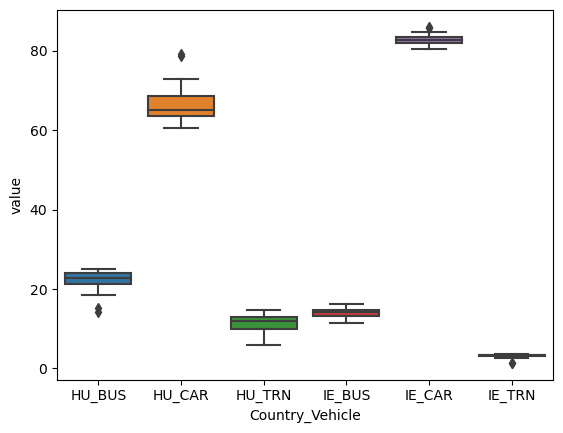

In [14]:
# Box plot to identify outliers
sns.boxplot(x='Country_Vehicle', y='value', data=mldf)

plt.show()

No need to remove outliers

In [15]:
mldf

Year Country_Vehicle  value
0    1990          HU_BUS  24.80
1    1990          HU_CAR  60.50
2    1990          HU_TRN  14.70
3    1990          IE_BUS  11.50
4    1990          IE_CAR  84.90
..    ...             ...    ...
187  2021          HU_CAR  79.30
188  2021          HU_TRN   6.40
189  2021          IE_BUS  13.00
190  2021          IE_CAR  85.70
191  2021          IE_TRN   1.40

[192 rows x 3 columns]

In [16]:
# Move the 'Year' column to the second position
mldf.insert(1, 'Year', mldf.pop('Year'))

In [17]:
# Counting the values that each year has:
year_counts = mldf['Year'].value_counts().sort_index()
year_counts

Year
1990    6
1991    6
1992    6
1993    6
1994    6
1995    6
1996    6
1997    6
1998    6
1999    6
2000    6
2001    6
2002    6
2003    6
2004    6
2005    6
2006    6
2007    6
2008    6
2009    6
2010    6
2011    6
2012    6
2013    6
2014    6
2015    6
2016    6
2017    6
2018    6
2019    6
2020    6
2021    6
Name: count, dtype: int64

In [18]:
mldf

Country_Vehicle  Year  value
0            HU_BUS  1990  24.80
1            HU_CAR  1990  60.50
2            HU_TRN  1990  14.70
3            IE_BUS  1990  11.50
4            IE_CAR  1990  84.90
..              ...   ...    ...
187          HU_CAR  2021  79.30
188          HU_TRN  2021   6.40
189          IE_BUS  2021  13.00
190          IE_CAR  2021  85.70
191          IE_TRN  2021   1.40

[192 rows x 3 columns]

I need to see Country_Vehicle classes

In [19]:
mldf_1990 = mldf[(mldf['Year'] == '1990')].copy()
mldf_1990.reset_index(drop=True, inplace=True)
mldf_1990

Country_Vehicle  Year  value
0          HU_BUS  1990  24.80
1          HU_CAR  1990  60.50
2          HU_TRN  1990  14.70
3          IE_BUS  1990  11.50
4          IE_CAR  1990  84.90
5          IE_TRN  1990   3.60

In [20]:
mldf_1991 = mldf_1990.copy()

In [21]:
# Creating figure X for report
# Dropping columns 'freq' and 'unit' we don't need them. Unit of measurement for this dataset is percentage
mldf_1991 = mldf_1991.drop(['Year', 'value'], axis=1).reset_index(drop=True)
mldf_1991

Country_Vehicle
0          HU_BUS
1          HU_CAR
2          HU_TRN
3          IE_BUS
4          IE_CAR
5          IE_TRN

In [22]:
# Creating a LabelEncoder instance
le = LabelEncoder()

# Encoding the 'Country_Vehicle' column
mldf['Country_Vehicle'] = le.fit_transform(mldf['Country_Vehicle'])
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
mldf

Country_Vehicle  Year  value
0                  0  1990  24.80
1                  1  1990  60.50
2                  2  1990  14.70
3                  3  1990  11.50
4                  4  1990  84.90
..               ...   ...    ...
187                1  2021  79.30
188                2  2021   6.40
189                3  2021  13.00
190                4  2021  85.70
191                5  2021   1.40

[192 rows x 3 columns]

In [23]:
mldfa = mldf.copy()

We can clearly see encoding equivalence

In [24]:
mldf_1990

Country_Vehicle  Year  value
0          HU_BUS  1990  24.80
1          HU_CAR  1990  60.50
2          HU_TRN  1990  14.70
3          IE_BUS  1990  11.50
4          IE_CAR  1990  84.90
5          IE_TRN  1990   3.60

In [25]:
X = mldf.iloc[:, [1,2]].values # Dependent variables
y = mldf.iloc[:, 0].values # Target variable

In [26]:
X

array([['1990', 24.8],
       ['1990', 60.5],
       ['1990', 14.7],
       ['1990', 11.5],
       ['1990', 84.9],
       ['1990', 3.6],
       ['1991', 23.4],
       ['1991', 63.2],
       ['1991', 13.3],
       ['1991', 11.9],
       ['1991', 84.3],
       ['1991', 3.7],
       ['1992', 22.9],
       ['1992', 63.9],
       ['1992', 13.2],
       ['1992', 12.3],
       ['1992', 84.2],
       ['1992', 3.5],
       ['1993', 23.2],
       ['1993', 64.5],
       ['1993', 12.4],
       ['1993', 12.6],
       ['1993', 83.8],
       ['1993', 3.6],
       ['1994', 23.5],
       ['1994', 64.3],
       ['1994', 12.2],
       ['1994', 13.6],
       ['1994', 83.0],
       ['1994', 3.4],
       ['1995', 23.6],
       ['1995', 64.4],
       ['1995', 12.0],
       ['1995', 13.6],
       ['1995', 83.0],
       ['1995', 3.4],
       ['1996', 25.0],
       ['1996', 63.2],
       ['1996', 11.8],
       ['1996', 13.5],
       ['1996', 83.3],
       ['1996', 3.3],
       ['1997', 24.0],
       ['1997', 64

In [27]:
y

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5])

## Splitting the dataset into the Training set and Test set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Feature Scaling

In [29]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DecisionTreeClassifier
## Training the Decision Tree Classification model on the Training set

In [30]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

## Predicting the Test and set results

In [31]:
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix

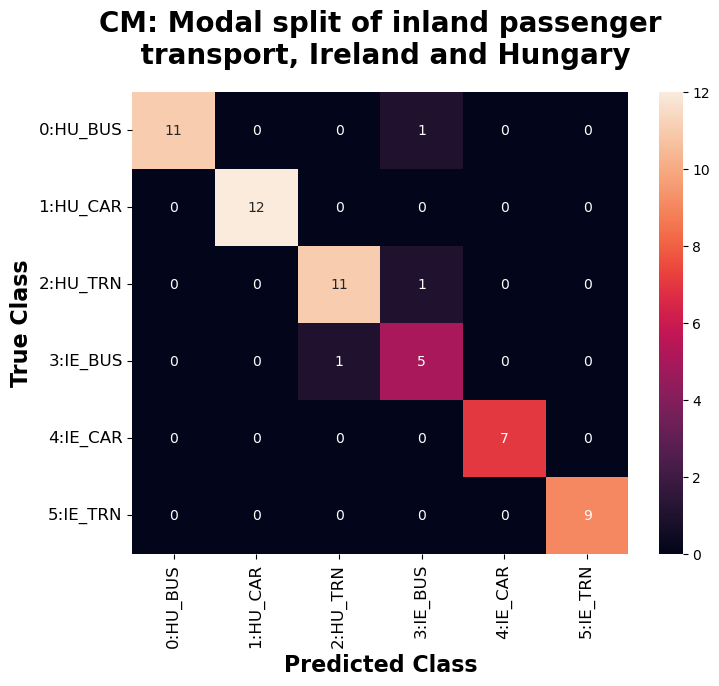

In [32]:
# Calculating confusion matrix
confMtrx = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['0:HU_BUS', '1:HU_CAR', '2:HU_TRN', '3:IE_BUS', '4:IE_CAR', '5:IE_TRN']

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confMtrx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('CM: Modal split of inland passenger\n transport, Ireland and Hungary', loc="center", pad=20, fontsize=20, fontweight="bold")
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
plt.ylabel('True Class', fontsize=16, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12)
plt.show()

Model is correctly classifiying:<br>
0:HU_BUS = 11<br>
1:HU_CAR = 12<br>
2:HU_TRN = 11<br>
3:IE_BUS = 5 <br>
4:IE_CAR = 7 <br>
5:IE_TRN = 9 <br>

In [33]:
# We don't want scientific notation
np.set_printoptions(suppress=True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))
# Which is the accuracy for the classifier???
print("Classifier Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4)*100)

tree_metr = metrics.accuracy_score(y_test, y_pred)*100

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       1.00      1.00      1.00        12
           2       0.92      0.92      0.92        12
           3       0.71      0.83      0.77         6
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         9

    accuracy                           0.95        58
   macro avg       0.94      0.94      0.94        58
weighted avg       0.95      0.95      0.95        58

Classifier Accuracy: 94.83


### Interpretation of the Classification Report:

#### Class 0:

- **Precision:** 1.00 - Of the instances predicted as class 0, all were actually class 0.
- **Recall:** 0.92 - Of all the instances that are actually class 0, 92% were correctly predicted.
- **F1-score:** 0.96 - A high F1-score indicating excellent precision and recall.

#### Class 1:

- **Precision:** 1.00 - Of the instances predicted as class 1, all were actually class 1.
- **Recall:** 1.00 - Of all the instances that are actually class 1, 100% were correctly predicted.
- **F1-score:** 1.00 - Perfect precision and recall.

#### Class 2:

- **Precision:** 0.92 - Of the instances predicted as class 2, 92% were actually class 2.
- **Recall:** 0.92 - Of all the instances that are actually class 2, 92% were correctly predicted.
- **F1-score:** 0.92 - A balanced metric indicating good precision and recall.

#### Class 3:

- **Precision:** 0.71 - Of the instances predicted as class 3, 71% were actually class 3.
- **Recall:** 0.83 - Of all the instances that are actually class 3, 83% were correctly predicted.
- **F1-score:** 0.77 - A balanced metric with a moderate F1-score.

#### Class 4:

- **Precision:** 1.00 - Of the instances predicted as class 4, all were actually class 4.
- **Recall:** 1.00 - Of all the instances that are actually class 4, 100% were correctly predicted.
- **F1-score:** 1.00 - Perfect precision and recall.

#### Class 5:

- **Precision:** 1.00 - Of the instances predicted as class 5, all were actually class 5.
- **Recall:** 1.00 - Of all the instances that are actually class 5, 100% were correctly predicted.
- **F1-score:** 1.00 - Perfect precision and recall.

### Overall Metrics:

- **Accuracy:** 94.83% - The overall accuracy of the model on all classes.
- **Precision (Macro Avg):** 94% - The unweighted average precision across all classes.
- **Recall (Macro Avg):** 94% - The unweighted average recall across all classes.
- **F1-score (Macro Avg):** 94% - The unweighted average F1-score across all classes.

### Weighted Averages:

- **Precision (Weighted Avg):** 95% - The weighted average precision, considering the number of instances in each class.
- **Recall (Weighted Avg):** 95% - The weighted average recall, considering the number of instances in each class.
- **F1-score (Weighted Avg):** 95% - The weighted average F1-score, considering the number of instances in each class.

### Additional Metrics:

- **Classifier Accuracy:** 94.83% - The overall accuracy of the classifier on the entire dataset.


In [34]:
# instantiate the classifier 
rfc = RandomForestClassifier(n_estimators=10,random_state=0) # Setting 10 trees

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.2f}'. format(accuracy_score(y_test, y_pred)*100))
randomforest = accuracy_score(y_test, y_pred)*100

Model accuracy score with 10 decision-trees : 93.10


[Text(0.5, 0.9, 'x[1] <= 1.503\ngini = 0.831\nsamples = 134\nvalue = [20, 20, 20, 26, 25, 23]'),
 Text(0.375, 0.7, 'x[1] <= -0.929\ngini = 0.798\nsamples = 109\nvalue = [20, 20, 20, 26, 0, 23]'),
 Text(0.25, 0.5, 'gini = 0.0\nsamples = 23\nvalue = [0, 0, 0, 0, 0, 23]'),
 Text(0.5, 0.5, 'x[1] <= -0.528\ngini = 0.746\nsamples = 86\nvalue = [20, 20, 20, 26, 0, 0]'),
 Text(0.25, 0.3, 'x[1] <= -0.652\ngini = 0.512\nsamples = 47\nvalue = [1, 0, 20, 26, 0, 0]'),
 Text(0.125, 0.1, 'gini = 0.436\nsamples = 28\nvalue = [0, 0, 19, 9, 0, 0]'),
 Text(0.375, 0.1, 'gini = 0.194\nsamples = 19\nvalue = [1, 0, 1, 17, 0, 0]'),
 Text(0.75, 0.3, 'x[1] <= 0.3\ngini = 0.5\nsamples = 39\nvalue = [19, 20, 0, 0, 0, 0]'),
 Text(0.625, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [19, 0, 0, 0, 0, 0]'),
 Text(0.875, 0.1, 'gini = 0.0\nsamples = 20\nvalue = [0, 20, 0, 0, 0, 0]'),
 Text(0.625, 0.7, 'gini = 0.0\nsamples = 25\nvalue = [0, 0, 0, 0, 25, 0]')]

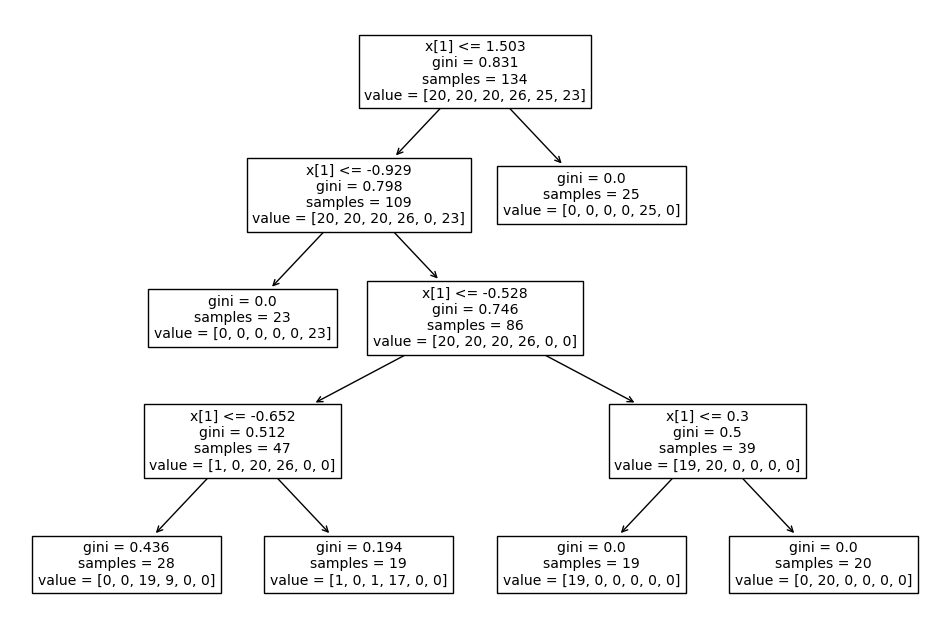

In [35]:
plt.figure(figsize=(12,8))
tree.plot_tree(classifier.fit(X_train, y_train)) 

## Interpretation:
The first line represents the root node of the decision tree. It checks if the value of feature `x[1]` is less than or equal to 1.503. If true, it proceeds to the left child node; otherwise, it goes to the right child node.

The second line represents a child node. It checks if the value of `x[1]` is less than or equal to -0.929. If true, it goes to the left child node, and if false, it goes to the right child node.

The third line represents a leaf node. It has a Gini index of 0.0, meaning it is a pure node with all samples belonging to the same class. The samples indicate that there are 23 instances in this node, and they all belong to the fifth class (indicated by the `value` array).

The rest of the lines follow the same logic.

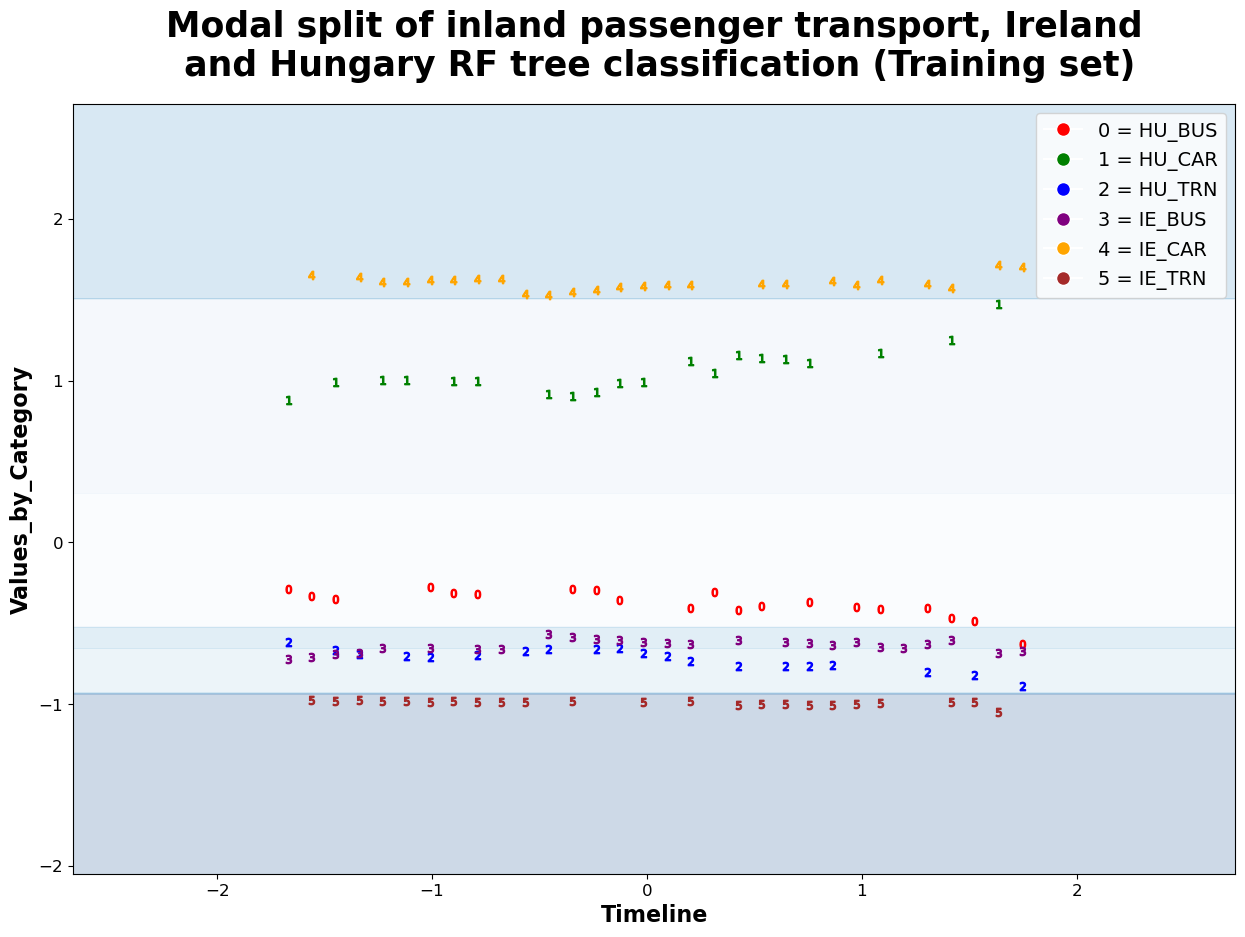

In [36]:
# Plotting the dataset
plt.figure(figsize=(15, 10))
X_set, y_set = X_train, y_train
X11, X22 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01))

# Contour plot
contour = plt.contourf(X11, X22, classifier.predict(np.array([X11.ravel(), X22.ravel()]).T).reshape(X11.shape),
                       alpha=0.2, cmap='Blues')



# Scatter plot for data points
for i, j in enumerate(np.unique(y_set)):
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c=colors[j], marker=f"${j}$",
                label=f'{j} = {"" if j == 1 else ""}')

# Legend for scatter plot
legend_labels = {
    0: 'HU_BUS',
    1: 'HU_CAR',
    2: 'HU_TRN',
    3: 'IE_BUS',
    4: 'IE_CAR',
    5: 'IE_TRN'
}
plt.legend(handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                           markersize=10, label=f'{i} = {legend_labels[i]}') for i in np.unique(y_set)],
           loc='best', fontsize=14)

plt.title('Modal split of inland passenger transport, Ireland\n and Hungary RF tree classification (Training set)', loc="center", pad=20, fontsize=25, fontweight="bold")
plt.xlabel('Timeline', fontsize=16, fontweight='bold')
plt.ylabel('Values_by_Category', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Creating a K-Nearest Neighbor Classifier

In [37]:
neighbors = np.arange(1, 20)                  # number of neighbors
train_accuracy = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix

In [38]:
# Saving values into new variables to reproduce results in 4.5.Table and Conclusions

X_traina = X_train
y_traina = y_train
X_testa = X_test
y_testa = y_test

In [39]:
for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_traina, y_traina)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_traina, y_traina)      # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_testa, y_testa)      # Save the score value in the train_accuracy array

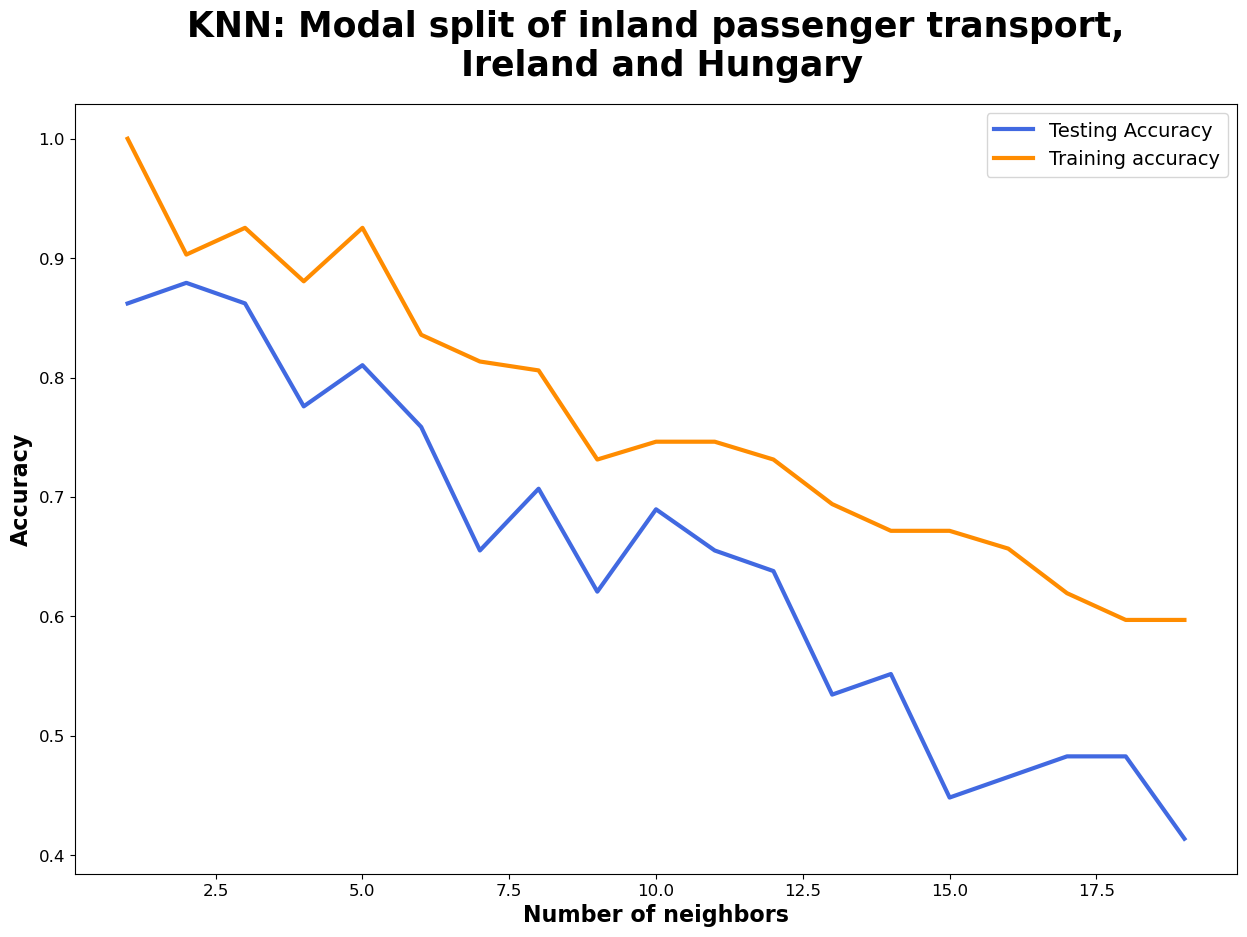

In [40]:
plt.figure(figsize=(15, 10))
plt.title('KNN: Modal split of inland passenger transport,\n Ireland and Hungary',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.plot(neighbors, test_accuracy, label='Testing Accuracy', linewidth=3, color='royalblue')
plt.plot(neighbors, train_accuracy, label='Training accuracy', linewidth=3, color='darkorange')

plt.xlabel('Number of neighbors',fontsize=16, fontweight='bold')
plt.ylabel('Accuracy',fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend( loc='best', fontsize=14)
plt.show()

In [41]:
# Declare and initialise an object 'KNeighborsClassifier' with 3 neighbors
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the model
knn.fit(X_train, y_train)   

# Compute accuracy on the training set
train_accuracy = knn.score(X_traina, y_traina)   

# Compute accuracy on the test set
test_accuracy = knn.score(X_testa, y_testa)  

In [42]:
# Display the test accuracy

print('Test accuracy = ', round(test_accuracy*100,2))
KNN=test_accuracy*100

Test accuracy =  86.21


# Parameter tunning GridSearch

In [43]:
# scaling the features

X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

## Model Building

In [44]:
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [45]:
# Saving values into new variables to reproduce results in 4.5.Table and Conclusions

y_test1 = y_test
y_pred1 = y_pred

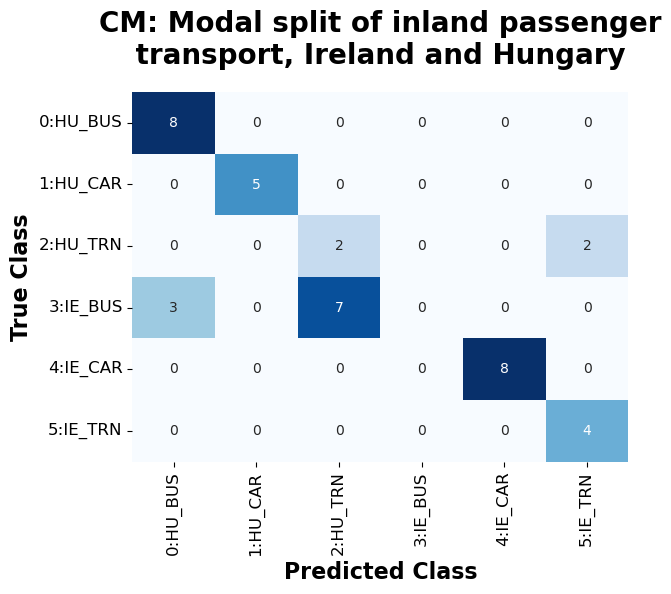

In [46]:
# Generate the confusion matrix
confMtrx1 = metrics.confusion_matrix(y_true=y_test1, y_pred=y_pred1)

# Define class labels
class_labels = ['0:HU_BUS', '1:HU_CAR', '2:HU_TRN', '3:IE_BUS', '4:IE_CAR', '5:IE_TRN']

# Create a heatmap of the confusion matrix

sns.heatmap(confMtrx1, annot = True, fmt = "d", cmap = "Blues", cbar = False, xticklabels=class_labels, yticklabels=class_labels) 
plt.title('CM: Modal split of inland passenger\n transport, Ireland and Hungary ', loc="center", pad=20, fontsize=20, fontweight="bold")
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
plt.ylabel('True Class', fontsize=16, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12)
plt.show()

Model is correctly classifiying:<br>
0:HU_BUS = 8<br>
1:HU_CAR = 5<br>
2:HU_TRN = 2<br>
3:IE_BUS = 0<br>
4:IE_CAR = 8<br>
5:IE_TRN = 4<br>

In [47]:
# Printing classification report
print(classification_report(y_test, y_pred))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

svc = metrics.accuracy_score(y_test, y_pred)*100

# precision
print("precision", metrics.precision_score(y_test, y_pred, average='weighted'))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      1.00      1.00         5
           2       0.22      0.50      0.31         4
           3       0.00      0.00      0.00        10
           4       1.00      1.00      1.00         8
           5       0.67      1.00      0.80         4

    accuracy                           0.69        39
   macro avg       0.60      0.75      0.66        39
weighted avg       0.57      0.69      0.62        39

accuracy 0.6923076923076923
precision 0.5736855736855737
recall 0.6923076923076923


### Class 0:
- **Precision:** 73% - Out of the instances predicted as class 0, 73% were actually class 0.
- **Recall:** 100% - Of all the instances that are actually class 0, 100% were correctly predicted.
- **F1-score:** 84% - A balanced metric considering both precision and recall.

### Class 1:
- **Precision:** 100% - All instances predicted as class 1 were actually class 1.
- **Recall:** 100% - All actual class 1 instances were correctly predicted.
- **F1-score:** 100% - Perfect precision and recall.

### Class 2:
- **Precision:** 22% - Only 22% of the instances predicted as class 2 were actually class 2.
- **Recall:** 50% - Half of the actual class 2 instances were correctly predicted.
- **F1-score:** 31% - A lower F1-score, indicating a trade-off between precision and recall.

### Class 3:
- **Precision:** 0% - None of the instances predicted as class 3 were actually class 3.
- **Recall:** 0% - No actual instances of class 3 were correctly predicted.
- **F1-score:** 0% - A very low F1-score.

### Class 4:
- **Precision:** 100% - All instances predicted as class 4 were actually class 4.
- **Recall:** 100% - All actual class 4 instances were correctly predicted.
- **F1-score:** 100% - Perfect precision and recall.

### Class 5:
- **Precision:** 67% - Two-thirds of the instances predicted as class 5 were actually class 5.
- **Recall:** 100% - All actual class 5 instances were correctly predicted.
- **F1-score:** 80% - A good balance between precision and recall.

### Overall Metrics:
- **Accuracy:** 69.23% - The overall accuracy of the model on all classes.
- **Precision (weighted avg):** 57.37% - The weighted average precision, considering the number of instances in each class.
- **Recall (weighted avg):** 69.23% - The weighted average recall, considering the number of instances in each class.
- **F1-score (weighted avg):** 62% - The weighted average F1-score, considering the number of instances in each class.

### Summary:
- The model performs well in classes 1 and 4, achieving perfect precision and recall.
- For classes 0 and 5, precision is relatively high, but recall is not perfect.
- Class 2 has a low precision and recall, leading to a lower F1-score.
- Class 3 has no correct predictions, resulting in the lowest precision, recall, and F1-score.
- The overall accuracy is 69.23%, and the weighted average F1-score is 62%.


## Grid Search to Find Optimal Hyperparameters

In [48]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001, 0.0001],
                     'C': [1, 10, 100, 1000]}]#,
                


# specify model
model = SVC(kernel = "rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring = 'accuracy', 
                        cv = folds, 
                        verbose = 4, # Changing verbose from 1 to 4, to display records :)
                        return_train_score = True)      

# fit the model
model_cv.fit(X_train, y_train)     

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1, gamma=0.01;, score=(train=0.533, test=0.387) total time=   0.0s
[CV 2/5] END C=1, gamma=0.01;, score=(train=0.377, test=0.290) total time=   0.0s
[CV 3/5] END C=1, gamma=0.01;, score=(train=0.361, test=0.355) total time=   0.0s
[CV 4/5] END C=1, gamma=0.01;, score=(train=0.382, test=0.400) total time=   0.0s
[CV 5/5] END C=1, gamma=0.01;, score=(train=0.472, test=0.267) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001;, score=(train=0.197, test=0.129) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001;, score=(train=0.205, test=0.097) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001;, score=(train=0.189, test=0.161) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001;, score=(train=0.220, test=0.200) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001;, score=(train=0.195, test=0.100) total time=   0.0s
[CV 1/5] END C=1, gamma=0.0001;, score=(train=0.197, test=0.129) total time=   0.0s
[CV 2/5] END C=1, gamma=0.0001

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [49]:
## cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

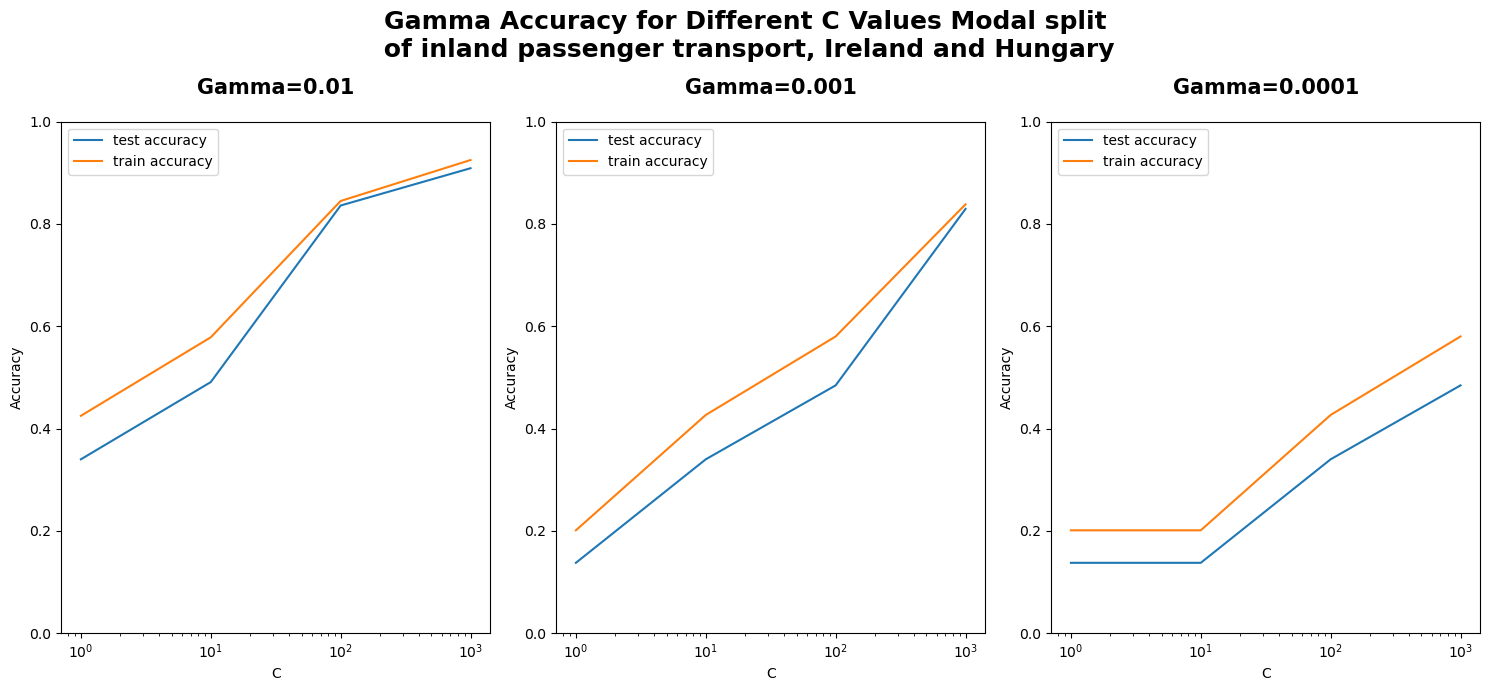

In [50]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(15,7))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# Add shared title for all subplots
plt.suptitle("Gamma Accuracy for Different C Values Modal split\n of inland passenger transport, Ireland and Hungary", fontweight="bold", fontsize=18)

plt.tight_layout()

plt.show()

In [51]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print('Tree:',tree_metr)
print('RF:',randomforest)
print('KNN:',KNN)
print('SVC:',svc)
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Tree: 94.82758620689656
RF: 93.10344827586206
KNN: 86.20689655172413
SVC: 69.23076923076923
The best test score is 0.9088172043010753 corresponding to hyperparameters {'C': 1000, 'gamma': 0.01}


Gamma = 0.01 overfitted model <br>

Gamma=0.001 less overfitted model <br>

Gamma=0.0001 fitten model <br>

This plot reveals some interesting insights:
- **High values of gamma** lead to **overfitting** (especially at high values of C); note that the training accuracy at gamma=0.01 and C=1000 reaches almost 99% 
- The **training score increases with higher gamma**, though the **test scores are comparable** (at sufficiently high cost, i.e. C > 10)

# Conclusion:
We can see that Gamma = 0.0001 Graph is at around 60% accuracy whereas Gamma Graps at 0.01 and 0.001 are hiting 80% accuracy and above. This model is overfitted.

In [52]:
# Creating figure x
Output = {
    'Model': ['Decision Tree Classifier', 'Random Forest', 'KNN', 'SVC', "GridSearchCV('C': 1000, 'gamma': 0.01})"],
    'Accuracy (%)': [94.83, 93.10, 86.21, 69.23, 90.88]
}

# Creating a DataFrame
sup_ML_Results = pd.DataFrame(Output)

sup_ML_Results

Model  Accuracy (%)
0                 Decision Tree Classifier         94.83
1                            Random Forest         93.10
2                                      KNN         86.21
3                                      SVC         69.23
4  GridSearchCV('C': 1000, 'gamma': 0.01})         90.88

# Increasing dataset to get higher accuracy at Gamma = 0.0001.

In [53]:
# Modify the code to filter based on substrings
mldf1a = mldf1a[mldf1a['Country_Vehicle'].str.contains('IE|HU', case=False, na=False)]
mldf1a.reset_index(drop=True, inplace=True)

In [54]:
def break_into_quarters(row):
    # Define the fixed weights for quarters
    weights = [0.23, 0.27,0.24 , 0.26] # weights = 1

    # Create a dataframe to store the result
    quarter_df = pd.DataFrame({'Quarter': range(1, 5),
                              'Weight': weights})

    # Calculate the value for each quarter
    quarter_df['value'] = row['value'] * quarter_df['Weight']

    # Merge the result with the original row
    quarter_df['Country_Vehicle'] = row['Country_Vehicle']
    quarter_df['Year'] = row['Year']

    return quarter_df
# Apply the function to each row of the dataframe
mldf1a = pd.concat(mldf1a.apply(break_into_quarters, axis=1).to_list(), ignore_index=True)

# Display the resulting dataframe
mldf1a

Quarter  Weight  value Country_Vehicle  Year
0          1    0.23   5.70          HU_BUS  1990
1          2    0.27   6.70          HU_BUS  1990
2          3    0.24   5.95          HU_BUS  1990
3          4    0.26   6.45          HU_BUS  1990
4          1    0.23  13.92          HU_CAR  1990
..       ...     ...    ...             ...   ...
763        4    0.26  22.28          IE_CAR  2021
764        1    0.23   0.32          IE_TRN  2021
765        2    0.27   0.38          IE_TRN  2021
766        3    0.24   0.34          IE_TRN  2021
767        4    0.26   0.36          IE_TRN  2021

[768 rows x 5 columns]

In [55]:
# Dropping the 'STATISTIC Label' column it's irrelevant for the analysis
df_col_drop = ['Quarter','Weight']
mldf1a.drop(df_col_drop ,axis=1, inplace=True) 

In [56]:
# Move the 'Year' column to the second position
mldf1a.insert(2, 'value', mldf1a.pop('value'))

In [57]:
mldf1a.head()

Country_Vehicle  Year  value
0          HU_BUS  1990   5.70
1          HU_BUS  1990   6.70
2          HU_BUS  1990   5.95
3          HU_BUS  1990   6.45
4          HU_CAR  1990  13.92

In [58]:
# Creating a LabelEncoder instance
le = LabelEncoder()

# Encoding the 'Country_Vehicle' column
mldf1a['Country_Vehicle'] = le.fit_transform(mldf1a['Country_Vehicle'])
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
mldf1a

Country_Vehicle  Year  value
0                  0  1990   5.70
1                  0  1990   6.70
2                  0  1990   5.95
3                  0  1990   6.45
4                  1  1990  13.92
..               ...   ...    ...
763                4  2021  22.28
764                5  2021   0.32
765                5  2021   0.38
766                5  2021   0.34
767                5  2021   0.36

[768 rows x 3 columns]

In [59]:
X = mldf1a.iloc[:, [1,2]].values # Dependent variables
y = mldf1a.iloc[:, 0].values # Target variable

In [60]:
X

array([['1990', 5.704000000000001],
       ['1990', 6.696000000000001],
       ['1990', 5.952],
       ...,
       ['2021', 0.378],
       ['2021', 0.33599999999999997],
       ['2021', 0.364]], dtype=object)

In [61]:
y

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4,
       5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4,
       4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3,
       4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3,
       3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
       3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0,
       1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0,
       0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
       0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3,

## Splitting the dataset into the Training set and Test set

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Feature Scaling

In [63]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DecisionTreeClassifier
## Training the Decision Tree Classification model on the Training set

In [64]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

## Predicting the Test and set results

In [65]:
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix

In [66]:
# Saving values into new variables to reproduce results in 4.5.Table and Conclusions

y_test2 = y_test
y_pred2 = y_pred

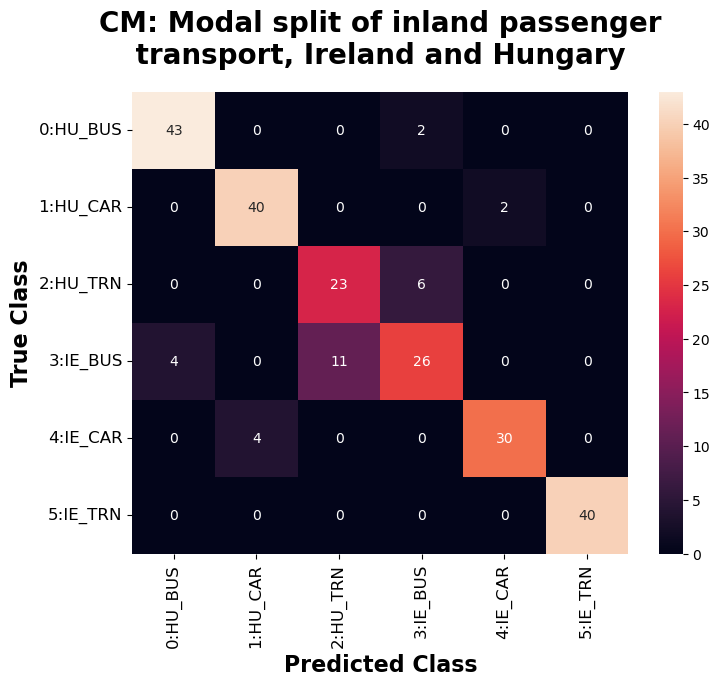

In [67]:
# Calculating confusion matrix
confMtrx2 = confusion_matrix(y_test2, y_pred2)

# Define class labels
class_labels = ['0:HU_BUS', '1:HU_CAR', '2:HU_TRN', '3:IE_BUS', '4:IE_CAR', '5:IE_TRN']

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confMtrx2, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('CM: Modal split of inland passenger\n transport, Ireland and Hungary ', loc="center", pad=20, fontsize=20, fontweight="bold")
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
plt.ylabel('True Class', fontsize=16, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12)
plt.show()

In [68]:
# We don't want scientific notation
np.set_printoptions(suppress=True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))
# Which is the accuracy for the classifier???
print("Classifier Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4)*100)

tree_metr1 = metrics.accuracy_score(y_test, y_pred)*100

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        45
           1       0.91      0.95      0.93        42
           2       0.68      0.79      0.73        29
           3       0.76      0.63      0.69        41
           4       0.94      0.88      0.91        34
           5       1.00      1.00      1.00        40

    accuracy                           0.87       231
   macro avg       0.87      0.87      0.87       231
weighted avg       0.88      0.87      0.87       231

Classifier Accuracy: 87.45


### Classification Report Interpretation:

#### Class 0:

- **Precision:** 0.91 - Of the instances predicted as class 0, 91% were actually class 0.
- **Recall:** 0.96 - Of all the instances that are actually class 0, 96% were correctly predicted.
- **F1-score:** 0.93 - A balanced metric considering both precision and recall.

#### Class 1:

- **Precision:** 0.91 - Of the instances predicted as class 1, 91% were actually class 1.
- **Recall:** 0.95 - Of all the instances that are actually class 1, 95% were correctly predicted.
- **F1-score:** 0.93 - A balanced metric indicating good precision and recall.

#### Class 2:

- **Precision:** 0.68 - Only 68% of the instances predicted as class 2 were actually class 2.
- **Recall:** 0.79 - Almost 79% of the actual class 2 instances were correctly predicted.
- **F1-score:** 0.73 - A moderate F1-score indicating a trade-off between precision and recall.

#### Class 3:

- **Precision:** 0.76 - Of the instances predicted as class 3, 76% were actually class 3.
- **Recall:** 0.63 - About 63% of the actual class 3 instances were correctly predicted.
- **F1-score:** 0.69 - A balanced metric with a moderate F1-score.

#### Class 4:

- **Precision:** 0.94 - Of the instances predicted as class 4, 94% were actually class 4.
- **Recall:** 0.88 - About 88% of the actual class 4 instances were correctly predicted.
- **F1-score:** 0.91 - A high F1-score indicating good precision and recall.

#### Class 5:

- **Precision:** 1.00 - All instances predicted as class 5 were actually class 5.
- **Recall:** 1.00 - All actual class 5 instances were correctly predicted.
- **F1-score:** 1.00 - Perfect precision and recall.

### Overall Metrics:

- **Accuracy:** 87.45% - The overall accuracy of the model on all classes.
- **Precision (Macro Avg):** 87% - The unweighted average precision across all classes.
- **Recall (Macro Avg):** 87% - The unweighted average recall across all classes.
- **F1-score (Macro Avg):** 87% - The unweighted average F1-score across all classes.

### Weighted Averages:

- **Precision (Weighted Avg):** 88% - The weighted average precision, considering the number of instances in each class.
- **Recall (Weighted Avg):** 87% - The weighted average recall, considering the number of instances in each class.
- **F1-score (Weighted Avg):** 87% - The weighted average F1-score, considering the number of instances in each class.

### Classifier Accuracy:

- **Classifier Accuracy:** 87.45% - The overall accuracy of the classifier on the entire dataset.


In [69]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0,verbose=0)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.2f}'. format(accuracy_score(y_test, y_pred)*100))
randomforest = accuracy_score(y_test, y_pred)*100

Model accuracy score with 10 decision-trees : 91.77


[Text(0.4375, 0.9, 'x[1] <= 0.252\ngini = 0.833\nsamples = 537\nvalue = [83, 86, 99, 87, 94, 88]'),
 Text(0.1875, 0.7, 'x[1] <= -0.933\ngini = 0.749\nsamples = 357\nvalue = [83, 0, 99, 87, 0, 88]'),
 Text(0.125, 0.5, 'gini = 0.0\nsamples = 88\nvalue = [0, 0, 0, 0, 0, 88]'),
 Text(0.25, 0.5, 'x[1] <= -0.556\ngini = 0.665\nsamples = 269\nvalue = [83, 0, 99, 87, 0, 0]'),
 Text(0.125, 0.3, 'x[1] <= -0.667\ngini = 0.523\nsamples = 189\nvalue = [5, 0, 99, 85, 0, 0]'),
 Text(0.0625, 0.1, 'gini = 0.322\nsamples = 99\nvalue = [0, 0, 79, 20, 0, 0]'),
 Text(0.1875, 0.1, 'gini = 0.426\nsamples = 90\nvalue = [5, 0, 20, 65, 0, 0]'),
 Text(0.375, 0.3, 'x[1] <= -0.506\ngini = 0.049\nsamples = 80\nvalue = [78, 0, 0, 2, 0, 0]'),
 Text(0.3125, 0.1, 'gini = 0.5\nsamples = 4\nvalue = [2, 0, 0, 2, 0, 0]'),
 Text(0.4375, 0.1, 'gini = 0.0\nsamples = 76\nvalue = [76, 0, 0, 0, 0, 0]'),
 Text(0.6875, 0.7, 'x[1] <= 1.344\ngini = 0.499\nsamples = 180\nvalue = [0, 86, 0, 0, 94, 0]'),
 Text(0.5625, 0.5, 'x[1] <= 1.3

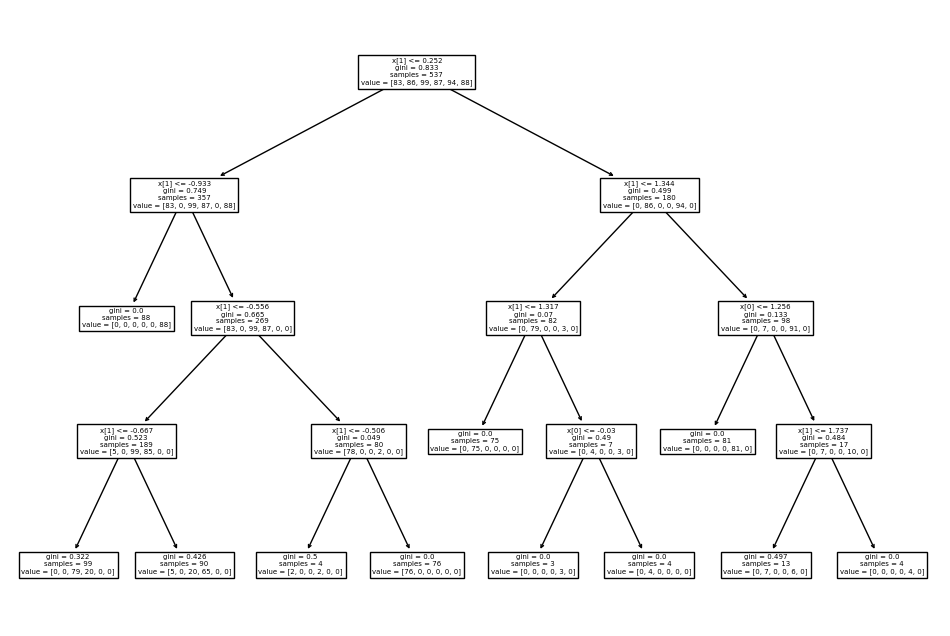

In [70]:
plt.figure(figsize=(12,8))
tree.plot_tree(classifier.fit(X_train, y_train)) 

## Interpretation:
The first line represents the root node of the decision tree. It checks if the value of feature `x[1]` is less than or equal to 0.252. If true, it proceeds to the left child node; otherwise, it goes to the right child node. The Gini index is 0.833, and there are 537 samples with corresponding class distribution: [83, 86, 99, 87, 94, 88].

The second line represents a child node. It checks if the value of `x[1]` is less than or equal to -0.933. If true, it goes to the left child node, and if false, it goes to the right child node. The Gini index is 0.749, and there are 357 samples with class distribution: [83, 0, 99, 87, 0, 88].

The third line represents a leaf node. It has a Gini index of 0.0, indicating a pure node with all samples belonging to the same class. The samples (88 instances) in this node all belong to the sixth class, as indicated by the `value` array: [0, 0, 0, 0, 0, 88].

The rest of the lines follow the same logic.

In [71]:
# Saving values into new variables to reproduce results in 4.5.Table and Conclusions
X_train1 = X_train
y_train1  = y_train

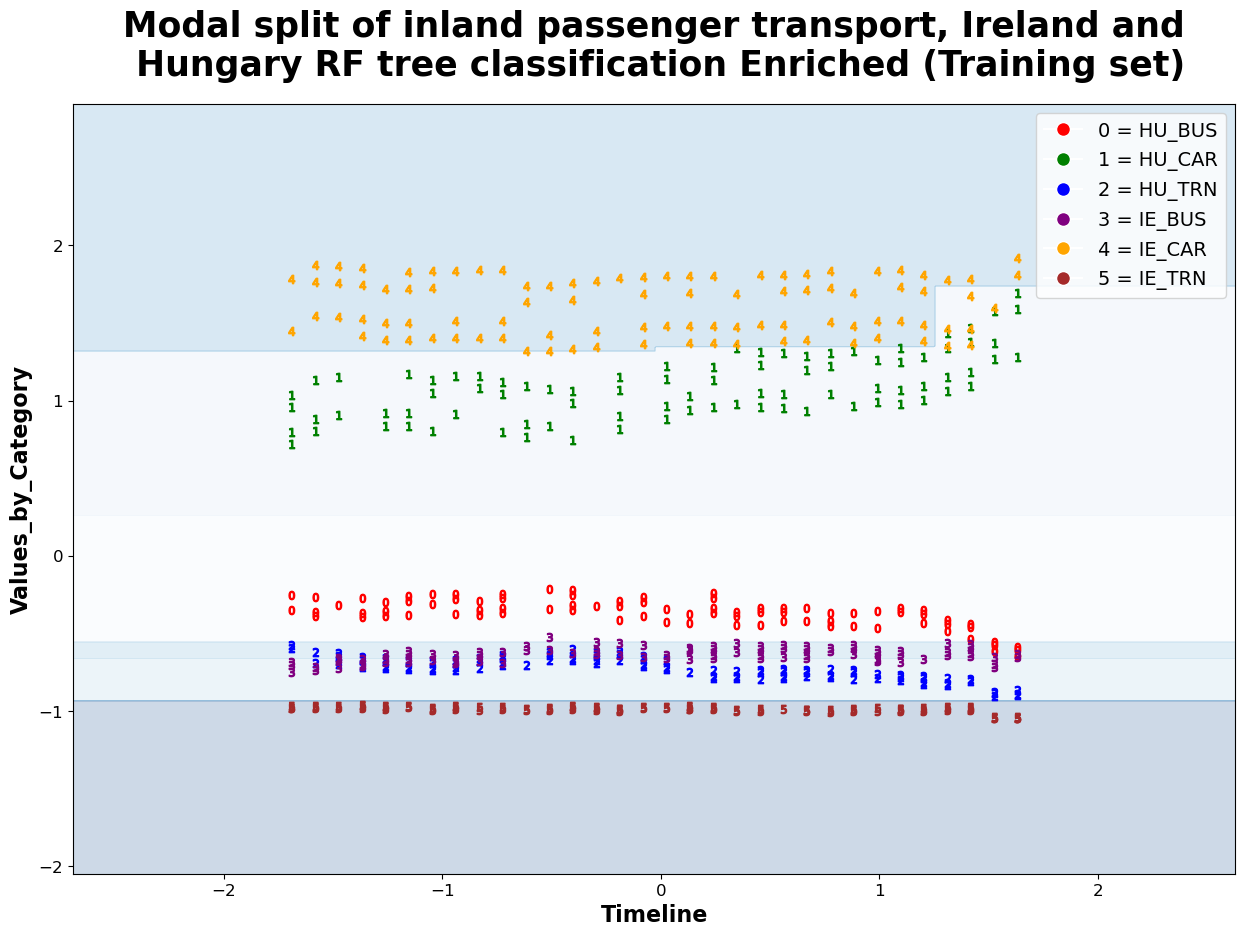

In [72]:
# Plotting the dataset
plt.figure(figsize=(15, 10))
X_set1, y_set1 = X_train1, y_train1
X12, X23 = np.meshgrid(np.arange(start=X_set1[:, 0].min() - 1, stop=X_set1[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set1[:, 1].min() - 1, stop=X_set1[:, 1].max() + 1, step=0.01))

# Contour plot
contour1 = plt.contourf(X12, X23, classifier.predict(np.array([X12.ravel(), X23.ravel()]).T).reshape(X12.shape),
                       alpha=0.2, cmap='Blues')



# Scatter plot for data points
for i, j in enumerate(np.unique(y_set1)):
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
    plt.scatter(X_set1[y_set1 == j, 0], X_set1[y_set1 == j, 1],
                c=colors[j], marker=f"${j}$",
                label=f'{j} = {"" if j == 1 else ""}')

# Legend for scatter plot
legend_labels = {
    0: 'HU_BUS',
    1: 'HU_CAR',
    2: 'HU_TRN',
    3: 'IE_BUS',
    4: 'IE_CAR',
    5: 'IE_TRN'
}
plt.legend(handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                           markersize=10, label=f'{i} = {legend_labels[i]}') for i in np.unique(y_set1)],
           loc='best', fontsize=14)

plt.title('Modal split of inland passenger transport, Ireland and\n Hungary RF tree classification Enriched (Training set)', loc="center", pad=20, fontsize=25, fontweight="bold")
plt.xlabel('Timeline', fontsize=16, fontweight='bold')
plt.ylabel('Values_by_Category', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Creating a K-Nearest Neighbor Classifier

In [73]:
neighbors1 = np.arange(1, 20)                  # number of neighbors
train_accuracy1 = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy1 = np.zeros(len(neighbors))     # Declare and initialise the matrix

In [74]:
# Saving values into new variables to reproduce results in 4.5.Table and Conclusions

X_trainb = X_train
y_trainb = y_train
X_testb = X_test
y_testb = y_test

In [75]:
for i,k in enumerate(neighbors1):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_trainb, y_trainb)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy1[i] = knn.score(X_trainb, y_trainb)      # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy1[i] = knn.score(X_testb, y_testb)      # Save the score value in the train_accuracy array

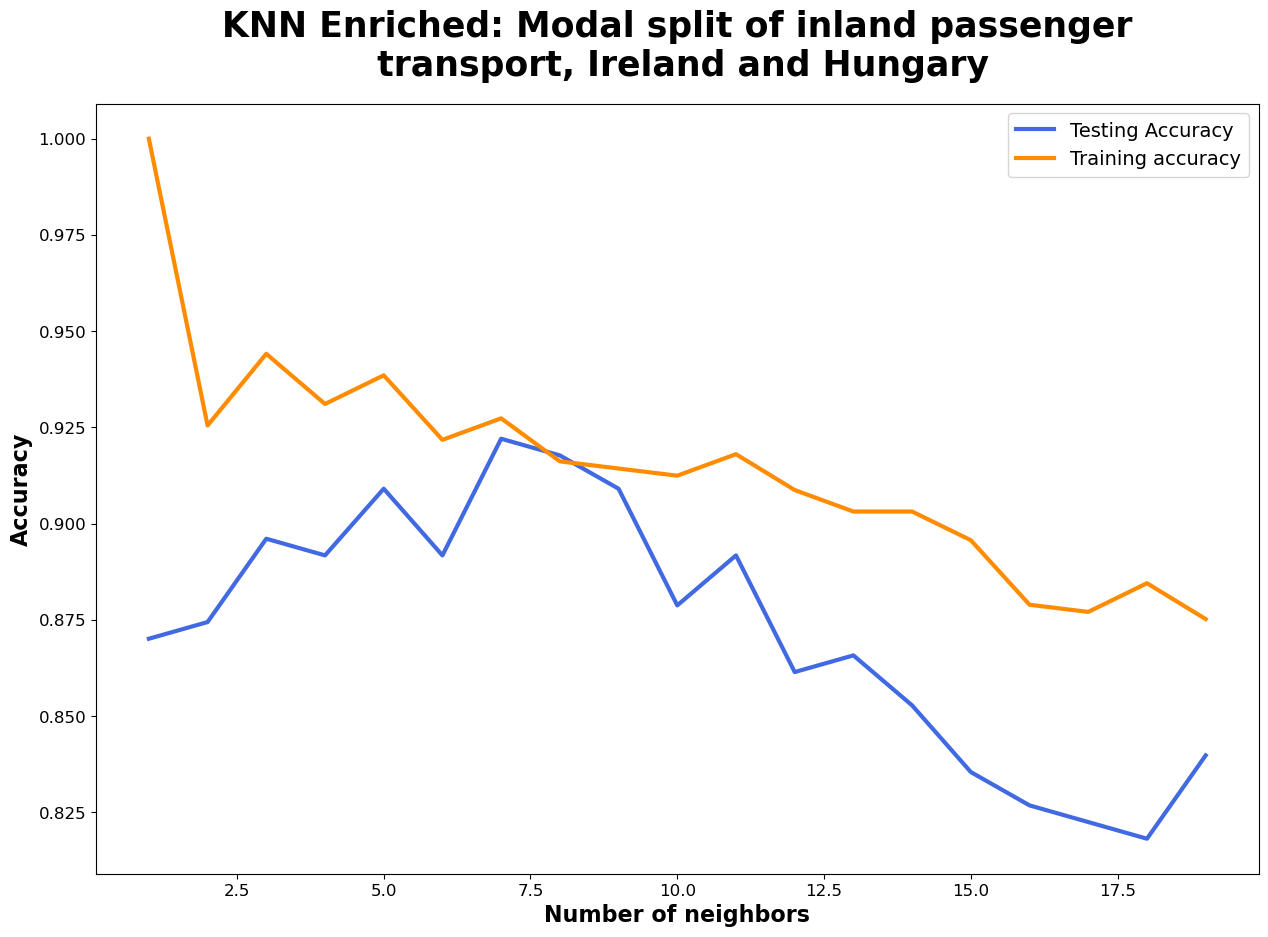

In [76]:
plt.figure(figsize=(15, 10))
plt.title('KNN Enriched: Modal split of inland passenger\n transport, Ireland and Hungary',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.plot(neighbors1, test_accuracy1, label='Testing Accuracy', linewidth=3, color='royalblue')
plt.plot(neighbors1, train_accuracy1, label='Training accuracy', linewidth=3, color='darkorange')

plt.xlabel('Number of neighbors',fontsize=16, fontweight='bold')
plt.ylabel('Accuracy',fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend( loc='best', fontsize=14)
plt.show()

In [77]:
# Declare and initialise an object 'KNeighborsClassifier' with 3 neighbors
knn = KNeighborsClassifier(n_neighbors = 2)

# Fit the model
knn.fit(X_trainb, y_trainb)   

# Compute accuracy on the training set
train_accuracy = knn.score(X_trainb, y_trainb)   

# Compute accuracy on the test set
test_accuracy = knn.score(X_testb, y_testb)  

In [78]:
# Display the test accuracy

print('Test accuracy = ', round(test_accuracy*100,2))
KNN=test_accuracy*100

Test accuracy =  87.45


# Parameter tunning GridSearch

In [79]:
# scaling the features

X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

## Model Building

In [80]:
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [81]:
# Saving values into new variables to reproduce results in 4.5.Table and Conclusions

y_test3 = y_test
y_pred3 = y_pred

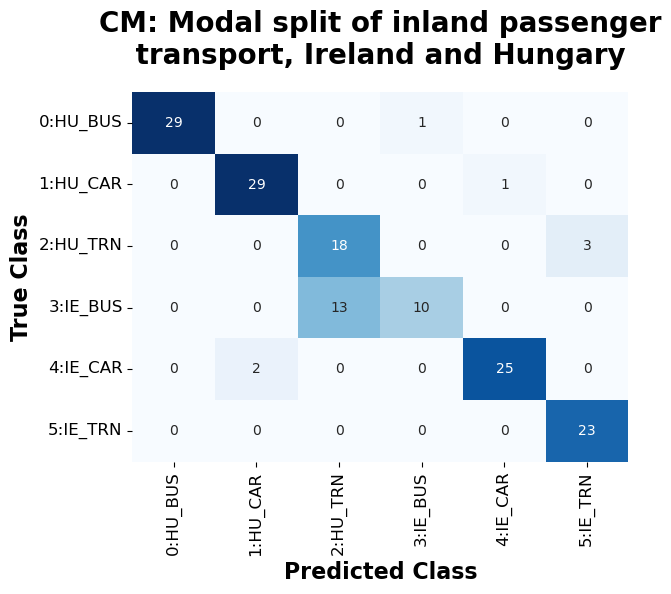

In [82]:
# Generate the confusion matrix
confMtrx3 = metrics.confusion_matrix(y_true=y_test3, y_pred=y_pred3)

# Define class labels
class_labels = ['0:HU_BUS', '1:HU_CAR', '2:HU_TRN', '3:IE_BUS', '4:IE_CAR', '5:IE_TRN']

# Create a heatmap of the confusion matrix

sns.heatmap(confMtrx3, annot = True, fmt = "d", cmap = "Blues", cbar = False, xticklabels=class_labels, yticklabels=class_labels) 
plt.title('CM: Modal split of inland passenger\n transport, Ireland and Hungary ', loc="center", pad=20, fontsize=20, fontweight="bold")
plt.xlabel('Predicted Class', fontsize=16, fontweight='bold')
plt.ylabel('True Class', fontsize=16, fontweight='bold')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12)
plt.show()

In [83]:
# Printing classification report
print(classification_report(y_test, y_pred))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

svc = metrics.accuracy_score(y_test, y_pred)*100

# precision
print("precision", metrics.precision_score(y_test, y_pred, average='weighted'))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.94      0.97      0.95        30
           2       0.58      0.86      0.69        21
           3       0.91      0.43      0.59        23
           4       0.96      0.93      0.94        27
           5       0.88      1.00      0.94        23

    accuracy                           0.87       154
   macro avg       0.88      0.86      0.85       154
weighted avg       0.89      0.87      0.86       154

accuracy 0.8701298701298701
precision 0.8926938164474821
recall 0.8701298701298701


### Classification Report Interpretation:

#### Class 0:

- **Precision:** 1.00 - Of the instances predicted as class 0, 100% were actually class 0.
- **Recall:** 0.97 - Of all the instances that are actually class 0, 97% were correctly predicted.
- **F1-score:** 0.98 - A high F1-score indicating excellent precision and recall.

#### Class 1:

- **Precision:** 0.94 - Of the instances predicted as class 1, 94% were actually class 1.
- **Recall:** 0.97 - Of all the instances that are actually class 1, 97% were correctly predicted.
- **F1-score:** 0.95 - A balanced metric indicating good precision and recall.

#### Class 2:

- **Precision:** 0.58 - Only 58% of the instances predicted as class 2 were actually class 2.
- **Recall:** 0.86 - A relatively high recall, indicating a good proportion of actual class 2 instances correctly predicted.
- **F1-score:** 0.69 - A moderate F1-score indicating a trade-off between precision and recall.

#### Class 3:

- **Precision:** 0.91 - Of the instances predicted as class 3, 91% were actually class 3.
- **Recall:** 0.43 - About 43% of the actual class 3 instances were correctly predicted.
- **F1-score:** 0.59 - A balanced metric with a moderate F1-score.

#### Class 4:

- **Precision:** 0.96 - Of the instances predicted as class 4, 96% were actually class 4.
- **Recall:** 0.93 - About 93% of the actual class 4 instances were correctly predicted.
- **F1-score:** 0.94 - A high F1-score indicating excellent precision and recall.

#### Class 5:

- **Precision:** 0.88 - Of the instances predicted as class 5, 88% were actually class 5.
- **Recall:** 1.00 - All actual class 5 instances were correctly predicted.
- **F1-score:** 0.94 - A balanced metric indicating good precision and recall.

### Overall Metrics:

- **Accuracy:** 87.01% - The overall accuracy of the model on all classes.
- **Precision (Macro Avg):** 88% - The unweighted average precision across all classes.
- **Recall (Macro Avg):** 86% - The unweighted average recall across all classes.
- **F1-score (Macro Avg):** 85% - The unweighted average F1-score across all classes.

### Weighted Averages:

- **Precision (Weighted Avg):** 89.27% - The weighted average precision, considering the number of instances in each class.
- **Recall (Weighted Avg):** 87.01% - The weighted average recall, considering the number of instances in each class.
- **F1-score (Weighted Avg):** 86.01% - The weighted average F1-score, considering the number of instances in each class.

### Additional Metrics:

- **Classifier Accuracy:** 87.01% - The overall accuracy of the classifier on the entire dataset.
- **Classifier Precision:** 89.27% - The overall precision of the classifier.
- **Classifier Recall:** 87.01% - The overall recall of the classifier.


## Grid Search to Find Optimal Hyperparameters

In [84]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.01, 0.001, 0.0001],
                     'C': [1, 10, 100, 1000]}]#,
                


# specify model
model = SVC(kernel = "rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring = 'accuracy', 
                        cv = folds, 
                        verbose = 4, # Changing verbose from 1 to 4, to display records :)
                        return_train_score = True)      

# fit the model
model_cv.fit(X_train, y_train)     

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=1, gamma=0.01;, score=(train=0.487, test=0.366) total time=   0.0s
[CV 2/5] END C=1, gamma=0.01;, score=(train=0.356, test=0.252) total time=   0.0s
[CV 3/5] END C=1, gamma=0.01;, score=(train=0.340, test=0.333) total time=   0.0s
[CV 4/5] END C=1, gamma=0.01;, score=(train=0.354, test=0.260) total time=   0.0s
[CV 5/5] END C=1, gamma=0.01;, score=(train=0.346, test=0.295) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001;, score=(train=0.187, test=0.122) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001;, score=(train=0.356, test=0.252) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001;, score=(train=0.177, test=0.171) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001;, score=(train=0.181, test=0.146) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001;, score=(train=0.183, test=0.123) total time=   0.0s
[CV 1/5] END C=1, gamma=0.0001;, score=(train=0.187, test=0.122) total time=   0.0s
[CV 2/5] END C=1, gamma=0.0001

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [85]:
## cv results
cv_results1 = pd.DataFrame(model_cv.cv_results_)

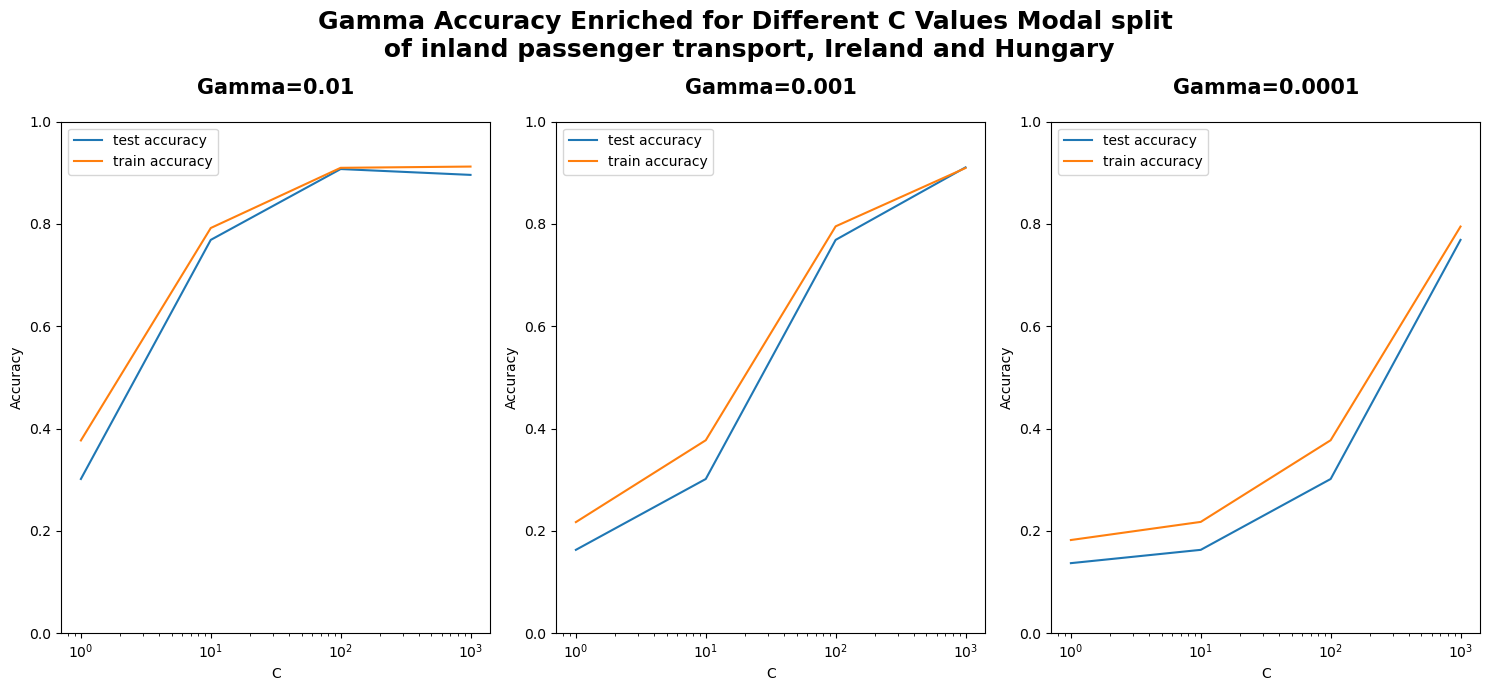

In [86]:
# converting C to numeric type for plotting on x-axis
cv_results1['param_C'] = cv_results1['param_C'].astype('int')

# # plotting
plt.figure(figsize=(15,7))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results1[cv_results1['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results1[cv_results1['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results1[cv_results1['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# Add shared title for all subplots
plt.suptitle("Gamma Accuracy Enriched for Different C Values Modal split\n of inland passenger transport, Ireland and Hungary", fontweight="bold", fontsize=18)

plt.tight_layout()

plt.show()

In [87]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_
print('Tree:',tree_metr1)
print('RF:',randomforest)
print('KNN:',KNN)
print('SVC:',svc)
print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Tree: 87.44588744588745
RF: 91.77489177489177
KNN: 87.44588744588745
SVC: 87.01298701298701
The best test score is 0.9104491536718646 corresponding to hyperparameters {'C': 1000, 'gamma': 0.001}


Best test score is 0.91 at Gamma = 0.001 and Gamma = 0.0001 is above 80% this by expanding the dataset the model is less overfitted, more fitted now!

In [88]:
# Creating figure x
Output1 = {
    'Model': ['Decision Tree Classifier', 'Random Forest', 'KNN', 'SVC', "GridSearchCV('C': 1000, 'gamma': 0.001})"],
    'Accuracy (%)': [87.44, 91.77, 87.44, 87.01, 91.04]
}

# Creating a DataFrame
sup_ML_Results1 = pd.DataFrame(Output1)

sup_ML_Results1

Model  Accuracy (%)
0                  Decision Tree Classifier         87.44
1                             Random Forest         91.77
2                                       KNN         87.44
3                                       SVC         87.01
4  GridSearchCV('C': 1000, 'gamma': 0.001})         91.04

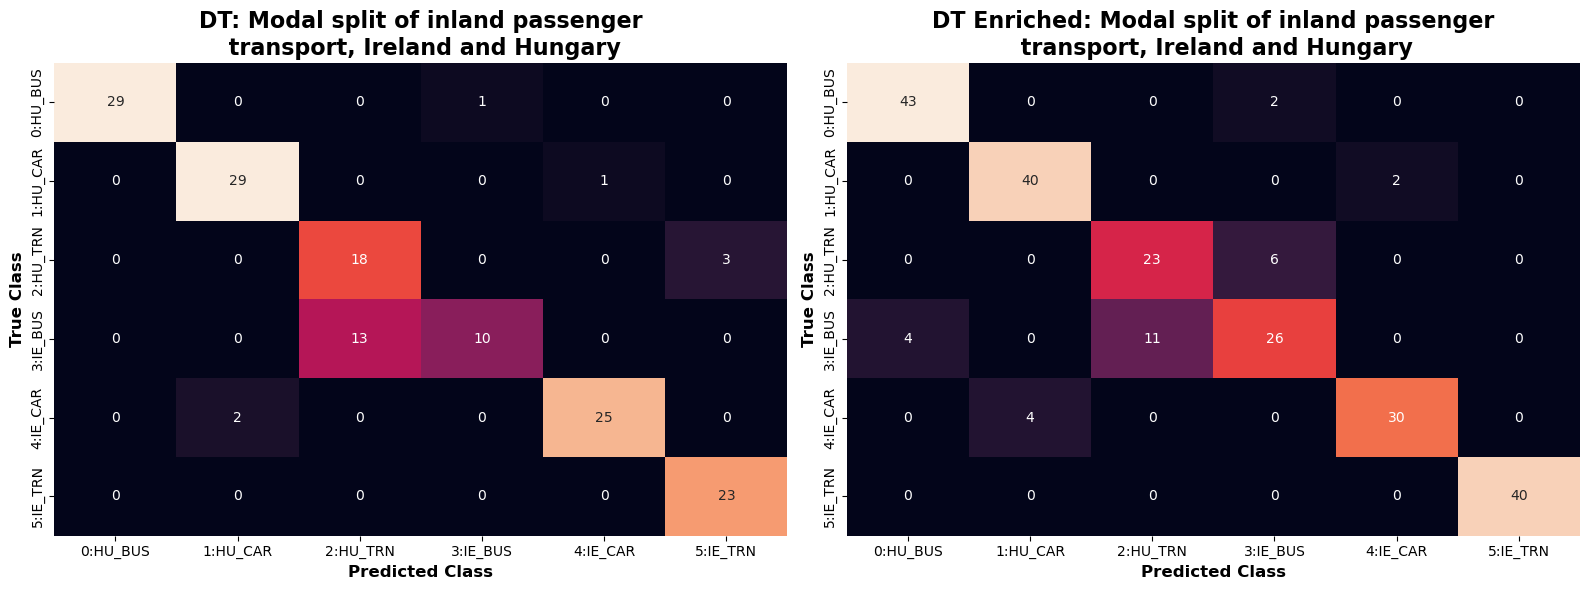

In [89]:
# Decision Tree CM:
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first confusion matrix on the left
confMtrx = confusion_matrix(y_test, y_pred)
sns.heatmap(confMtrx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0],cbar = False)
axes[0].set_title('DT: Modal split of inland passenger\n transport, Ireland and Hungary', fontsize=16, fontweight="bold")
axes[0].set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Class', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=10)

# Plot the second confusion matrix on the right
confMtrx2 = confusion_matrix(y_test2, y_pred2)
sns.heatmap(confMtrx2, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=axes[1],cbar = False)
axes[1].set_title('DT Enriched: Modal split of inland passenger\n transport, Ireland and Hungary', fontsize=16, fontweight="bold")
axes[1].set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Class', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=10)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


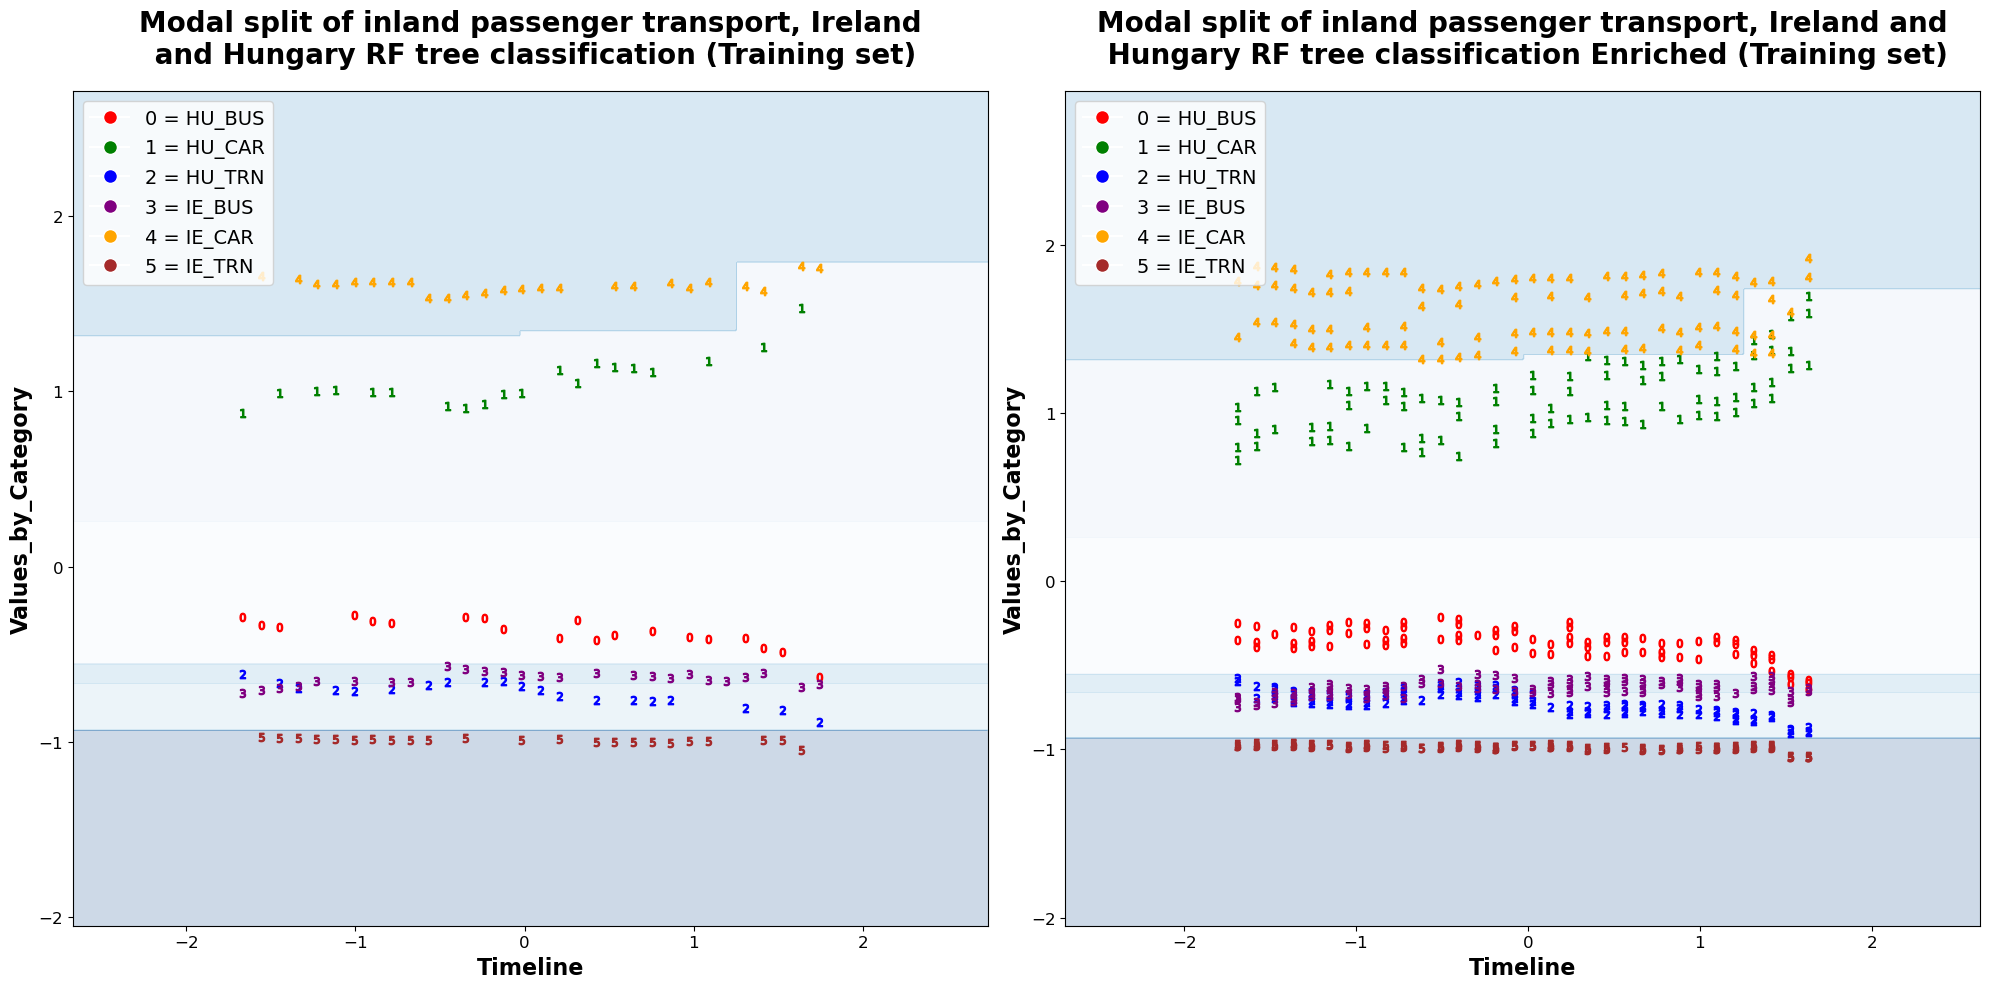

In [90]:
# Random Forest graphs:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming you have X_train, y_train, and classifier defined

# Plotting the dataset
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot on the left
axes[0].contourf(X11, X22, classifier.predict(np.array([X11.ravel(), X22.ravel()]).T).reshape(X11.shape),
                 alpha=0.2, cmap='Blues')

for i, j in enumerate(np.unique(y_set)):
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
    axes[0].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c=colors[j], marker=f"${j}$",
                    label=f'{j} = {"" if j == 1 else ""}')

axes[0].legend(handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                               markersize=10, label=f'{i} = {legend_labels[i]}') for i in np.unique(y_set)],
               loc='upper left', fontsize=14)

axes[0].set_title('Modal split of inland passenger transport, Ireland\n and Hungary RF tree classification (Training set)',
                  loc="center", pad=20, fontsize=20, fontweight="bold")
axes[0].set_xlabel('Timeline', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Values_by_Category', fontsize=16, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=12)

# Plot on the right
axes[1].contourf(X12, X23, classifier.predict(np.array([X12.ravel(), X23.ravel()]).T).reshape(X12.shape),
                 alpha=0.2, cmap='Blues')

for i, j in enumerate(np.unique(y_set1)):
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
    plt.scatter(X_set1[y_set1 == j, 0], X_set1[y_set1 == j, 1],
                c=colors[j], marker=f"${j}$",
                label=f'{j} = {"" if j == 1 else ""}')


axes[1].legend(handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                               markersize=10, label=f'{i} = {legend_labels[i]}') for i in np.unique(y_set1)],
               loc='upper left', fontsize=14)

axes[1].set_title('Modal split of inland passenger transport, Ireland and\n Hungary RF tree classification Enriched (Training set)',
                  loc="center", pad=20, fontsize=20, fontweight="bold")
axes[1].set_xlabel('Timeline', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Values_by_Category', fontsize=16, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=12)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

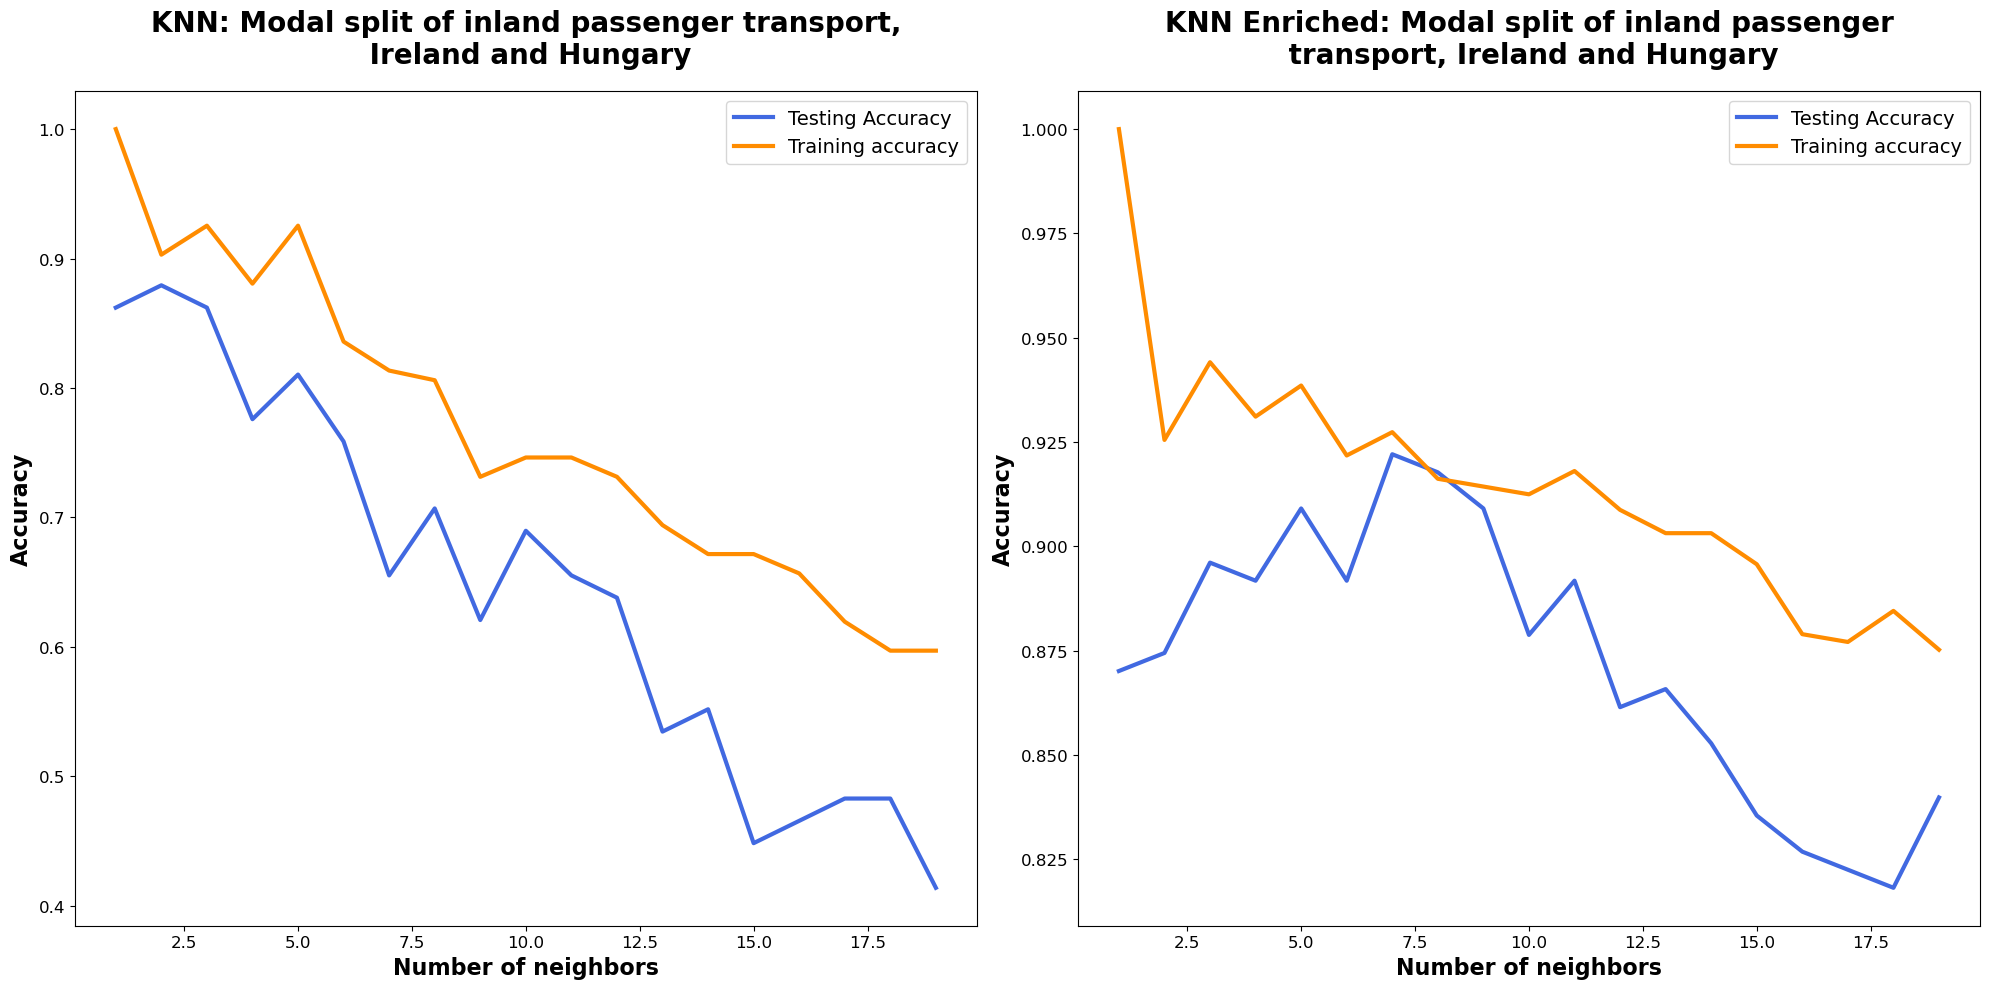

In [91]:
# Plotting KNN side by side

neighbors = np.arange(1, 20)                  # number of neighbors
train_accuracy = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix

neighbors1 = np.arange(1, 20)                  # number of neighbors
train_accuracy1 = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy1 = np.zeros(len(neighbors))     # Declare and initialise the matrix

for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_traina, y_traina)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_traina, y_traina)      # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_testa, y_testa)      # Save the score value in the train_accuracy array

for i,k in enumerate(neighbors1):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(X_trainb, y_trainb)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy1[i] = knn.score(X_trainb, y_trainb)      # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy1[i] = knn.score(X_testb, y_testb)      # Save the score value in the train_accuracy array


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot on the left
axes[0].plot(neighbors, test_accuracy, label='Testing Accuracy', linewidth=3, color='royalblue')
axes[0].plot(neighbors, train_accuracy, label='Training accuracy', linewidth=3, color='darkorange')

axes[0].set_title('KNN: Modal split of inland passenger transport,\n Ireland and Hungary',
                  loc="center", pad=20, fontsize=20, fontweight="bold")
axes[0].set_xlabel('Number of neighbors', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=16, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(loc='best', fontsize=14)

# Plot on the right
axes[1].plot(neighbors1, test_accuracy1, label='Testing Accuracy', linewidth=3, color='royalblue')
axes[1].plot(neighbors1, train_accuracy1, label='Training accuracy', linewidth=3, color='darkorange')

axes[1].set_title('KNN Enriched: Modal split of inland passenger\n transport, Ireland and Hungary',
                  loc="center", pad=20, fontsize=20, fontweight="bold")
axes[1].set_xlabel('Number of neighbors', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=16, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(loc='best', fontsize=14)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


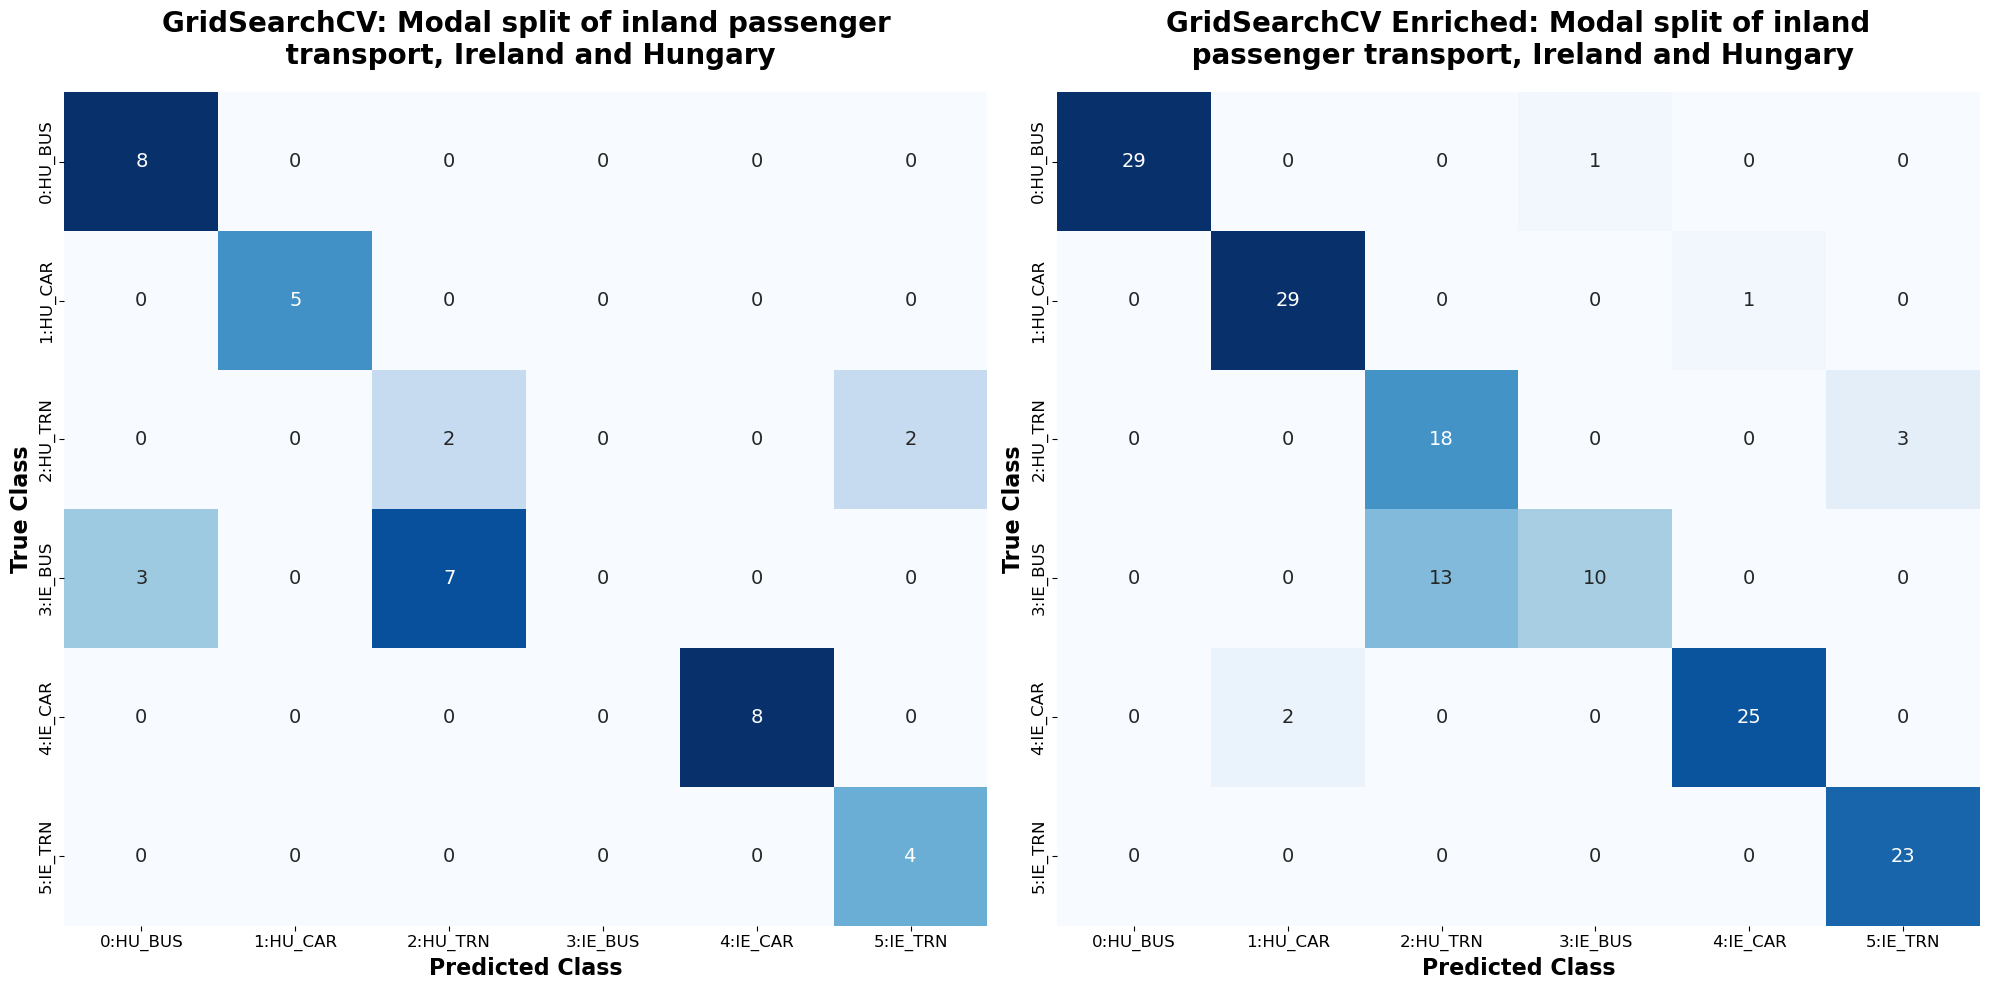

In [92]:

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot on the left
confMtrx1 = metrics.confusion_matrix(y_true=y_test1, y_pred=y_pred1)
sns.heatmap(confMtrx1, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels, ax=axes[0],
            annot_kws={"size": 14})  # Adjust the font size here
axes[0].set_title('GridSearchCV: Modal split of inland passenger\n transport, Ireland and Hungary',
                  loc="center", pad=20, fontsize=20, fontweight="bold")
axes[0].set_xlabel('Predicted Class', fontsize=16, fontweight='bold')
axes[0].set_ylabel('True Class', fontsize=16, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=12)

# Plot on the right
confMtrx3 = metrics.confusion_matrix(y_true=y_test3, y_pred=y_pred3)
sns.heatmap(confMtrx3, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels, ax=axes[1],
            annot_kws={"size": 14})  # Adjust the font size here
axes[1].set_title('GridSearchCV Enriched: Modal split of inland\n passenger transport, Ireland and Hungary',
                  loc="center", pad=20, fontsize=20, fontweight="bold")
axes[1].set_xlabel('Predicted Class', fontsize=16, fontweight='bold')
axes[1].set_ylabel('True Class', fontsize=16, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=12)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


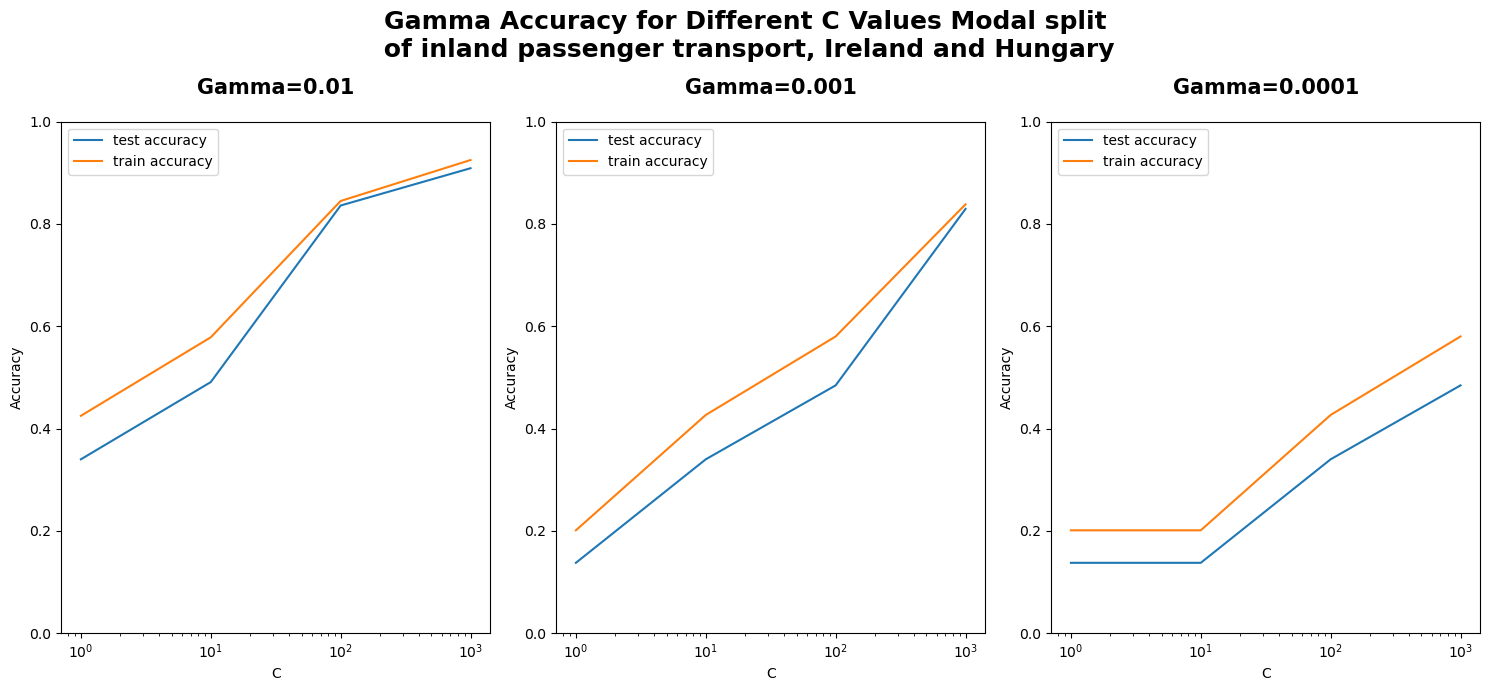

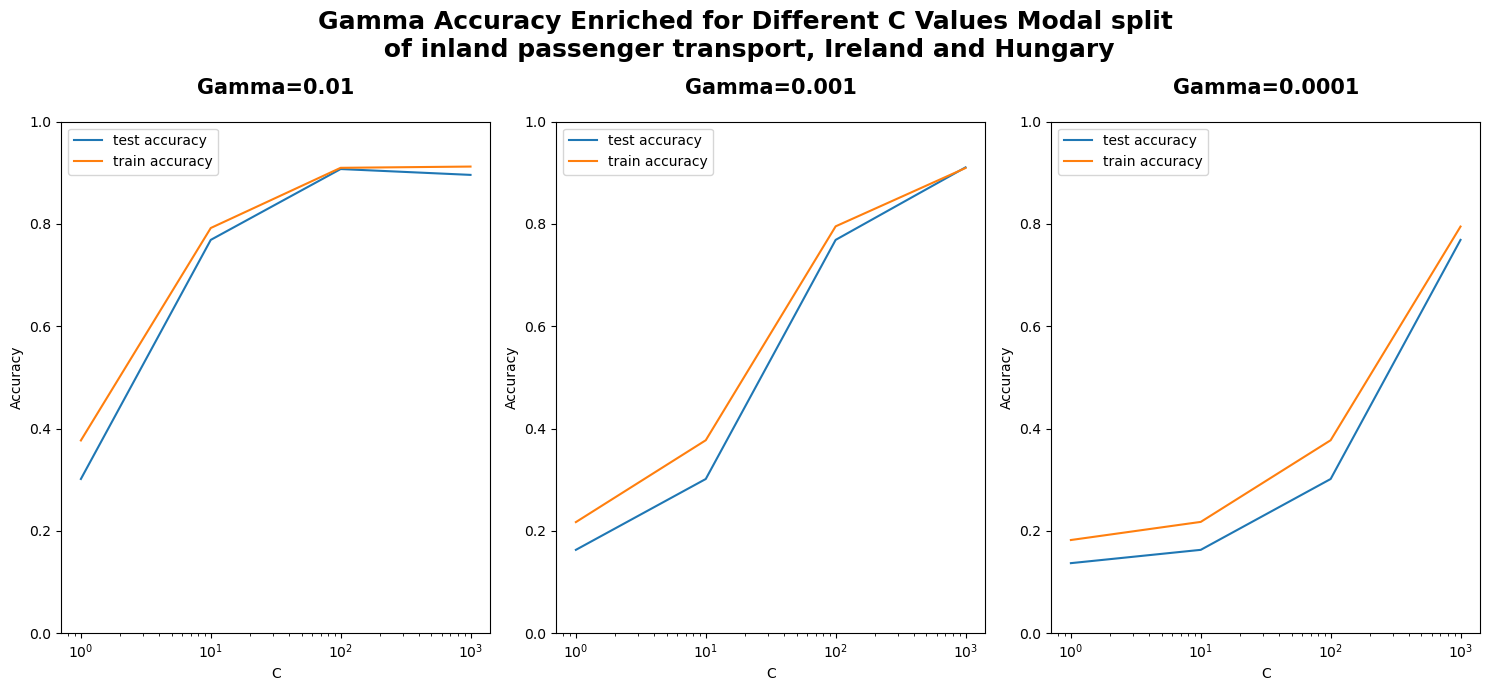

In [93]:
# GridSearchCV Plots:
# First set of plots
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(15,7))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# Add shared title for all subplots
plt.suptitle("Gamma Accuracy for Different C Values Modal split\n of inland passenger transport, Ireland and Hungary", fontweight="bold", fontsize=18)

plt.tight_layout()

plt.show()

# Second set of plots
# converting C to numeric type for plotting on x-axis
cv_results1['param_C'] = cv_results1['param_C'].astype('int')

# # plotting
plt.figure(figsize=(15,7))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results1[cv_results1['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results1[cv_results1['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results1[cv_results1['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001",fontweight="bold",loc="center", pad=20, fontsize=15)
plt.ylim([0, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# Add shared title for all subplots
plt.suptitle("Gamma Accuracy Enriched for Different C Values Modal split\n of inland passenger transport, Ireland and Hungary", fontweight="bold", fontsize=18)

plt.tight_layout()

plt.show()


In [94]:
# Table for summary:

# Creating figure x
Output2 = {
    'Model': ['Decision Tree Classifier', 'Random Forest', 'KNN', 'SVC', "GridSearchCV('C': 1000, 'gamma': 0.01})","GridSearchCV('C': 1000, 'gamma': 0.001})"],
    'Accuracy (%)': [94.83, 93.10, 86.21, 69.23, 90.88,'N/A'],
    'Accuracy_Enriched (%)': [87.44, 91.77, 87.44, 87.01,'N/A' ,91.04]
}

# Creating a DataFrame
sup_ML_Results2 = pd.DataFrame(Output2)
sup_ML_Results2

Model Accuracy (%) Accuracy_Enriched (%)
0                  Decision Tree Classifier        94.83                 87.44
1                             Random Forest        93.10                 91.77
2                                       KNN        86.21                 87.44
3                                       SVC        69.23                 87.01
4   GridSearchCV('C': 1000, 'gamma': 0.01})        90.88                   N/A
5  GridSearchCV('C': 1000, 'gamma': 0.001})          N/A                 91.04

# 4.2. Cross validation and feature reduction.

In [95]:
mldf2a = mldf2.copy() # Dataset for Second part
mldf2b = mldf2.copy() # Dataset for Unsupervised ML Enriched

In [96]:
mldf2

Year  AT_BUS  AT_CAR  AT_TRN  BE_BUS  BE_CAR  BE_TRN  CH_BUS  CH_CAR  \
0   1990   11.00   77.10   11.90   10.60   83.30    6.10    3.70   82.10   
1   1991   10.60   77.00   12.40   10.70   83.30    6.10    3.90   81.10   
2   1992   10.50   77.00   12.50   10.70   83.30    6.00    4.00   81.40   
3   1993   10.70   77.20   12.10   10.90   83.30    5.90    3.90   80.90   
4   1994   10.60   77.80   11.60   11.80   82.60    5.60    4.00   79.80   
5   1995   10.90   77.20   12.00   11.30   82.90    5.80    3.80   82.30   
6   1996   10.70   77.40   11.90   11.30   82.90    5.90    3.60   82.50   
7   1997   10.90   79.00   10.10   11.10   83.00    5.90    3.60   82.50   
8   1998   10.90   79.40    9.80   11.00   83.10    5.90    5.30   81.10   
9   1999   10.70   79.60    9.60   10.90   83.10    6.00    5.20   81.00   
10  2000   11.00   79.20    9.80   10.80   83.00    6.30    5.20   81.10   
11  2001   10.90   79.40    9.70   11.00   82.60    6.40    5.20   80.60   
12  2002   10.90   79.40    9.70   11.70   81.90    6.50    5.10   80.10   
13  2003   10.90   79.50    9.50   13.00   80.50    6.50    5.20   79.80   
14  2004   11.00   79.60    9.50   13.20   79.60    7.10    5.20   79.60   
15  2005   10.50   79.70    9.80   13.00   80.70    6.30    5.30   78.40   
16  2006   10.40   79.60   10.00   13.20   80.20    6.60    5.60   77.90   
17  2007   10.80   79.20   10.10   14.30   79.10    6.60    5.50   77.40   
18  2008   10.00   78.80   11.10   14.40   78.40    7.20    5.20   77.80   
19  2009    9.10   79.70   11.20   13.30   79.40    7.30    5.10   77.50   
20  2010    9.30   79.60   11.10   12.30   80.20    7.50    5.10   77.30   
21  2011    9.40   79.10   11.50   12.80   79.50    7.70    5.70   74.80   
22  2012   10.00   78.20   11.80   12.50   80.60    6.90    5.70   75.00   
23  2013    9.90   77.80   12.30   15.20   77.80    7.00    5.70   75.00   
24  2014    9.90   77.90   12.20   11.50   81.00    7.40    5.80   74.60   
25  2015    9.90   78.10   12.10   11.00   81.50    7.60    5.90   74.40   
26  2016    9.90   78.00   12.10   10.50   81.90    7.60    5.90   74.30   
27  2017   10.00   78.00   12.00   10.20   82.00    7.80    5.90   74.50   
28  2018    9.50   77.00   13.50   10.30   81.70    8.00    5.90   74.80   
29  2019    9.70   76.40   13.90   10.40   81.40    8.20    6.10   73.90   
30  2020    9.30   81.50    9.20    8.20   85.00    6.90    5.80   79.90   
31  2021    9.00   81.20    9.80    8.20   85.60    6.20    5.90   79.50   

    CH_TRN  ...  PL_TRN  PT_BUS  PT_CAR  PT_TRN  SE_BUS  SE_CAR  SE_TRN  \
0    14.20  ...   30.50   18.40   71.50   10.10    9.50   84.10    6.50   
1    15.00  ...   24.60   18.60   71.40    9.90    9.50   84.70    5.90   
2    14.60  ...   20.30   22.70   68.20    9.00    9.40   84.80    5.80   
3    15.20  ...   17.70   19.30   72.20    8.50    9.30   84.40    6.30   
4    16.20  ...   15.60   17.90   74.30    7.80    9.30   84.40    6.30   
5    13.90  ...   15.50   16.40   76.50    7.10    9.30   84.10    6.60   
6    13.90  ...   11.30   15.60   78.10    6.30    9.40   84.00    6.70   
7    13.90  ...   10.80   13.90   80.00    6.10    9.40   83.90    6.70   
8    13.60  ...   10.50   14.30   80.00    5.80    9.20   83.90    6.80   
9    13.80  ...   10.90   13.70   81.10    5.20    9.00   83.90    7.10   
10   13.70  ...   11.70   13.60   81.70    4.60    8.60   83.80    7.50   
11   14.20  ...   10.60   12.60   82.80    4.50    8.30   83.80    7.90   
12   14.80  ...    9.50   10.90   84.90    4.30    8.20   84.00    7.80   
13   15.00  ...    8.80   11.00   85.10    3.90    8.00   84.30    7.70   
14   15.30  ...    8.50   11.10   85.10    3.80    7.80   84.70    7.50   
15   16.30  ...    8.20    6.70   89.30    4.00    7.60   84.60    7.70   
16   16.50  ...    6.90    6.30   89.60    4.00    7.60   84.10    8.30   
17   17.00  ...    9.30    6.50   89.40    4.10    7.40   83.90    8.70   
18   17.10  ...    6.20    6.40   89.20    4.30    7.20   83.30    9.4

In [97]:
# Filter columns for CAR
mldf2_CAR = mldf2.filter(['Year'] + [col for col in mldf2.columns if '_CAR' in col])
# Move 'IE_CAR' column to the thrid position
mldf2_CAR.insert(1, 'IE_CAR', mldf2_CAR.pop('IE_CAR'))

# Filter columns for BUS
mldf2_BUS = mldf2.filter(['Year'] + [col for col in mldf2.columns if '_BUS' in col])
# Move 'IE_CAR' column to the thrid position
mldf2_BUS.insert(1, 'IE_BUS', mldf2_BUS.pop('IE_BUS'))

# Filter columns for TRN
mldf2_TRN = mldf2.filter(['Year'] + [col for col in mldf2.columns if '_TRN' in col])
# Move 'IE_CAR' column to the thrid position
mldf2_TRN.insert(1, 'IE_TRN', mldf2_TRN.pop('IE_TRN'))

In [98]:
mldf2_CAR.head(4)

Year  IE_CAR  AT_CAR  BE_CAR  CH_CAR  DE_CAR  DK_CAR  EL_CAR  ES_CAR  \
0  1990   84.90   77.10   83.30   82.10   85.40   82.40   64.00   78.10   
1  1991   84.30   77.00   83.30   81.10   84.60   82.90   64.60   80.40   
2  1992   84.20   77.00   83.30   81.40   85.00   79.00   64.30   80.80   
3  1993   83.80   77.20   83.30   80.90   84.50   76.70   65.40   81.40   

   FI_CAR  FR_CAR  HU_CAR  IT_CAR  LU_CAR  NL_CAR  PL_CAR  PT_CAR  SE_CAR  \
0   81.20   84.80   60.50   80.20   85.30   85.10   41.30   71.50   84.10   
1   81.70   85.10   63.20   80.60   85.40   82.90   49.80   71.40   84.70   
2   82.00   85.60   63.90   82.30   84.90   84.00   55.30   68.20   84.80   
3   81.90   86.20   64.50   82.90   85.20   85.10   54.20   72.20   84.40   

   SI_CAR  
0   62.70  
1   66.40  
2   73.90  
3   75.80

In [99]:
mldf2_BUS.head(4)

Year  IE_BUS  AT_BUS  BE_BUS  CH_BUS  DE_BUS  DK_BUS  EL_BUS  ES_BUS  \
0  1990   11.50   11.00   10.60    3.70    9.10   11.30   32.40   14.90   
1  1991   11.90   10.60   10.70    3.90    8.50   11.10   31.80   13.70   
2  1992   12.30   10.50   10.70    4.00    8.30   15.20   32.20   13.20   
3  1993   12.60   10.70   10.90    3.90    8.10   15.30   31.70   13.20   

   FI_BUS  FR_BUS  HU_BUS  IT_BUS  LU_BUS  NL_BUS  PL_BUS  PT_BUS  SE_BUS  \
0   13.50    6.00   24.80   12.90   10.20    8.10   28.20   18.40    9.50   
1   13.10    6.10   23.40   12.70   10.10    8.20   25.60   18.60    9.50   
2   13.00    5.80   22.90   11.60   10.10    6.80   24.40   22.70    9.40   
3   13.20    5.80   23.20   11.20    9.80    6.50   28.00   19.30    9.30   

   SI_BUS  
0   30.60  
1   29.30  
2   23.00  
3   21.10

In [100]:
mldf2_TRN.head(4)

Year  IE_TRN  AT_TRN  BE_TRN  CH_TRN  DE_TRN  DK_TRN  EL_TRN  ES_TRN  \
0  1990    3.60   11.90    6.10   14.20    5.40    6.30    3.60    6.90   
1  1991    3.70   12.40    6.10   15.00    6.90    6.00    3.60    5.80   
2  1992    3.50   12.50    6.00   14.60    6.80    5.80    3.50    6.00   
3  1993    3.60   12.10    5.90   15.20    7.30    8.00    2.90    5.40   

   FI_TRN  FR_TRN  HU_TRN  IT_TRN  LU_TRN  NL_TRN  PL_TRN  PT_TRN  SE_TRN  \
0    5.30    9.30   14.70    6.90    4.40    6.90   30.50   10.10    6.50   
1    5.20    8.80   13.30    6.70    4.50    8.90   24.60    9.90    5.90   
2    5.00    8.60   13.20    6.10    5.00    9.20   20.30    9.00    5.80   
3    5.00    8.00   12.40    5.90    5.00    8.40   17.70    8.50    6.30   

   SI_TRN  
0    6.70  
1    4.30  
2    3.00  
3    3.10

# IE_CAR Hyperparameter Tuning Using Grid Search Cross-Validation

In [101]:
X = mldf2_CAR.drop(['Year', 'IE_CAR'], axis=1)
# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols

In [102]:
y = mldf2_CAR.iloc[:, 1].values # Target variable

In [103]:
X

AT_CAR  BE_CAR  CH_CAR  DE_CAR  DK_CAR  EL_CAR  ES_CAR  FI_CAR  FR_CAR  \
0    -1.23    0.89    1.26    0.05    0.87   -1.75   -0.85   -1.71   -0.52   
1    -1.31    0.89    0.91   -0.65    1.04   -1.67   -0.26   -1.39   -0.25   
2    -1.31    0.89    1.01   -0.30   -0.32   -1.71   -0.15   -1.20    0.20   
3    -1.15    0.89    0.84   -0.74   -1.12   -1.55    0.00   -1.26    0.74   
4    -0.66    0.50    0.45    0.39   -1.22   -1.36    0.13   -1.33    1.01   
5    -1.15    0.66    1.33    0.05   -1.47   -1.34    0.16   -1.39    1.28   
6    -0.98    0.66    1.40    0.05   -1.64   -1.19   -3.31   -1.39    0.92   
7     0.31    0.72    1.40   -0.04   -1.61   -1.05   -3.19   -1.20    0.92   
8     0.64    0.77    0.91    0.13   -0.77   -0.89    0.16   -0.75    0.92   
9     0.80    0.77    0.87    0.31   -0.67   -0.68    0.16   -0.37    1.10   
10    0.48    0.72    0.91   -0.13   -0.84   -0.49   -0.10   -0.31    0.65   
11    0.64    0.50    0.73    0.13   -0.98   -0.28   -0.15   -0.05    1.10   
12    0.64    0.11    0.55    0.74   -0.98   -0.16    0.28    0.14    0.92   
13    0.72   -0.66    0.45    0.65   -0.28    0.02    0.44    0.33    1.10   
14    0.80   -1.16    0.38    0.39   -0.21    0.18    0.08    0.59    0.74   
15    0.88   -0.55   -0.05    0.39   -0.28    0.30    0.16    0.65    0.38   
16    0.80   -0.83   -0.22    0.22    0.73    0.43    0.36    0.65   -0.07   
17    0.48   -1.44   -0.40    0.31    0.73    0.53   -0.10    0.65   -0.43   
18    0.15   -1.83   -0.26    0.22    0.69    0.65   -0.28    0.40   -1.06   
19    0.88   -1.27   -0.36    0.57    0.07    0.81    0.00    0.65    0.02   
20    0.80   -0.83   -0.43    0.57   -0.07    0.77    0.23    0.65   -0.25   
21    0.40   -1.22   -1.31   -0.91    0.03    0.77   -0.13    0.78   -0.61   
22   -0.34   -0.61   -1.24   -1.00    0.03    0.77   -0.18    0.65   -0.25   
23   -0.66   -2.16   -1.24   -0.74   -0.00    0.73   -0.18    0.65   -1.51   
24   -0.58   -0.39   -1.38   -0.74    0.21    0.74    0.34    0.84   -1.33   
25   -0.42   -0.11   -1.45   -0.82    0.35    0.74    0.00    0.72   -1.42   
26   -0.50    0.11   -1.49   -0.91    0.52    0.81    0.05   -0.88   -1.42   
27   -0.50    0.17   -1.42   -1.17    0.55    0.90    0.98    0.21   -1.60   
28   -1.31    0.00   -1.31   -1.26    0.73    0.93    0.90    0.21   -1.42   
29   -1.80   -0.17   -1.63   -1.78    0.97    0.97    0.82    0.01   -1.87   
30    2.35    1.83    0.48    3.00    2.58    1.51    2.08    1.99    1.46   
31    2.10    2.16    0.34    3.00    2.37    1.56    1.54    2.44    0.56   

    HU_CAR  IT_CAR  LU_CAR  NL_CAR  PL_CAR  PT_CAR  SE_CAR  SI_CAR  
0    -1.36   -1.54    0.64   -0.70   -2.96   -1.85    0.46   -3.24  
1    -0.76   -1.23    0.73   -2.20   -2.16   -1.87    0.91   -2.64  
2    -0.60    0.11    0.29   -1.45   -1.65   -2.32    0.99   -1.43  
3    -0.47    0.59    0.55   -0.70   -1.75   -1.75    0.69   -1.12  
4    -0.52    0.66    0.29   -0.49   -1.40   -1.45    0.69   -0.99  
5    -0.49    0.19    0.37   -0.49   -0.78   -1.14    0.46   -0.83  
6    -0.76    0.27    0.55   -0.49   -0.34   -0.91    0.38   -0.70  
7    -0.56    0.43    0.46   -0.63   -0.15   -0.64    0.31   -0.57  
8    -0.56    0.98    0.55   -1.59   -0.08   -0.64    0.31   -0.31  
9    -0.81    0.66    0.29   -1.24   -0.06   -0.49    0.31   -0.31  
10   -1.01    0.90    0.82   -0.08   -0.01   -0.40    0.23    0.03  
11   -1.10    0.74    0.55   -0.15    0.17   -0.24    0.23    0.13  
12   -1.18    0.74    0.99    0.19    0.38    0.05    0.38    0.19  
13   -1.03    0.74    0.99    1.15    0.44    0.08    0.61    0.13  
14   -0.63    0.66    0.90    1.08   -0.47    0.08    0.91    0.35  
15   -0.58   -0.28    0.82    0.80   -0.33    0.68    0.84    0.47  
16   -0.16   -0.52    0.64    0.74    0.90    0.72    0.46    0.47  
17    0.29   -0.44    0.29    0.94    0.44    0.70    0.31    0.53  
18   -0.20   -0.36   -0.33    0.80    1.18    0.67   -0.15    0.60  
19    0.55    0.51   -0.15    0.80    0.86    0.7

In [104]:
y

array([84.9, 84.3, 84.2, 83.8, 83. , 83. , 83.3, 83.3, 83.4, 83.4, 80.6,
       80.5, 81. , 81.4, 81.9, 82.1, 82.3, 82.3, 82.3, 82.1, 82.6, 82.6,
       82.8, 83.2, 82.3, 83.3, 83.4, 82.6, 81.7, 81.8, 86.1, 85.7])

In [105]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [106]:
# number of features
len(X_train.columns)

17

In [107]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [108]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.01          0.00             0.00            0.00   
1            0.01          0.01             0.00            0.00   
2            0.01          0.00             0.00            0.00   
3            0.00          0.00             0.00            0.00   
4            0.01          0.00             0.00            0.00   
5            0.01          0.00             0.00            0.00   
6            0.00          0.00             0.00            0.00   
7            0.01          0.00             0.00            0.00   
8            0.01          0.00             0.00            0.00   
9            0.00          0.00             0.00            0.00   
10           0.00          0.00             0.00            0.00   
11           0.01          0.00             0.00            0.00   
12           0.00          0.00             0.00            0.00   
13           0.00          0.00             0.00            0.00   
14           0.00          0.00             0.00            0.00   
15           0.00          0.00             0.00            0.00   
16           0.00          0.00             0.00            0.00   
17           0.00          0.00             0.00            0.00   
18           0.00          0.00             0.00            0.00   
19           0.00          0.00             0.00            0.00   
20           0.00          0.00             0.00            0.00   
21           0.00          0.00             0.00            0.00   
22           0.00          0.00             0.00            0.00   
23           0.00          0.00             0.00            0.00   
24           0.00          0.00             0.00            0.00   
25           0.00          0.00             0.00            0.00   
26           0.00          0.00             0.00            0.00   
27           0.00          0.00             0.00            0.00   
28           0.00          0.00             0.00            0.00   
29           0.00          0.00             0.00            0.00   
30           0.00          0.00             0.00            0.00   
31           0.00          0.00             0.00            0.00   
32           0.00          0.00             0.00            0.00   
33           0.00          0.00             0.00            0.00   
34           0.00          0.00             0.00            0.00   
35           0.00          0.00             0.00            0.00   
36           0.00          0.00             0.00            0.00   
37           0.00          0.00             0.00            0.00   

   param_n_features_to_select                        params  \
0                           2   {'n_features_to_select': 2}   
1                           3   {'n_features_to_select': 3}   
2                           4   {'n_features_to_select': 4}   
3                           5   {'n_features_to_select': 5}   
4                           6   {'n_features_to_select': 6}   
5                           7   {'n_features_to_select': 7}   
6                           8   {'n_features_to_select': 8}   
7                           9   {'n_features_to_select': 9}   
8                          10  {'n_features_to_select': 10}   
9                          11  {'n_features_to_select': 11}   
10                         12  {'n_features_to_select': 12}   
11                         13  {'n_features_to_select': 13}   
12                         14  {'n_features_to_select': 14}   
13                         15  {'n_features_to_select': 15}   
14                         16  {'n_features_to_select': 16}   
15                         17  {'n_features_to_select': 17}   
16                         18  {'n_features_to_select': 18}   
17                         19  {'n_features_to_select': 19}   
18                         20  {'n_features_to_select': 20}   
19                         21  {'n_features_to_select': 21}   
20                         2

In [109]:
feature = cv_results[cv_results['mean_test_score'] == cv_results['mean_test_score'].max()]
feature = feature['param_n_features_to_select'].values[0]

accuracy = cv_results[cv_results['rank_test_score'] == 1]
accuracy = accuracy['mean_test_score'].values[0]

print(f"IE_CAR number feature selection is: {feature}", end=' ')
print(f"and its accuracy: {accuracy}")

IE_CAR number feature selection is: 2 and its accuracy: -0.8885156242446021


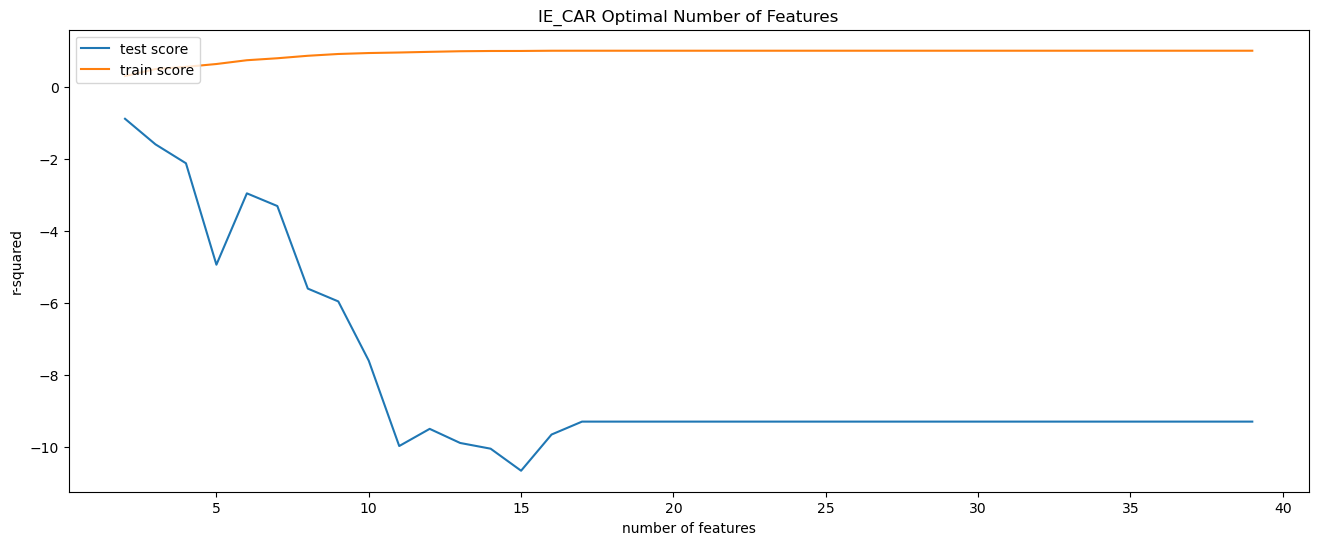

In [110]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title('IE_CAR Optimal Number of Features')
plt.legend(['test score', 'train score'], loc='upper left');

# IE_BUS Hyperparameter Tuning Using Grid Search Cross-Validation

In [111]:
X = mldf2_BUS.drop(['Year','IE_BUS'], axis=1)
# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols

In [112]:
y = mldf2_BUS.iloc[:, 1].values # Target variable

In [113]:
X

AT_BUS  BE_BUS  CH_BUS  DE_BUS  DK_BUS  EL_BUS  ES_BUS  FI_BUS  FR_BUS  \
0     1.16   -0.64   -1.75    2.47   -0.16    1.67    0.63    1.75    0.80   
1     0.52   -0.58   -1.50    1.76   -0.23    1.58    0.28    1.47    1.01   
2     0.36   -0.58   -1.37    1.53    1.25    1.64    0.13    1.40    0.40   
3     0.68   -0.45   -1.50    1.29    1.29    1.56    0.13    1.54    0.40   
4     0.52    0.13   -1.37    0.35    1.36    1.46    0.07    1.54    0.19   
5     1.00   -0.19   -1.63    0.24    1.76    1.40    0.07    1.47   -0.01   
6     0.68   -0.19   -1.88    0.12    2.05    1.22    3.12    1.40   -0.01   
7     1.00   -0.32   -1.88    0.12    1.87    1.04    2.88    1.11   -0.22   
8     1.00   -0.39    0.26    0.00    0.85    0.96    0.01    0.76   -0.42   
9     0.68   -0.45    0.13   -0.12    0.78    0.72    0.04    0.33   -0.83   
10    1.16   -0.51    0.13    0.12    0.82    0.49    0.22    0.33   -0.62   
11    1.00   -0.39    0.13   -0.12    0.82    0.28    0.28    0.19   -1.44   
12    1.00    0.06    0.01   -0.35    0.82    0.15   -0.13    0.05   -1.24   
13    1.00    0.89    0.13   -0.24   -0.05    0.00   -0.28   -0.09   -1.24   
14    1.16    1.02    0.13   -0.35   -0.12   -0.19    0.13   -0.31   -1.03   
15    0.36    0.89    0.26   -0.35   -0.12   -0.34    0.04   -0.52   -0.83   
16    0.20    1.02    0.64   -0.47   -0.67   -0.47   -0.22   -0.52   -0.62   
17    0.84    1.73    0.51   -0.59   -0.74   -0.58    0.37   -0.73   -0.22   
18   -0.44    1.79    0.13   -0.82   -0.74   -0.68    0.46   -0.66    0.19   
19   -1.88    1.09    0.01   -1.06   -0.49   -0.84    0.16   -0.73   -0.83   
20   -1.56    0.45    0.01   -1.18   -0.45   -0.77   -0.13   -0.80   -0.83   
21   -1.40    0.77    0.76    0.35   -0.59   -0.73    0.22   -0.87   -0.62   
22   -0.44    0.57    0.76    0.12   -0.70   -0.71    0.28   -0.87   -0.42   
23   -0.60    2.30    0.76    0.24   -0.70   -0.69    0.13   -0.87    1.21   
24   -0.60   -0.07    0.89    0.24   -0.70   -0.71   -0.64   -0.87    1.41   
25   -0.60   -0.39    1.01    0.47   -0.70   -0.74   -0.25   -0.95    1.41   
26   -0.60   -0.71    1.01    0.35   -0.70   -0.81   -0.28    0.62    1.62   
27   -0.44   -0.90    1.01    0.35   -0.63   -0.89   -1.47   -0.45    1.62   
28   -1.24   -0.83    1.01    0.24   -0.78   -0.92   -1.41   -0.66    1.82   
29   -0.92   -0.77    1.26    0.47   -0.92   -0.99   -1.35   -0.80    1.62   
30   -1.56   -2.18    0.89   -2.59   -1.79   -1.54   -1.88   -1.30   -0.83   
31   -2.04   -2.18    1.01   -2.59   -1.68   -1.58   -1.61   -1.94   -1.44   

    HU_BUS  IT_BUS  LU_BUS  NL_BUS  PL_BUS  PT_BUS  SE_BUS  SI_BUS  
0     1.03    0.97   -0.66    1.92    2.08    1.53    1.47    2.95  
1     0.47    0.76   -0.76    1.97    1.61    1.57    1.47    2.71  
2     0.27   -0.44   -0.76    1.23    1.40    2.34    1.35    1.55  
3     0.39   -0.87   -1.03    1.07    2.05    1.70    1.23    1.20  
4     0.51   -1.09   -1.03    1.39    1.76    1.44    1.23    1.07  
5     0.55   -0.33   -1.03    1.33    0.59    1.15    1.23    0.90  
6     1.11   -0.33   -1.03    1.28    0.50    1.00    1.35    0.79  
7     0.71   -0.33   -1.12    1.23    0.23    0.68    1.35    0.66  
8     0.59   -0.65   -1.12    1.39    0.14    0.76    1.11    0.35  
9     0.75   -0.55   -1.03    1.18    0.03    0.65    0.86    0.38  
10    1.11   -1.20   -1.31    0.06   -0.22    0.63    0.37   -0.06  
11    1.07   -0.98   -1.12    0.11   -0.35    0.44    0.01   -0.19  
12    0.99   -0.87   -0.39   -0.10   -0.56    0.12   -0.11   -0.26  
13    0.95   -0.76   -0.30   -0.37   -0.56    0.14   -0.36   -0.21  
14    0.20   -0.65   -0.11   -0.32    1.25    0.16   -0.60   -0.41  
15    0.47    0.21   -0.02   -0.37    1.04   -0.67   -0.85   -0.56  
16   -0.04    0.43   -0.11   -0.53   -1.09   -0.75   -0.85   -0.54  
17   -0.44    0.43    0.16   -0.85   -0.64   -0.71   -1.09   -0.60  
18    0.79    0.43    0.44   -0.80   -1.48   -0.73   -1.34   -0.69  
19   -0.60   -0.33    0.44   -0.85   -0.73   -0.7

In [114]:
y

array([11.5, 11.9, 12.3, 12.6, 13.6, 13.6, 13.5, 13.3, 13.3, 13.3, 16.2,
       16.1, 15.6, 15.3, 15.1, 14.6, 14.4, 14.2, 14.4, 15. , 14.5, 14.6,
       14.4, 14.1, 14.7, 13.7, 13.6, 14.3, 15. , 14.9, 12.5, 13. ])

In [115]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [116]:
# number of features
len(X_train.columns)

17

In [117]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [118]:
# cv results
cv_results1 = pd.DataFrame(model_cv.cv_results_)
cv_results1

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.01          0.00             0.00            0.00   
1            0.01          0.00             0.00            0.00   
2            0.01          0.01             0.00            0.00   
3            0.01          0.00             0.00            0.00   
4            0.01          0.00             0.00            0.00   
5            0.01          0.00             0.00            0.00   
6            0.00          0.00             0.00            0.00   
7            0.01          0.01             0.00            0.00   
8            0.00          0.00             0.00            0.00   
9            0.00          0.00             0.00            0.00   
10           0.00          0.00             0.00            0.00   
11           0.00          0.00             0.00            0.00   
12           0.00          0.00             0.00            0.00   
13           0.00          0.00             0.00            0.00   
14           0.00          0.00             0.00            0.00   
15           0.00          0.00             0.00            0.00   
16           0.00          0.00             0.00            0.00   
17           0.00          0.00             0.00            0.00   
18           0.00          0.00             0.00            0.00   
19           0.00          0.00             0.00            0.00   
20           0.00          0.00             0.00            0.00   
21           0.00          0.00             0.00            0.00   
22           0.00          0.00             0.00            0.00   
23           0.00          0.00             0.00            0.00   
24           0.00          0.00             0.00            0.00   
25           0.00          0.00             0.00            0.00   
26           0.00          0.00             0.00            0.00   
27           0.00          0.00             0.00            0.00   
28           0.00          0.00             0.00            0.00   
29           0.00          0.00             0.00            0.00   
30           0.00          0.00             0.00            0.00   
31           0.00          0.00             0.00            0.00   
32           0.00          0.00             0.00            0.00   
33           0.00          0.00             0.00            0.00   
34           0.00          0.00             0.00            0.00   
35           0.00          0.00             0.00            0.00   
36           0.00          0.00             0.00            0.00   
37           0.00          0.00             0.00            0.00   

   param_n_features_to_select                        params  \
0                           2   {'n_features_to_select': 2}   
1                           3   {'n_features_to_select': 3}   
2                           4   {'n_features_to_select': 4}   
3                           5   {'n_features_to_select': 5}   
4                           6   {'n_features_to_select': 6}   
5                           7   {'n_features_to_select': 7}   
6                           8   {'n_features_to_select': 8}   
7                           9   {'n_features_to_select': 9}   
8                          10  {'n_features_to_select': 10}   
9                          11  {'n_features_to_select': 11}   
10                         12  {'n_features_to_select': 12}   
11                         13  {'n_features_to_select': 13}   
12                         14  {'n_features_to_select': 14}   
13                         15  {'n_features_to_select': 15}   
14                         16  {'n_features_to_select': 16}   
15                         17  {'n_features_to_select': 17}   
16                         18  {'n_features_to_select': 18}   
17                         19  {'n_features_to_select': 19}   
18                         20  {'n_features_to_select': 20}   
19                         21  {'n_features_to_select': 21}   
20                         2

In [119]:
feature1 = cv_results1[cv_results1['mean_test_score'] == cv_results1['mean_test_score'].max()]
feature1 = feature1['param_n_features_to_select'].values[0]

accuracy1 = cv_results1[cv_results1['rank_test_score'] == 1]
accuracy1 = accuracy1['mean_test_score'].values[0]

print(f"IE_BUS number feature selection is: {feature1}", end=' ')
print(f"and its accuracy: {accuracy1}")

IE_BUS number feature selection is: 2 and its accuracy: 0.06156748515057642


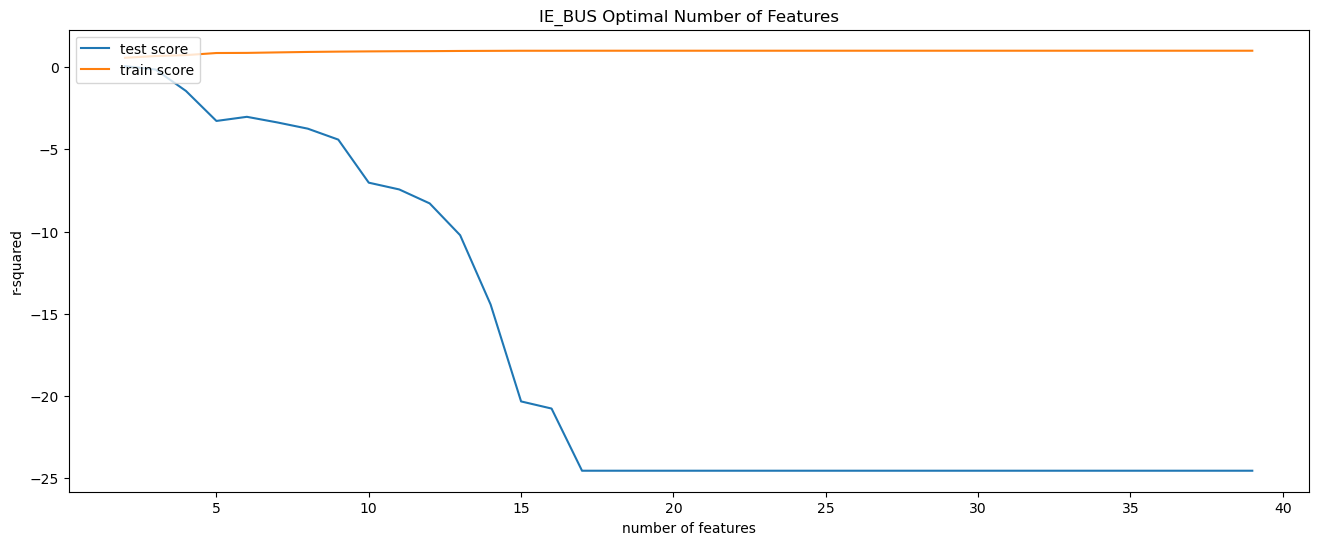

In [120]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results1["param_n_features_to_select"], cv_results1["mean_test_score"])
plt.plot(cv_results1["param_n_features_to_select"], cv_results1["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title('IE_BUS Optimal Number of Features')
plt.legend(['test score', 'train score'], loc='upper left');

# IE_TRN Hyperparameter Tuning Using Grid Search Cross-Validation

In [121]:
X = mldf2_TRN.drop(['Year','IE_TRN'], axis=1)
# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols

In [122]:
y = mldf2_TRN.iloc[:, 1].values # Target variable

In [123]:
X

AT_TRN  BE_TRN  CH_TRN  DE_TRN  DK_TRN  EL_TRN  ES_TRN  FI_TRN  FR_TRN  \
0     0.62   -0.84   -0.96   -2.84   -1.67    2.21    1.07    0.50    0.34   
1     1.01   -0.84   -0.61   -0.95   -1.91    2.21   -0.04    0.27   -0.28   
2     1.09   -0.98   -0.79   -1.08   -2.07    2.10    0.16   -0.20   -0.53   
3     0.77   -1.12   -0.52   -0.45   -0.30    1.40   -0.45   -0.20   -1.27   
4     0.38   -1.53   -0.08   -0.95   -0.21    0.58   -0.76   -0.20   -1.52   
5     0.69   -1.26   -1.09   -0.33   -0.54    0.82   -0.86    0.27   -1.89   
6     0.62   -1.12   -1.09   -0.20   -0.78    0.93    2.50    0.50   -1.27   
7    -0.80   -1.12   -1.09   -0.07   -0.46    1.05    2.70    0.50   -1.15   
8    -1.04   -1.12   -1.23   -0.20   -0.05    0.35   -0.66    0.27   -1.02   
9    -1.20   -0.98   -1.14   -0.20   -0.21    0.35   -0.76    0.27   -1.02   
10   -1.04   -0.57   -1.18    0.05    0.11    0.58   -0.45    0.04   -0.53   
11   -1.12   -0.43   -0.96   -0.07    0.43    0.24   -0.35   -0.66   -0.65   
12   -1.12   -0.29   -0.70   -0.70    0.51    0.24   -0.66   -0.66   -0.41   
13   -1.28   -0.29   -0.61   -0.58    0.75   -0.11   -0.76   -0.89   -0.78   
14   -1.28    0.53   -0.48   -0.20    0.75   -0.11   -0.86   -0.89   -0.41   
15   -1.04   -0.57   -0.04   -0.20    0.92    0.00   -0.76   -0.66    0.09   
16   -0.88   -0.15    0.05    0.18   -0.21   -0.11   -0.66   -0.66    0.46   
17   -0.80   -0.15    0.27    0.18   -0.05   -0.11   -0.86   -0.20    0.71   
18   -0.01    0.67    0.32    0.55    0.03   -0.46   -0.35    0.73    1.33   
19    0.06    0.81    0.45    0.30    0.92   -0.58   -0.45    0.04    0.46   
20   -0.01    1.08    0.54    0.43    1.16   -0.69   -0.45    0.27    0.83   
21    0.30    1.36    1.42    0.93    1.32   -1.04   -0.25   -0.20    1.20   
22    0.54    0.26    1.24    1.43    1.48   -1.16   -0.25    0.50    0.58   
23    0.93    0.40    1.29    0.80    1.56   -0.93    0.26    0.50    1.33   
24    0.85    0.95    1.42    0.80    1.08   -0.93    0.87   -0.20    0.95   
25    0.77    1.22    1.46    0.68    0.75   -0.81    0.87    0.50    1.08   
26    0.77    1.22    1.51    0.93    0.35   -0.81    0.77    1.20    0.95   
27    0.69    1.50    1.42    1.31    0.19   -0.93    1.18    0.73    1.33   
28    1.88    1.77    1.29    1.56    0.03   -0.93    1.28    1.43    0.95   
29    2.19    2.05    1.60    2.06   -0.13   -0.81    1.28    2.59    1.57   
30   -1.51    0.26   -0.92   -1.71   -1.99   -1.28   -1.77   -2.99   -1.52   
31   -1.04   -0.71   -0.79   -1.46   -1.75   -1.28   -0.55   -2.52    0.09   

    HU_TRN  IT_TRN  LU_TRN  NL_TRN  PL_TRN  PT_TRN  SE_TRN  SI_TRN  
0     1.69    1.84   -0.20   -1.94    3.51    2.59   -1.04    4.46  
1     1.02    1.49   -0.02   -0.38    2.48    2.49   -1.41    1.81  
2     0.97    0.44    0.88   -0.15    1.72    2.01   -1.47    0.37  
3     0.59    0.09    0.88   -0.77    1.27    1.74   -1.16    0.48  
4     0.49    0.27    1.41   -1.47    0.90    1.37   -1.16    0.37  
5     0.40    0.09    1.23   -1.40    0.89    1.00   -0.98    0.15  
6     0.30    0.09    0.88   -1.32    0.15    0.58   -0.92    0.04  
7     0.35   -0.43    1.05   -1.08    0.06    0.47   -0.92   -0.07  
8     0.49   -1.13    1.05   -0.23    0.01    0.31   -0.86    0.04  
9     0.83   -0.78    1.41   -0.31    0.08   -0.00   -0.67   -0.18  
10    0.83   -0.08    1.05    0.00    0.22   -0.32   -0.43    0.26  
11    1.07   -0.08    1.05    0.00    0.03   -0.37   -0.19    0.26  
12    1.30   -0.26   -1.09   -0.07   -0.16   -0.48   -0.25    0.37  
13    1.07   -0.43   -1.44   -0.77   -0.28   -0.69   -0.31    0.37  
14    1.11   -0.43   -1.62   -0.77   -0.34   -0.74   -0.43    0.04  
15    0.68    0.27   -1.62   -0.38   -0.39   -0.64   -0.31    0.04  
16    0.40    0.44   -1.09    0.00   -0.62   -0.64    0.06    0.04  
17   -0.08    0.27   -0.73    0.16   -0.20   -0.59    0.30   -0.07  
18   -0.51    0.27   -0.37    0.24   -0.74   -0.48    0.73    0.04  
19   -0.46   -0.61   -0.55    0.32   -0.91   -0.4

In [124]:
y

array([3.6, 3.7, 3.5, 3.6, 3.4, 3.4, 3.3, 3.4, 3.3, 3.3, 3.2, 3.3, 3.5,
       3.3, 3. , 3.3, 3.3, 3.4, 3.3, 2.8, 2.9, 2.9, 2.8, 2.7, 3. , 3.1,
       3. , 3.1, 3.3, 3.3, 1.4, 1.4])

In [125]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [126]:
# number of features
len(X_train.columns)

17

In [127]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [128]:
# cv results
cv_results2 = pd.DataFrame(model_cv.cv_results_)
cv_results2

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.01          0.00             0.00            0.00   
1            0.01          0.00             0.00            0.00   
2            0.01          0.01             0.00            0.00   
3            0.01          0.00             0.00            0.00   
4            0.01          0.01             0.00            0.00   
5            0.01          0.01             0.00            0.00   
6            0.01          0.01             0.00            0.00   
7            0.01          0.01             0.00            0.00   
8            0.00          0.01             0.00            0.01   
9            0.01          0.01             0.00            0.00   
10           0.01          0.00             0.00            0.00   
11           0.00          0.00             0.00            0.00   
12           0.00          0.00             0.00            0.00   
13           0.01          0.00             0.00            0.00   
14           0.00          0.00             0.00            0.00   
15           0.00          0.00             0.00            0.00   
16           0.00          0.00             0.00            0.00   
17           0.00          0.00             0.00            0.00   
18           0.00          0.00             0.00            0.00   
19           0.00          0.00             0.00            0.00   
20           0.00          0.00             0.00            0.00   
21           0.00          0.00             0.00            0.00   
22           0.00          0.00             0.00            0.00   
23           0.00          0.00             0.00            0.00   
24           0.00          0.00             0.00            0.00   
25           0.00          0.00             0.00            0.00   
26           0.00          0.00             0.00            0.00   
27           0.00          0.00             0.00            0.00   
28           0.00          0.00             0.00            0.00   
29           0.00          0.00             0.00            0.00   
30           0.00          0.00             0.00            0.00   
31           0.00          0.00             0.00            0.00   
32           0.00          0.00             0.00            0.00   
33           0.00          0.00             0.00            0.00   
34           0.00          0.00             0.00            0.00   
35           0.00          0.00             0.00            0.00   
36           0.00          0.00             0.00            0.00   
37           0.00          0.00             0.00            0.00   

   param_n_features_to_select                        params  \
0                           2   {'n_features_to_select': 2}   
1                           3   {'n_features_to_select': 3}   
2                           4   {'n_features_to_select': 4}   
3                           5   {'n_features_to_select': 5}   
4                           6   {'n_features_to_select': 6}   
5                           7   {'n_features_to_select': 7}   
6                           8   {'n_features_to_select': 8}   
7                           9   {'n_features_to_select': 9}   
8                          10  {'n_features_to_select': 10}   
9                          11  {'n_features_to_select': 11}   
10                         12  {'n_features_to_select': 12}   
11                         13  {'n_features_to_select': 13}   
12                         14  {'n_features_to_select': 14}   
13                         15  {'n_features_to_select': 15}   
14                         16  {'n_features_to_select': 16}   
15                         17  {'n_features_to_select': 17}   
16                         18  {'n_features_to_select': 18}   
17                         19  {'n_features_to_select': 19}   
18                         20  {'n_features_to_select': 20}   
19                         21  {'n_features_to_select': 21}   
20                         2

In [129]:
feature2 = cv_results2[cv_results2['mean_test_score'] == cv_results2['mean_test_score'].max()]
feature2 = feature2['param_n_features_to_select'].values[0]

accuracy2 = cv_results2[cv_results2['rank_test_score'] == 1]
accuracy2 = accuracy2['mean_test_score'].values[0]

print(f"IE_TRN number feature selection is: {feature2}", end=' ')
print(f"and its accuracy: {accuracy2}")

IE_TRN number feature selection is: 2 and its accuracy: -0.7044103645876985


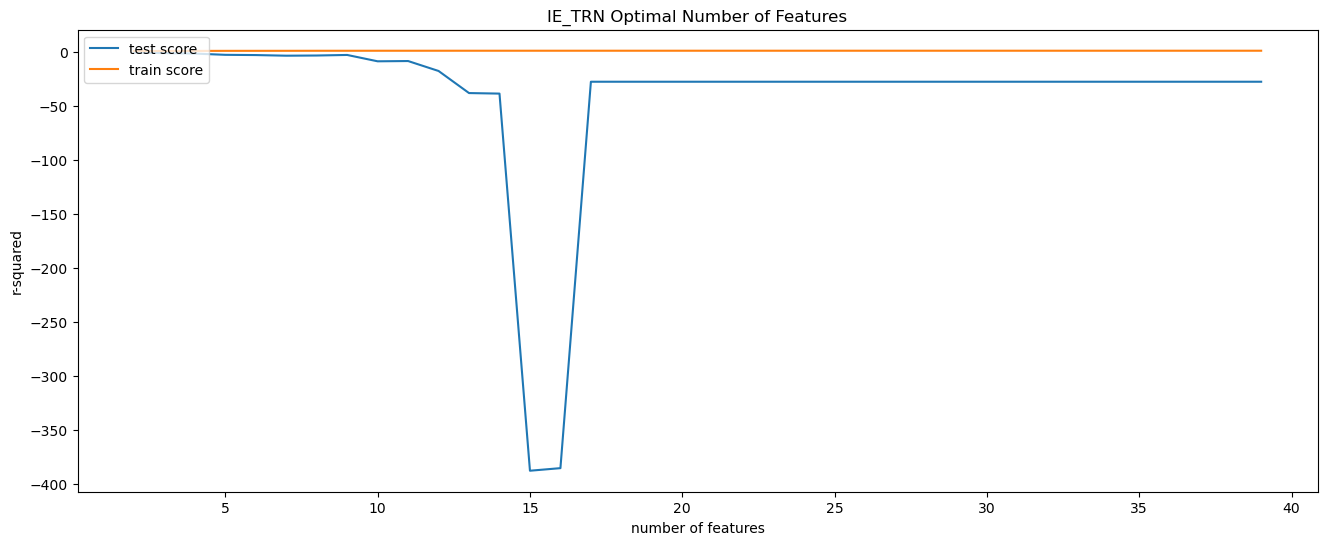

In [130]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results2["param_n_features_to_select"], cv_results2["mean_test_score"])
plt.plot(cv_results2["param_n_features_to_select"], cv_results2["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title('IE_TRN Optimal Number of Features')
plt.legend(['test score', 'train score'], loc='upper left');

Very poor results, same as we did previously for the supervised models, we are going to enrich our data to see if we can improve accuracy. Breaking down years by quarters it will add more data to our model.

In [324]:
# Creating figure x

Output3 = {
    'Country_Vehicle': ['IE_CAR', 'IE_BUS', 'IE_TRN'],
    'Number_of_Features': [2, 2, 2],
    'Accuracy (%)': [-88.85, 6.15, -70.44]
}

sup_ML_Results3 = pd.DataFrame(Output3)
sup_ML_Results3

Country_Vehicle  Number_of_Features  Accuracy (%)
0          IE_CAR                   2        -88.85
1          IE_BUS                   2          6.15
2          IE_TRN                   2        -70.44

# Enriching dataset:

In [132]:
mldf2a.head()

Year  AT_BUS  AT_CAR  AT_TRN  BE_BUS  BE_CAR  BE_TRN  CH_BUS  CH_CAR  \
0  1990   11.00   77.10   11.90   10.60   83.30    6.10    3.70   82.10   
1  1991   10.60   77.00   12.40   10.70   83.30    6.10    3.90   81.10   
2  1992   10.50   77.00   12.50   10.70   83.30    6.00    4.00   81.40   
3  1993   10.70   77.20   12.10   10.90   83.30    5.90    3.90   80.90   
4  1994   10.60   77.80   11.60   11.80   82.60    5.60    4.00   79.80   

   CH_TRN  ...  PL_TRN  PT_BUS  PT_CAR  PT_TRN  SE_BUS  SE_CAR  SE_TRN  \
0   14.20  ...   30.50   18.40   71.50   10.10    9.50   84.10    6.50   
1   15.00  ...   24.60   18.60   71.40    9.90    9.50   84.70    5.90   
2   14.60  ...   20.30   22.70   68.20    9.00    9.40   84.80    5.80   
3   15.20  ...   17.70   19.30   72.20    8.50    9.30   84.40    6.30   
4   16.20  ...   15.60   17.90   74.30    7.80    9.30   84.40    6.30   

   SI_BUS  SI_CAR  SI_TRN  
0   30.60   62.70    6.70  
1   29.30   66.40    4.30  
2   23.00   73.90    3.00  
3   21.10   75.80    3.10  
4   20.40   76.60    3.00  

[5 rows x 55 columns]

In [133]:
def addQuaUnsuMl(mldf2a, weights):
    # Create a list to store the transformed data
    transformed_rows = []

    for index, row in mldf2a.iterrows():
        year = row['Year']

        # Iterate through each country and mode of transport
        for column_name in mldf2a.columns[1:]:  # Exclude the 'Year' column
            country, mode = column_name.split('_')

            # Calculate values for each quarter based on weights
            at_value = row[column_name]
            values = [round(at_value * weight, 2) for weight in weights]

            # Add rows to the transformed list
            for quarter, value in enumerate(values, start=1):
                new_column_name = f'{country}_{mode}'
                transformed_rows.append({'Year': year, 'Quarter': quarter, new_column_name: value})

    # Create the transformed DataFrame
    transformed_df = pd.DataFrame(transformed_rows)

    # Group by 'Year' and 'Quarter' and sum the values
    transformed_df = transformed_df.groupby(['Year', 'Quarter']).sum().reset_index()

    return transformed_df

weights = [0.23, 0.27, 0.24, 0.26]

mldf2a = addQuaUnsuMl(mldf2a, weights)
mldf2a

Year  Quarter  AT_BUS  AT_CAR  AT_TRN  BE_BUS  BE_CAR  BE_TRN  CH_BUS  \
0    1990        1    2.53   17.73    2.74    2.44   19.16    1.40    0.85   
1    1990        2    2.97   20.82    3.21    2.86   22.49    1.65    1.00   
2    1990        3    2.64   18.50    2.86    2.54   19.99    1.46    0.89   
3    1990        4    2.86   20.05    3.09    2.76   21.66    1.59    0.96   
4    1991        1    2.44   17.71    2.85    2.46   19.16    1.40    0.90   
..    ...      ...     ...     ...     ...     ...     ...     ...     ...   
123  2020        4    2.42   21.19    2.39    2.13   22.10    1.79    1.51   
124  2021        1    2.07   18.68    2.25    1.89   19.69    1.43    1.36   
125  2021        2    2.43   21.92    2.65    2.21   23.11    1.67    1.59   
126  2021        3    2.16   19.49    2.35    1.97   20.54    1.49    1.42   
127  2021        4    2.34   21.11    2.55    2.13   22.26    1.61    1.53   

     CH_CAR  ...  PL_TRN  PT_BUS  PT_CAR  PT_TRN  SE_BUS  SE_CAR  SE_TRN  \
0     18.88  ...    7.02    4.23   16.45    2.32    2.19   19.34    1.50   
1     22.17  ...    8.24    4.97   19.30    2.73    2.57   22.71    1.76   
2     19.70  ...    7.32    4.42   17.16    2.42    2.28   20.18    1.56   
3     21.35  ...    7.93    4.78   18.59    2.63    2.47   21.87    1.69   
4     18.65  ...    5.66    4.28   16.42    2.28    2.19   19.48    1.36   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
123   20.77  ...    1.27    1.09   24.18    0.73    2.18   21.84    1.98   
124   18.29  ...    1.36    1.31   21.00    0.67    1.91   19.34    1.73   
125   21.46  ...    1.59    1.54   24.65    0.78    2.24   22.71    2.03   
126   19.08  ...    1.42    1.37   21.91    0.70    1.99   20.18    1.80   
127   20.67  ...    1.53    1.48   23.74    0.75    2.16   21.87    1.95   

     SI_BUS  SI_CAR  SI_TRN  
0      7.04   14.42    1.54  
1      8.26   16.93    1.81  
2      7.34   15.05    1.61  
3      7.96   16.30    1.74  
4      6.74   15.27    0.99  
..      ...     ...     ...  
123    1.95   23.71    0.34  
124    1.89   20.70    0.41  
125    2.21   24.30    0.49  
126    1.97   21.60    0.43  
127    2.13   23.40    0.47  

[128 rows x 56 columns]

In [134]:
# Filter columns for CAR
mldf2a_CAR = mldf2a.filter(['Year', 'Quarter'] + [col for col in mldf2a.columns if '_CAR' in col])
# Move 'IE_CAR' column to the thrid position
mldf2a_CAR.insert(2, 'IE_CAR', mldf2a_CAR.pop('IE_CAR'))
mldf2_CAR1 = mldf2a_CAR.copy() # Dataset for PCA and Clustering

# Filter columns for BUS
mldf2a_BUS = mldf2a.filter(['Year', 'Quarter'] + [col for col in mldf2a.columns if '_BUS' in col])
# Move 'IE_BUS' column to the thrid position
mldf2a_BUS.insert(2, 'IE_BUS', mldf2a_BUS.pop('IE_BUS'))
mldf2_BUS1 = mldf2a_BUS.copy() # Dataset for PCA and Clustering

# Filter columns for TRN
mldf2a_TRN = mldf2a.filter(['Year', 'Quarter'] + [col for col in mldf2a.columns if '_TRN' in col])
# Move 'IE_TRN' column to the thrid position
mldf2a_TRN.insert(2, 'IE_TRN', mldf2a_TRN.pop('IE_TRN'))
mldf2_TRN1 = mldf2a_TRN.copy() # Dataset for PCA and Clustering

In [135]:
mldf2a_CAR.head(4)

Year  Quarter  IE_CAR  AT_CAR  BE_CAR  CH_CAR  DE_CAR  DK_CAR  EL_CAR  \
0  1990        1   19.53   17.73   19.16   18.88   19.64   18.95   14.72   
1  1990        2   22.92   20.82   22.49   22.17   23.06   22.25   17.28   
2  1990        3   20.38   18.50   19.99   19.70   20.50   19.78   15.36   
3  1990        4   22.07   20.05   21.66   21.35   22.20   21.42   16.64   

   ES_CAR  FI_CAR  FR_CAR  HU_CAR  IT_CAR  LU_CAR  NL_CAR  PL_CAR  PT_CAR  \
0   17.96   18.68   19.50   13.92   18.45   19.62   19.57    9.50   16.45   
1   21.09   21.92   22.90   16.34   21.65   23.03   22.98   11.15   19.30   
2   18.74   19.49   20.35   14.52   19.25   20.47   20.42    9.91   17.16   
3   20.31   21.11   22.05   15.73   20.85   22.18   22.13   10.74   18.59   

   SE_CAR  SI_CAR  
0   19.34   14.42  
1   22.71   16.93  
2   20.18   15.05  
3   21.87   16.30

In [136]:
mldf2a_BUS.head(4)

Year  Quarter  IE_BUS  AT_BUS  BE_BUS  CH_BUS  DE_BUS  DK_BUS  EL_BUS  \
0  1990        1    2.65    2.53    2.44    0.85    2.09    2.60    7.45   
1  1990        2    3.11    2.97    2.86    1.00    2.46    3.05    8.75   
2  1990        3    2.76    2.64    2.54    0.89    2.18    2.71    7.78   
3  1990        4    2.99    2.86    2.76    0.96    2.37    2.94    8.42   

   ES_BUS  FI_BUS  FR_BUS  HU_BUS  IT_BUS  LU_BUS  NL_BUS  PL_BUS  PT_BUS  \
0    3.43    3.10    1.38    5.70    2.97    2.35    1.86    6.49    4.23   
1    4.02    3.65    1.62    6.70    3.48    2.75    2.19    7.61    4.97   
2    3.58    3.24    1.44    5.95    3.10    2.45    1.94    6.77    4.42   
3    3.87    3.51    1.56    6.45    3.35    2.65    2.11    7.33    4.78   

   SE_BUS  SI_BUS  
0    2.19    7.04  
1    2.57    8.26  
2    2.28    7.34  
3    2.47    7.96

In [137]:
mldf2a_TRN.head(4)

Year  Quarter  IE_TRN  AT_TRN  BE_TRN  CH_TRN  DE_TRN  DK_TRN  EL_TRN  \
0  1990        1    0.83    2.74    1.40    3.27    1.24    1.45    0.83   
1  1990        2    0.97    3.21    1.65    3.83    1.46    1.70    0.97   
2  1990        3    0.86    2.86    1.46    3.41    1.30    1.51    0.86   
3  1990        4    0.94    3.09    1.59    3.69    1.40    1.64    0.94   

   ES_TRN  FI_TRN  FR_TRN  HU_TRN  IT_TRN  LU_TRN  NL_TRN  PL_TRN  PT_TRN  \
0    1.59    1.22    2.14    3.38    1.59    1.01    1.59    7.02    2.32   
1    1.86    1.43    2.51    3.97    1.86    1.19    1.86    8.24    2.73   
2    1.66    1.27    2.23    3.53    1.66    1.06    1.66    7.32    2.42   
3    1.79    1.38    2.42    3.82    1.79    1.14    1.79    7.93    2.63   

   SE_TRN  SI_TRN  
0    1.50    1.54  
1    1.76    1.81  
2    1.56    1.61  
3    1.69    1.74

# IE_CAR Hyperparameter Tuning Using Grid Search Cross-Validation

In [138]:
X = mldf2a_CAR.drop(['Year', 'Quarter', 'IE_CAR'], axis=1)
# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols

In [139]:
y = mldf2a_CAR.iloc[:, 2].values # Target variable

In [140]:
X

AT_CAR  BE_CAR  CH_CAR  DE_CAR  DK_CAR  EL_CAR  ES_CAR  FI_CAR  FR_CAR  \
0     -1.50   -0.92   -0.53   -1.23   -0.71   -2.04   -1.48   -1.66   -1.34   
1      0.91    1.51    1.77    1.25    1.56   -0.84    0.46    0.69    1.13   
2     -0.90   -0.32    0.05   -0.61   -0.14   -1.74   -1.00   -1.07   -0.72   
3      0.31    0.90    1.20    0.63    0.99   -1.14   -0.02    0.10    0.51   
4     -1.52   -0.92   -0.69   -1.36   -0.62   -1.98   -1.15   -1.58   -1.29   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
123    1.20    1.22    0.79    1.27    1.87    1.65    1.81    1.19    0.92   
124   -0.76   -0.54   -0.94   -0.66   -0.03    0.46   -0.15   -0.58   -1.13   
125    1.77    1.96    1.28    1.91    2.36    2.10    2.01    1.96    1.36   
126   -0.13    0.08   -0.39   -0.02    0.57    0.87    0.39    0.06   -0.51   
127    1.14    1.34    0.72    1.27    1.76    1.69    1.47    1.32    0.74   

     HU_CAR  IT_CAR  LU_CAR  NL_CAR  PL_CAR  PT_CAR  SE_CAR  SI_CAR  
0     -1.77   -1.56   -1.12   -1.39   -2.99   -2.12   -1.13   -3.09  
1     -0.20    0.83    1.38    1.03   -2.43   -0.83    1.35   -1.85  
2     -1.39   -0.96   -0.49   -0.79   -2.85   -1.80   -0.51   -2.78  
3     -0.60    0.23    0.76    0.43   -2.57   -1.15    0.73   -2.16  
4     -1.37   -1.49   -1.10   -1.74   -2.32   -2.13   -1.02   -2.67  
..      ...     ...     ...     ...     ...     ...     ...     ...  
123    2.49    1.34    1.01    1.35    1.56    1.38    0.71    1.49  
124    1.03   -1.12   -0.95   -0.69    0.55   -0.06   -1.13    0.01  
125    3.09    1.36    1.58    1.85    1.74    1.59    1.35    1.79  
126    1.54   -0.50   -0.32   -0.05    0.85    0.35   -0.51    0.45  
127    2.58    0.74    0.95    1.21    1.44    1.18    0.73    1.34  

[128 rows x 17 columns]

In [141]:
y

array([19.53, 22.92, 20.38, 22.07, 19.39, 22.76, 20.23, 21.92, 19.37,
       22.73, 20.21, 21.89, 19.27, 22.63, 20.11, 21.79, 19.09, 22.41,
       19.92, 21.58, 19.09, 22.41, 19.92, 21.58, 19.16, 22.49, 19.99,
       21.66, 19.16, 22.49, 19.99, 21.66, 19.18, 22.52, 20.02, 21.68,
       19.18, 22.52, 20.02, 21.68, 18.54, 21.76, 19.34, 20.96, 18.52,
       21.74, 19.32, 20.93, 18.63, 21.87, 19.44, 21.06, 18.72, 21.98,
       19.54, 21.16, 18.84, 22.11, 19.66, 21.29, 18.88, 22.17, 19.7 ,
       21.35, 18.93, 22.22, 19.75, 21.4 , 18.93, 22.22, 19.75, 21.4 ,
       18.93, 22.22, 19.75, 21.4 , 18.88, 22.17, 19.7 , 21.35, 19.  ,
       22.3 , 19.82, 21.48, 19.  , 22.3 , 19.82, 21.48, 19.04, 22.36,
       19.87, 21.53, 19.14, 22.46, 19.97, 21.63, 18.93, 22.22, 19.75,
       21.4 , 19.16, 22.49, 19.99, 21.66, 19.18, 22.52, 20.02, 21.68,
       19.  , 22.3 , 19.82, 21.48, 18.79, 22.06, 19.61, 21.24, 18.81,
       22.09, 19.63, 21.27, 19.8 , 23.25, 20.66, 22.39, 19.71, 23.14,
       20.57, 22.28]

In [142]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [143]:
# number of features
len(X_train.columns)

17

In [144]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [145]:
# cv results
cv_results3 = pd.DataFrame(model_cv.cv_results_)
cv_results3

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.01          0.00             0.00            0.00   
1            0.01          0.00             0.00            0.00   
2            0.01          0.01             0.00            0.00   
3            0.01          0.01             0.00            0.00   
4            0.01          0.01             0.00            0.00   
5            0.01          0.01             0.00            0.01   
6            0.00          0.01             0.01            0.01   
7            0.01          0.01             0.00            0.00   
8            0.01          0.00             0.00            0.00   
9            0.01          0.00             0.00            0.00   
10           0.00          0.00             0.00            0.00   
11           0.00          0.00             0.00            0.00   
12           0.00          0.00             0.00            0.00   
13           0.00          0.00             0.00            0.00   
14           0.01          0.00             0.00            0.00   
15           0.00          0.00             0.00            0.00   
16           0.00          0.00             0.00            0.00   
17           0.00          0.00             0.00            0.00   
18           0.00          0.00             0.00            0.00   
19           0.00          0.00             0.00            0.00   
20           0.00          0.00             0.00            0.00   
21           0.00          0.00             0.00            0.00   
22           0.00          0.00             0.00            0.00   
23           0.00          0.00             0.00            0.00   
24           0.00          0.00             0.00            0.00   
25           0.00          0.00             0.00            0.00   
26           0.00          0.00             0.00            0.00   
27           0.00          0.00             0.00            0.00   
28           0.00          0.00             0.00            0.00   
29           0.00          0.00             0.00            0.00   
30           0.00          0.00             0.00            0.00   
31           0.00          0.00             0.00            0.00   
32           0.00          0.00             0.00            0.00   
33           0.00          0.00             0.00            0.00   
34           0.00          0.00             0.00            0.00   
35           0.00          0.00             0.00            0.00   
36           0.00          0.00             0.00            0.00   
37           0.00          0.00             0.00            0.00   

   param_n_features_to_select                        params  \
0                           2   {'n_features_to_select': 2}   
1                           3   {'n_features_to_select': 3}   
2                           4   {'n_features_to_select': 4}   
3                           5   {'n_features_to_select': 5}   
4                           6   {'n_features_to_select': 6}   
5                           7   {'n_features_to_select': 7}   
6                           8   {'n_features_to_select': 8}   
7                           9   {'n_features_to_select': 9}   
8                          10  {'n_features_to_select': 10}   
9                          11  {'n_features_to_select': 11}   
10                         12  {'n_features_to_select': 12}   
11                         13  {'n_features_to_select': 13}   
12                         14  {'n_features_to_select': 14}   
13                         15  {'n_features_to_select': 15}   
14                         16  {'n_features_to_select': 16}   
15                         17  {'n_features_to_select': 17}   
16                         18  {'n_features_to_select': 18}   
17                         19  {'n_features_to_select': 19}   
18                         20  {'n_features_to_select': 20}   
19                         21  {'n_features_to_select': 21}   
20                         2

In [146]:
feature3 = cv_results3[cv_results3['mean_test_score'] == cv_results3['mean_test_score'].max()]
feature3 = feature3['param_n_features_to_select'].values[0]

accuracy3 = cv_results3[cv_results3['rank_test_score'] == 1]
accuracy3 = accuracy3['mean_test_score'].values[0]

print(f"IE_CAR Enriched number feature selection is: {feature3}", end=' ')
print(f"and its accuracy: {accuracy3}")

IE_CAR Enriched number feature selection is: 16 and its accuracy: 0.9867666815861831


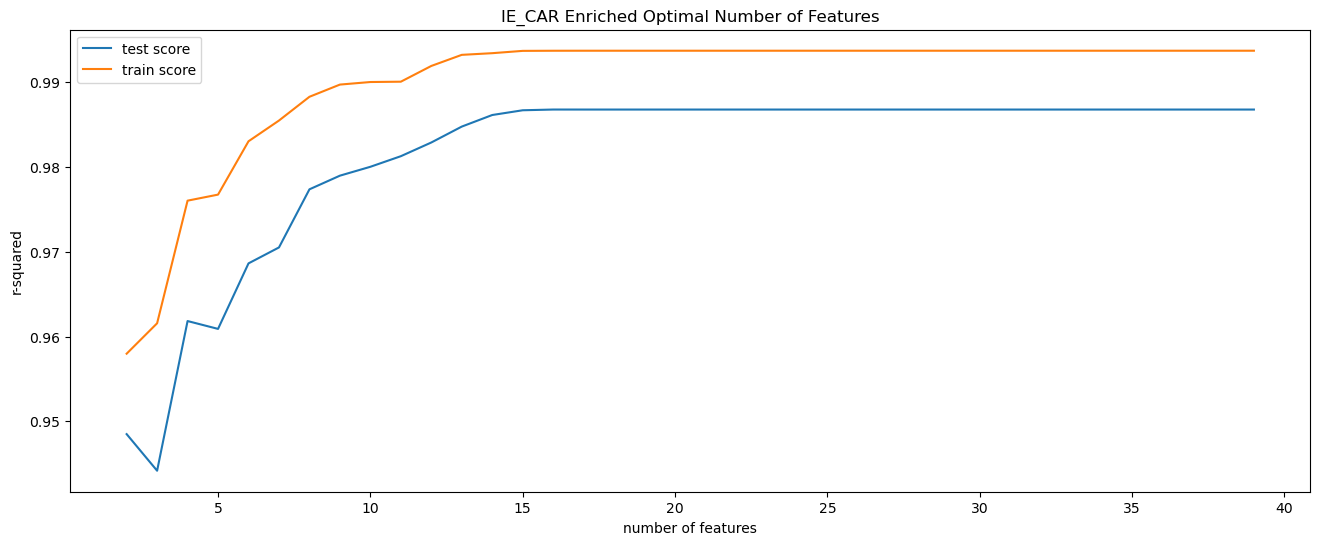

In [147]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results3["param_n_features_to_select"], cv_results3["mean_test_score"])
plt.plot(cv_results3["param_n_features_to_select"], cv_results3["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title('IE_CAR Enriched Optimal Number of Features')
plt.legend(['test score', 'train score'], loc='upper left');

# IE_BUS Hyperparameter Tuning Using Grid Search Cross-Validation

In [148]:
X = mldf2a_BUS.drop(['Year', 'Quarter', 'IE_BUS'], axis=1)
# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols

In [149]:
y = mldf2a_BUS.iloc[:, 2].values # Target variable

In [150]:
X

AT_BUS  BE_BUS  CH_BUS  DE_BUS  DK_BUS  EL_BUS  ES_BUS  FI_BUS  FR_BUS  \
0     -0.17   -1.07   -1.97    1.42   -0.47    1.22    0.28    0.87   -0.14   
1      1.79   -0.09   -1.27    2.96    0.16    2.04    0.95    2.27    1.44   
2      0.32   -0.84   -1.79    1.79   -0.31    1.43    0.45    1.22    0.25   
3      1.30   -0.33   -1.46    2.58    0.01    1.83    0.78    1.91    1.04   
4     -0.57   -1.02   -1.74    0.87   -0.54    1.13   -0.04    0.64   -0.01   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
123   -0.66   -1.79    1.10   -2.08   -1.63   -1.41   -1.76   -0.93   -0.34   
124   -2.22   -2.34    0.40   -2.71   -1.82   -1.70   -1.73   -2.15   -1.79   
125   -0.62   -1.60    1.47   -1.87   -1.42   -1.39   -1.40   -1.32   -0.54   
126   -1.82   -2.16    0.68   -2.50   -1.72   -1.62   -1.65   -1.95   -1.46   
127   -1.02   -1.79    1.19   -2.08   -1.51   -1.46   -1.48   -1.52   -0.87   

     HU_BUS  IT_BUS  LU_BUS  NL_BUS  PL_BUS  PT_BUS  SE_BUS  SI_BUS  
0      0.20   -0.10   -1.18    1.55    1.65    1.24    0.48    2.46  
1      1.59    1.60    0.06    2.24    2.44    1.79    2.04    3.35  
2      0.55    0.33   -0.87    1.72    1.84    1.38    0.85    2.68  
3      1.24    1.17   -0.25    2.07    2.24    1.65    1.63    3.13  
4     -0.24   -0.27   -1.27    1.61    1.22    1.28    0.48    2.24  
..      ...     ...     ...     ...     ...     ...     ...     ...  
123   -2.17   -1.17   -0.31   -1.21   -1.56   -1.10    0.44   -1.24  
124   -3.13   -0.20   -1.18   -1.25   -1.67   -0.94   -0.67   -1.28  
125   -2.34    1.54    0.06   -1.06   -1.45   -0.77    0.68   -1.05  
126   -2.93    0.23   -0.87   -1.21   -1.62   -0.89   -0.34   -1.23  
127   -2.53    1.10   -0.25   -1.10   -1.50   -0.81    0.35   -1.11  

[128 rows x 17 columns]

In [151]:
y

array([2.65, 3.11, 2.76, 2.99, 2.74, 3.21, 2.86, 3.09, 2.83, 3.32, 2.95,
       3.2 , 2.9 , 3.4 , 3.02, 3.28, 3.13, 3.67, 3.26, 3.54, 3.13, 3.67,
       3.26, 3.54, 3.1 , 3.65, 3.24, 3.51, 3.06, 3.59, 3.19, 3.46, 3.06,
       3.59, 3.19, 3.46, 3.06, 3.59, 3.19, 3.46, 3.73, 4.37, 3.89, 4.21,
       3.7 , 4.35, 3.86, 4.19, 3.59, 4.21, 3.74, 4.06, 3.52, 4.13, 3.67,
       3.98, 3.47, 4.08, 3.62, 3.93, 3.36, 3.94, 3.5 , 3.8 , 3.31, 3.89,
       3.46, 3.74, 3.27, 3.83, 3.41, 3.69, 3.31, 3.89, 3.46, 3.74, 3.45,
       4.05, 3.6 , 3.9 , 3.33, 3.92, 3.48, 3.77, 3.36, 3.94, 3.5 , 3.8 ,
       3.31, 3.89, 3.46, 3.74, 3.24, 3.81, 3.38, 3.67, 3.38, 3.97, 3.53,
       3.82, 3.15, 3.7 , 3.29, 3.56, 3.13, 3.67, 3.26, 3.54, 3.29, 3.86,
       3.43, 3.72, 3.45, 4.05, 3.6 , 3.9 , 3.43, 4.02, 3.58, 3.87, 2.88,
       3.38, 3.  , 3.25, 2.99, 3.51, 3.12, 3.38])

In [152]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [153]:
# number of features
len(X_train.columns)

17

In [154]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [155]:
# cv results
cv_results4 = pd.DataFrame(model_cv.cv_results_)
cv_results4

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.01          0.00             0.00            0.00   
1            0.01          0.00             0.00            0.00   
2            0.01          0.00             0.00            0.00   
3            0.01          0.00             0.00            0.00   
4            0.01          0.00             0.00            0.00   
5            0.01          0.00             0.00            0.00   
6            0.01          0.00             0.00            0.00   
7            0.01          0.00             0.00            0.00   
8            0.01          0.00             0.00            0.00   
9            0.01          0.00             0.00            0.00   
10           0.01          0.00             0.00            0.00   
11           0.01          0.00             0.00            0.00   
12           0.01          0.00             0.00            0.00   
13           0.01          0.00             0.00            0.00   
14           0.00          0.00             0.00            0.00   
15           0.00          0.00             0.00            0.00   
16           0.00          0.00             0.00            0.00   
17           0.00          0.00             0.00            0.00   
18           0.00          0.00             0.00            0.00   
19           0.00          0.00             0.00            0.00   
20           0.00          0.00             0.00            0.00   
21           0.00          0.00             0.00            0.00   
22           0.00          0.00             0.00            0.00   
23           0.00          0.00             0.00            0.00   
24           0.00          0.00             0.00            0.00   
25           0.00          0.00             0.00            0.00   
26           0.00          0.00             0.00            0.00   
27           0.00          0.00             0.00            0.00   
28           0.00          0.00             0.00            0.00   
29           0.00          0.00             0.00            0.00   
30           0.00          0.00             0.00            0.00   
31           0.00          0.00             0.00            0.00   
32           0.00          0.00             0.00            0.00   
33           0.00          0.00             0.00            0.00   
34           0.00          0.00             0.00            0.00   
35           0.00          0.00             0.00            0.00   
36           0.00          0.00             0.00            0.00   
37           0.00          0.00             0.00            0.00   

   param_n_features_to_select                        params  \
0                           2   {'n_features_to_select': 2}   
1                           3   {'n_features_to_select': 3}   
2                           4   {'n_features_to_select': 4}   
3                           5   {'n_features_to_select': 5}   
4                           6   {'n_features_to_select': 6}   
5                           7   {'n_features_to_select': 7}   
6                           8   {'n_features_to_select': 8}   
7                           9   {'n_features_to_select': 9}   
8                          10  {'n_features_to_select': 10}   
9                          11  {'n_features_to_select': 11}   
10                         12  {'n_features_to_select': 12}   
11                         13  {'n_features_to_select': 13}   
12                         14  {'n_features_to_select': 14}   
13                         15  {'n_features_to_select': 15}   
14                         16  {'n_features_to_select': 16}   
15                         17  {'n_features_to_select': 17}   
16                         18  {'n_features_to_select': 18}   
17                         19  {'n_features_to_select': 19}   
18                         20  {'n_features_to_select': 20}   
19                         21  {'n_features_to_select': 21}   
20                         2

In [156]:
feature4 = cv_results4[cv_results4['mean_test_score'] == cv_results4['mean_test_score'].max()]
feature4 = feature4['param_n_features_to_select'].values[0]

accuracy4 = cv_results4[cv_results4['rank_test_score'] == 1]
accuracy4 = accuracy4['mean_test_score'].values[0]

print(f"IE_BUS Enriched number feature selection is: {feature4}", end=' ')
print(f"and its accuracy: {accuracy4}")

IE_BUS Enriched number feature selection is: 14 and its accuracy: 0.8154057513293045


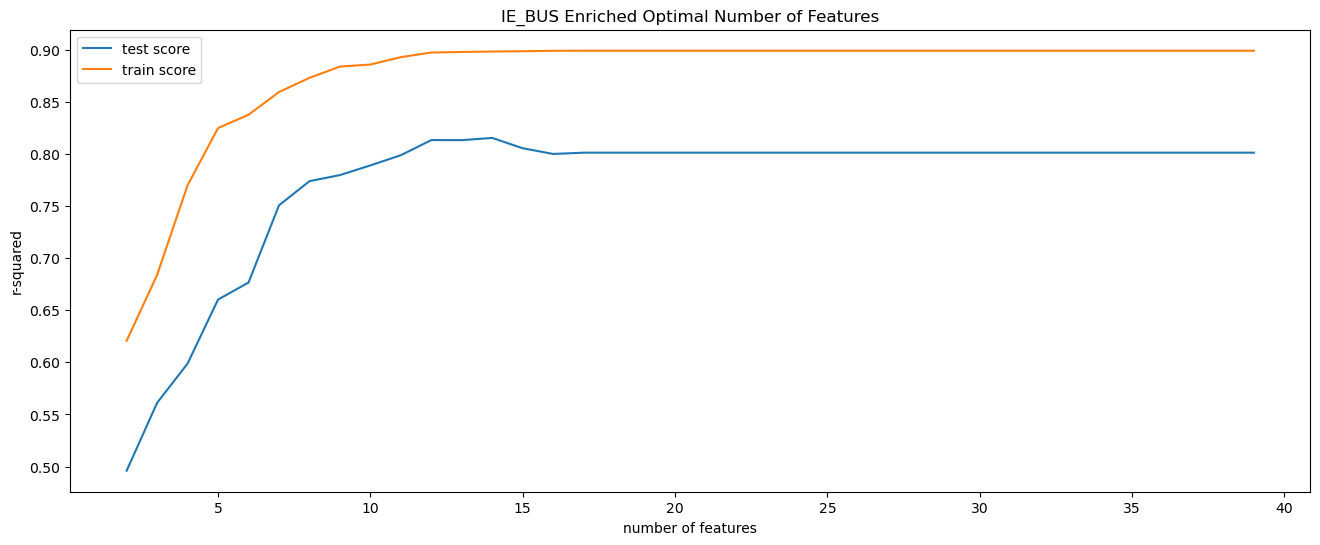

In [157]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results4["param_n_features_to_select"], cv_results4["mean_test_score"])
plt.plot(cv_results4["param_n_features_to_select"], cv_results4["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title('IE_BUS Enriched Optimal Number of Features')
plt.legend(['test score', 'train score'], loc='upper left');

# IE_TRN Hyperparameter Tuning Using Grid Search Cross-Validation

In [158]:
X = mldf2a_TRN.drop(['Year', 'Quarter', 'IE_TRN'], axis=1)
# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols

In [159]:
y = mldf2a_TRN.iloc[:, 2].values # Target variable

In [160]:
X

AT_TRN  BE_TRN  CH_TRN  DE_TRN  DK_TRN  EL_TRN  ES_TRN  FI_TRN  FR_TRN  \
0     -0.11   -1.32   -1.32   -2.90   -1.90    1.87    0.49   -0.38   -0.47   
1      1.18   -0.13   -0.43   -1.95   -1.16    2.51    1.52    1.18    1.02   
2      0.22   -1.04   -1.10   -2.64   -1.72    2.01    0.76   -0.01   -0.11   
3      0.85   -0.42   -0.65   -2.21   -1.34    2.37    1.25    0.81    0.66   
4      0.19   -1.32   -1.03   -1.40   -2.11    1.87   -0.50   -0.53   -0.96   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
123   -1.07    0.53   -0.60   -1.18   -1.66   -1.22   -1.49   -2.09   -0.92   
124   -1.46   -1.18   -1.18   -1.78   -1.96   -1.31   -0.92   -2.61   -0.67   
125   -0.36   -0.04   -0.25   -0.67   -1.25   -1.22   -0.12   -1.42    0.82   
126   -1.18   -0.89   -0.95   -1.52   -1.78   -1.31   -0.73   -2.31   -0.31   
127   -0.63   -0.32   -0.47   -0.97   -1.43   -1.22   -0.31   -1.72    0.45   

     HU_TRN  IT_TRN  LU_TRN  NL_TRN  PL_TRN  PT_TRN  SE_TRN  SI_TRN  
0      1.06    0.75   -0.75   -2.14    3.06    2.12   -1.28    3.79  
1      2.13    2.34    0.40   -1.38    3.90    2.97   -0.68    4.96  
2      1.33    1.16   -0.43   -1.94    3.26    2.33   -1.14    4.10  
3      1.86    1.93    0.08   -1.58    3.69    2.77   -0.84    4.66  
4      0.48    0.46   -0.56   -0.84    2.11    2.04   -1.61    1.40  
..      ...     ...     ...     ...     ...     ...     ...     ...  
123   -2.23   -2.65   -1.70   -0.90   -0.93   -1.19   -0.17   -1.42  
124   -2.39   -2.65   -2.02   -1.18   -0.86   -1.32   -0.75   -1.11  
125   -1.92   -1.60   -1.13   -0.22   -0.70   -1.09   -0.05   -0.77  
126   -2.27   -2.36   -1.83   -0.93   -0.82   -1.25   -0.58   -1.03  
127   -2.05   -1.89   -1.38   -0.48   -0.75   -1.15   -0.24   -0.85  

[128 rows x 17 columns]

In [161]:
y

array([0.83, 0.97, 0.86, 0.94, 0.85, 1.  , 0.89, 0.96, 0.81, 0.95, 0.84,
       0.91, 0.83, 0.97, 0.86, 0.94, 0.78, 0.92, 0.82, 0.88, 0.78, 0.92,
       0.82, 0.88, 0.76, 0.89, 0.79, 0.86, 0.78, 0.92, 0.82, 0.88, 0.76,
       0.89, 0.79, 0.86, 0.76, 0.89, 0.79, 0.86, 0.74, 0.86, 0.77, 0.83,
       0.76, 0.89, 0.79, 0.86, 0.81, 0.95, 0.84, 0.91, 0.76, 0.89, 0.79,
       0.86, 0.69, 0.81, 0.72, 0.78, 0.76, 0.89, 0.79, 0.86, 0.76, 0.89,
       0.79, 0.86, 0.78, 0.92, 0.82, 0.88, 0.76, 0.89, 0.79, 0.86, 0.64,
       0.76, 0.67, 0.73, 0.67, 0.78, 0.7 , 0.75, 0.67, 0.78, 0.7 , 0.75,
       0.64, 0.76, 0.67, 0.73, 0.62, 0.73, 0.65, 0.7 , 0.69, 0.81, 0.72,
       0.78, 0.71, 0.84, 0.74, 0.81, 0.69, 0.81, 0.72, 0.78, 0.71, 0.84,
       0.74, 0.81, 0.76, 0.89, 0.79, 0.86, 0.76, 0.89, 0.79, 0.86, 0.32,
       0.38, 0.34, 0.36, 0.32, 0.38, 0.34, 0.36])

In [162]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [163]:
# number of features
len(X_train.columns)

17

In [164]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [165]:
# cv results
cv_results5 = pd.DataFrame(model_cv.cv_results_)
cv_results5

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.02          0.00             0.00            0.00   
1            0.01          0.00             0.00            0.01   
2            0.02          0.01             0.01            0.01   
3            0.02          0.00             0.00            0.01   
4            0.01          0.00             0.00            0.00   
5            0.01          0.00             0.00            0.00   
6            0.01          0.00             0.00            0.00   
7            0.01          0.00             0.00            0.00   
8            0.01          0.00             0.00            0.00   
9            0.00          0.00             0.00            0.00   
10           0.00          0.00             0.01            0.00   
11           0.00          0.00             0.00            0.00   
12           0.00          0.00             0.00            0.00   
13           0.00          0.00             0.00            0.00   
14           0.00          0.00             0.00            0.00   
15           0.00          0.00             0.00            0.00   
16           0.00          0.00             0.00            0.00   
17           0.00          0.00             0.00            0.00   
18           0.00          0.00             0.00            0.00   
19           0.00          0.00             0.00            0.00   
20           0.00          0.00             0.00            0.00   
21           0.00          0.00             0.00            0.00   
22           0.00          0.00             0.00            0.00   
23           0.00          0.00             0.00            0.00   
24           0.00          0.00             0.00            0.00   
25           0.00          0.00             0.00            0.00   
26           0.00          0.00             0.00            0.00   
27           0.00          0.00             0.00            0.00   
28           0.00          0.00             0.00            0.00   
29           0.00          0.00             0.00            0.00   
30           0.00          0.00             0.00            0.00   
31           0.00          0.00             0.00            0.00   
32           0.00          0.00             0.00            0.00   
33           0.00          0.00             0.00            0.00   
34           0.00          0.00             0.00            0.00   
35           0.00          0.00             0.00            0.00   
36           0.00          0.00             0.00            0.00   
37           0.00          0.00             0.00            0.00   

   param_n_features_to_select                        params  \
0                           2   {'n_features_to_select': 2}   
1                           3   {'n_features_to_select': 3}   
2                           4   {'n_features_to_select': 4}   
3                           5   {'n_features_to_select': 5}   
4                           6   {'n_features_to_select': 6}   
5                           7   {'n_features_to_select': 7}   
6                           8   {'n_features_to_select': 8}   
7                           9   {'n_features_to_select': 9}   
8                          10  {'n_features_to_select': 10}   
9                          11  {'n_features_to_select': 11}   
10                         12  {'n_features_to_select': 12}   
11                         13  {'n_features_to_select': 13}   
12                         14  {'n_features_to_select': 14}   
13                         15  {'n_features_to_select': 15}   
14                         16  {'n_features_to_select': 16}   
15                         17  {'n_features_to_select': 17}   
16                         18  {'n_features_to_select': 18}   
17                         19  {'n_features_to_select': 19}   
18                         20  {'n_features_to_select': 20}   
19                         21  {'n_features_to_select': 21}   
20                         2

In [166]:
feature5 = cv_results5[cv_results5['mean_test_score'] == cv_results5['mean_test_score'].max()]
feature5 = feature5['param_n_features_to_select'].values[0]

accuracy5 = cv_results5[cv_results5['rank_test_score'] == 1]
accuracy5 = accuracy5['mean_test_score'].values[0]

print(f"IE_TRN Enriched number feature selection is: {feature5}", end=' ')
print(f"and its accuracy: {accuracy5}")

IE_TRN Enriched number feature selection is: 17 and its accuracy: 0.8959026463323492


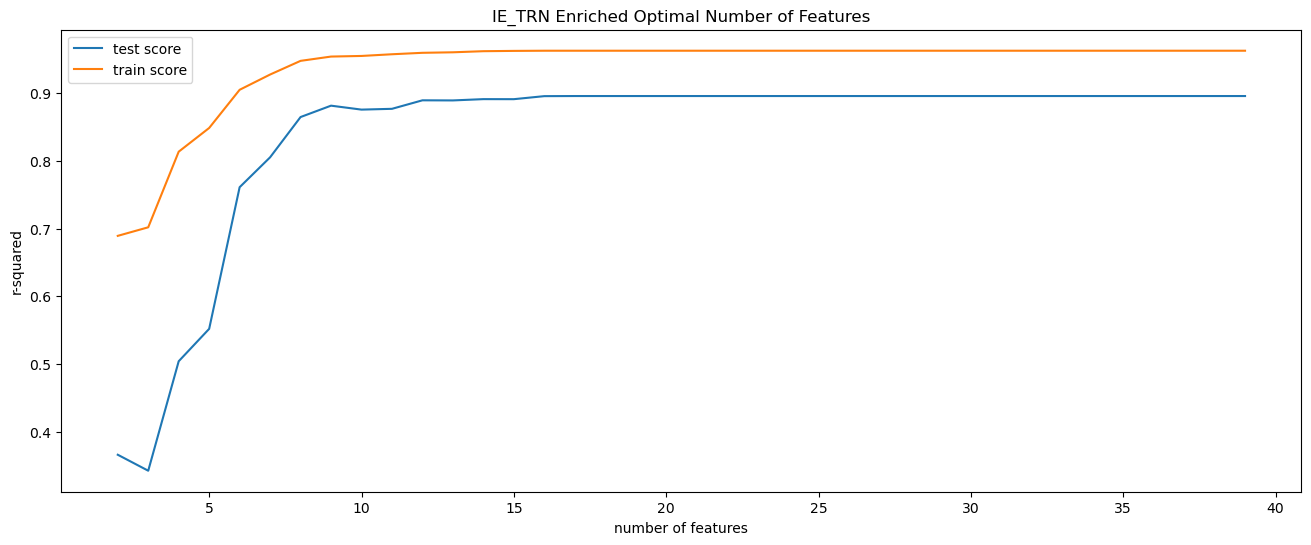

In [167]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results5["param_n_features_to_select"], cv_results5["mean_test_score"])
plt.plot(cv_results5["param_n_features_to_select"], cv_results5["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title('IE_TRN Enriched Optimal Number of Features')
plt.legend(['test score', 'train score'], loc='upper left');

Impressive results after enriching our dataset

In [168]:
# Creating figure x

Output4 = {
    'Country_Vehicle': ['IE_CAR_Enriched', 'IE_BUS_Enriched', 'IE_TRN_Enriched'],
    'Number_of_Features': [16, 14, 17],
    'Accuracy (%)': [98.67, 81.54, 89.59]
}

sup_ML_Results4 = pd.DataFrame(Output4)
sup_ML_Results4

Country_Vehicle  Number_of_Features  Accuracy (%)
0  IE_CAR_Enriched                  16         98.67
1  IE_BUS_Enriched                  14         81.54
2  IE_TRN_Enriched                  17         89.59

# Summary Cross validation and dimensionality reduction:

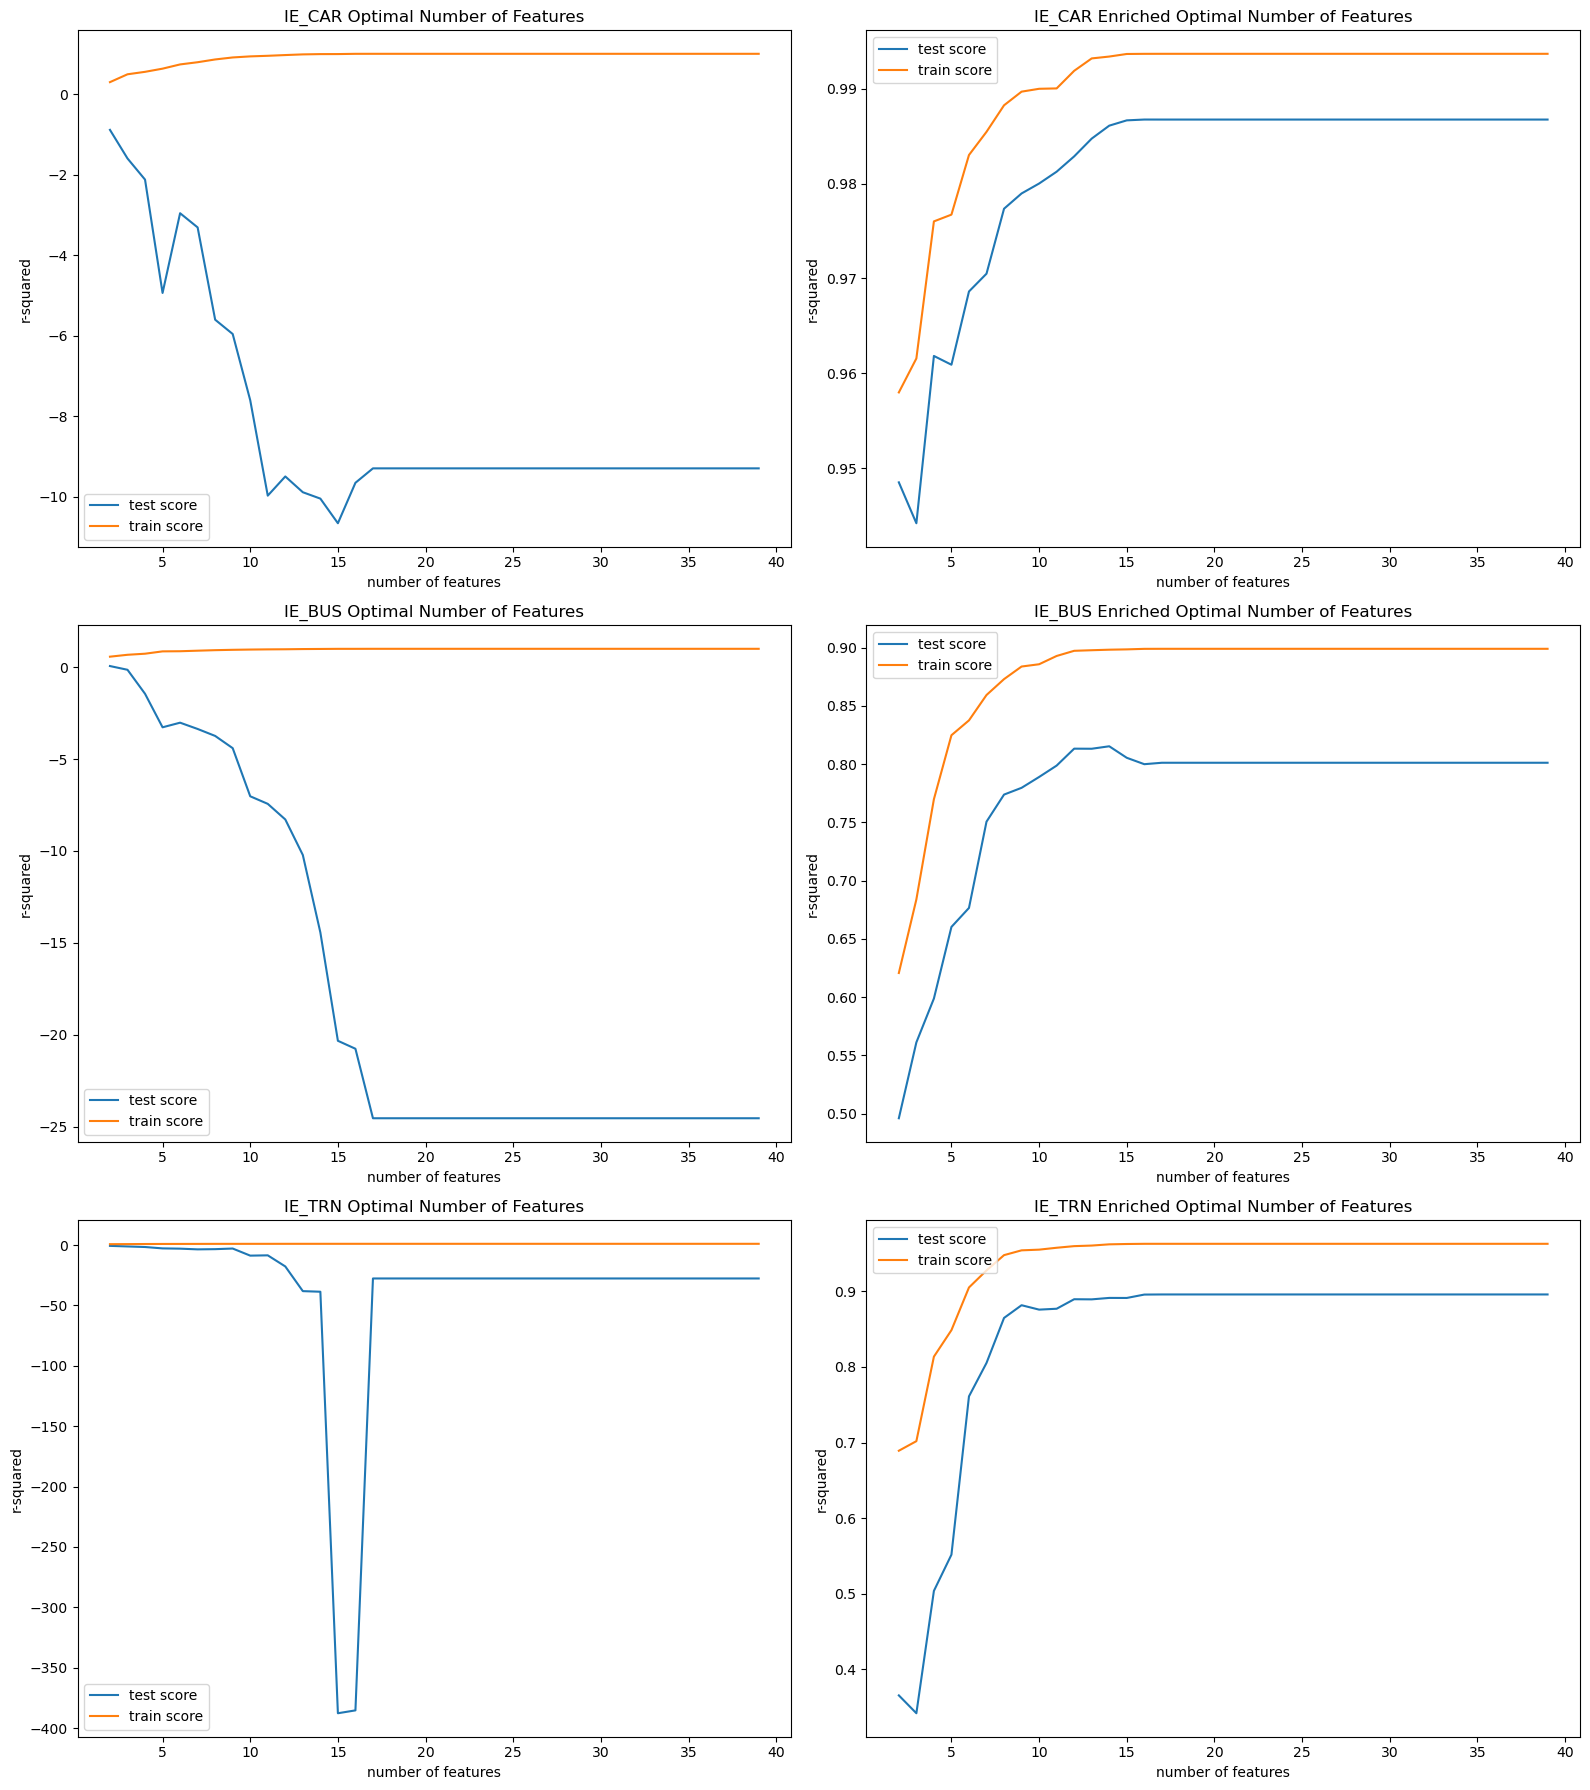

In [169]:
# Create a 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(16, 18))

# Plot the first three plots (above):

# IE_CAR:
axs[0, 0].plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
axs[0, 0].plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
axs[0, 0].set_xlabel('number of features')
axs[0, 0].set_ylabel('r-squared')
axs[0, 0].set_title('IE_CAR Optimal Number of Features')
axs[0, 0].legend(['test score', 'train score'], loc='lower left')

axs[0, 1].plot(cv_results3["param_n_features_to_select"], cv_results3["mean_test_score"])
axs[0, 1].plot(cv_results3["param_n_features_to_select"], cv_results3["mean_train_score"])
axs[0, 1].set_xlabel('number of features')
axs[0, 1].set_ylabel('r-squared')
axs[0, 1].set_title('IE_CAR Enriched Optimal Number of Features')
axs[0, 1].legend(['test score', 'train score'], loc='upper left')

# IE BUS:
axs[1, 0].plot(cv_results1["param_n_features_to_select"], cv_results1["mean_test_score"])
axs[1, 0].plot(cv_results1["param_n_features_to_select"], cv_results1["mean_train_score"])
axs[1, 0].set_xlabel('number of features')
axs[1, 0].set_ylabel('r-squared')
axs[1, 0].set_title('IE_BUS Optimal Number of Features')
axs[1, 0].legend(['test score', 'train score'], loc='lower left')

axs[1, 1].plot(cv_results4["param_n_features_to_select"], cv_results4["mean_test_score"])
axs[1, 1].plot(cv_results4["param_n_features_to_select"], cv_results4["mean_train_score"])
axs[1, 1].set_xlabel('number of features')
axs[1, 1].set_ylabel('r-squared')
axs[1, 1].set_title('IE_BUS Enriched Optimal Number of Features')
axs[1, 1].legend(['test score', 'train score'], loc='upper left')

#IE TRN
axs[2, 0].plot(cv_results2["param_n_features_to_select"], cv_results2["mean_test_score"])
axs[2, 0].plot(cv_results2["param_n_features_to_select"], cv_results2["mean_train_score"])
axs[2, 0].set_xlabel('number of features')
axs[2, 0].set_ylabel('r-squared')
axs[2, 0].set_title('IE_TRN Optimal Number of Features')
axs[2, 0].legend(['test score', 'train score'], loc='lower left')

axs[2, 1].plot(cv_results5["param_n_features_to_select"], cv_results5["mean_test_score"])
axs[2, 1].plot(cv_results5["param_n_features_to_select"], cv_results5["mean_train_score"])
axs[2, 1].set_xlabel('number of features')
axs[2, 1].set_ylabel('r-squared')
axs[2, 1].set_title('IE_TRN Enriched Optimal Number of Features')
axs[2, 1].legend(['test score', 'train score'], loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [323]:
# Creating figure x

Output5 = {
    'Country_Vehicle': ['IE_CAR', 'IE_BUS', 'IE_TRN'],
    'Number_of_Features': [2, 2, 2],
    'Accuracy (%)': [-88.85, 6.15, -70.44],
    'Number_of_Features_Enriched': [16, 14, 17],
    'Accuracy_Enriched (%)': [98.67, 81.54, 89.59]
}

sup_ML_Results5 = pd.DataFrame(Output5)
sup_ML_Results5

Country_Vehicle  Number_of_Features  Accuracy (%)  \
0          IE_CAR                   2        -88.85   
1          IE_BUS                   2          6.15   
2          IE_TRN                   2        -70.44   

   Number_of_Features_Enriched  Accuracy_Enriched (%)  
0                           16                  98.67  
1                           14                  81.54  
2                           17                  89.59

# 4.3.	Unsupervised learning.

# PCA and Clustering CAR
PCA: Principal Component Analysis

In [171]:
mldf2_CAR1.head(4)

Year  Quarter  IE_CAR  AT_CAR  BE_CAR  CH_CAR  DE_CAR  DK_CAR  EL_CAR  \
0  1990        1   19.53   17.73   19.16   18.88   19.64   18.95   14.72   
1  1990        2   22.92   20.82   22.49   22.17   23.06   22.25   17.28   
2  1990        3   20.38   18.50   19.99   19.70   20.50   19.78   15.36   
3  1990        4   22.07   20.05   21.66   21.35   22.20   21.42   16.64   

   ES_CAR  FI_CAR  FR_CAR  HU_CAR  IT_CAR  LU_CAR  NL_CAR  PL_CAR  PT_CAR  \
0   17.96   18.68   19.50   13.92   18.45   19.62   19.57    9.50   16.45   
1   21.09   21.92   22.90   16.34   21.65   23.03   22.98   11.15   19.30   
2   18.74   19.49   20.35   14.52   19.25   20.47   20.42    9.91   17.16   
3   20.31   21.11   22.05   15.73   20.85   22.18   22.13   10.74   18.59   

   SE_CAR  SI_CAR  
0   19.34   14.42  
1   22.71   16.93  
2   20.18   15.05  
3   21.87   16.30

In [172]:
mldf2_CAR1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     128 non-null    object 
 1   Quarter  128 non-null    int64  
 2   IE_CAR   128 non-null    float64
 3   AT_CAR   128 non-null    float64
 4   BE_CAR   128 non-null    float64
 5   CH_CAR   128 non-null    float64
 6   DE_CAR   128 non-null    float64
 7   DK_CAR   128 non-null    float64
 8   EL_CAR   128 non-null    float64
 9   ES_CAR   128 non-null    float64
 10  FI_CAR   128 non-null    float64
 11  FR_CAR   128 non-null    float64
 12  HU_CAR   128 non-null    float64
 13  IT_CAR   128 non-null    float64
 14  LU_CAR   128 non-null    float64
 15  NL_CAR   128 non-null    float64
 16  PL_CAR   128 non-null    float64
 17  PT_CAR   128 non-null    float64
 18  SE_CAR   128 non-null    float64
 19  SI_CAR   128 non-null    float64
dtypes: float64(18), int64(1), object(1)
memory usage: 20.1

In [173]:
# distributing the dataset into two components X and Y
X = mldf2_CAR1.iloc[:, 2:].values
y = mldf2_CAR1.iloc[:, 1].values

In [174]:
X

array([[19.53, 17.73, 19.16, ..., 16.45, 19.34, 14.42],
       [22.92, 20.82, 22.49, ..., 19.3 , 22.71, 16.93],
       [20.38, 18.5 , 19.99, ..., 17.16, 20.18, 15.05],
       ...,
       [23.14, 21.92, 23.11, ..., 24.65, 22.71, 24.3 ],
       [20.57, 19.49, 20.54, ..., 21.91, 20.18, 21.6 ],
       [22.28, 21.11, 22.26, ..., 23.74, 21.87, 23.4 ]])

In [175]:
y

array([1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2,
       3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4,
       1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2,
       3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4,
       1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2,
       3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4], dtype=int64)

In [176]:
# Splitting the X and Y into the Training set and Testing set

# Split the data set into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [177]:
# performing preprocessing part

# Create and initialise an object (sc) by calling a method named as StandardScaler()
sc = StandardScaler()

# Train the model by calling a method fit_transform()
X_train = sc.fit_transform(X_train)

# Transform the data into standised form
X_test = sc.transform(X_test)

In [178]:
# Applying PCA function on training and testing set of X component
# Create and initialise an object (pca) by calling a method PCA
pca = PCA(n_components = 3)

# Transform the data into traning and testing
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
# Store the explauned variance
explained_variance = pca.explained_variance_ratio_

print(explained_variance)

[0.77171509 0.16514322 0.02878059]


## Display PCA components

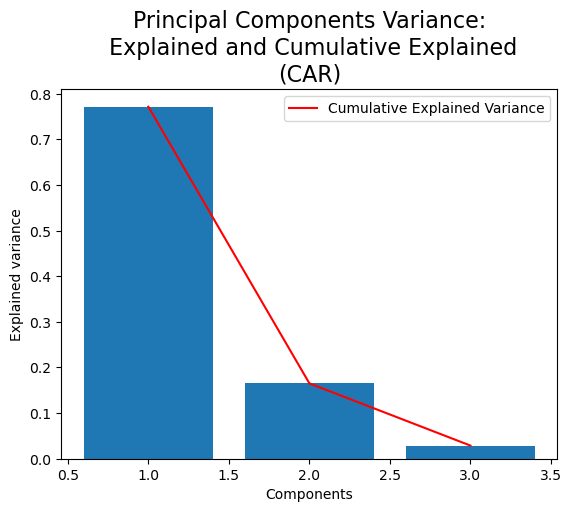

In [179]:
plt.bar(range(1,len(explained_variance) + 1), explained_variance)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(explained_variance ) + 1), explained_variance,
         c = 'red',
         label = "Cumulative Explained Variance")
# Title
plt.title('Principal Components Variance:\n Explained and Cumulative Explained\n(CAR)', fontsize=16)
plt.legend(loc = 'best');

# PCA for Machine Learning Model
## CAR

In [180]:
# Dropping columns 'Year' and 'Quarter' we don't need them. Unit of measurement for this dataset is percentage
mldf2_CAR1 = mldf2_CAR1.drop(['Year', 'Quarter'], axis=1).reset_index(drop=True)

In [181]:
scalar = StandardScaler()
  
# fitting
scalar.fit(mldf2_CAR1)
scaled_data = scalar.transform(mldf2_CAR1)
  
# Selecting 3 components
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
  
x_pca.shape

(128, 3)

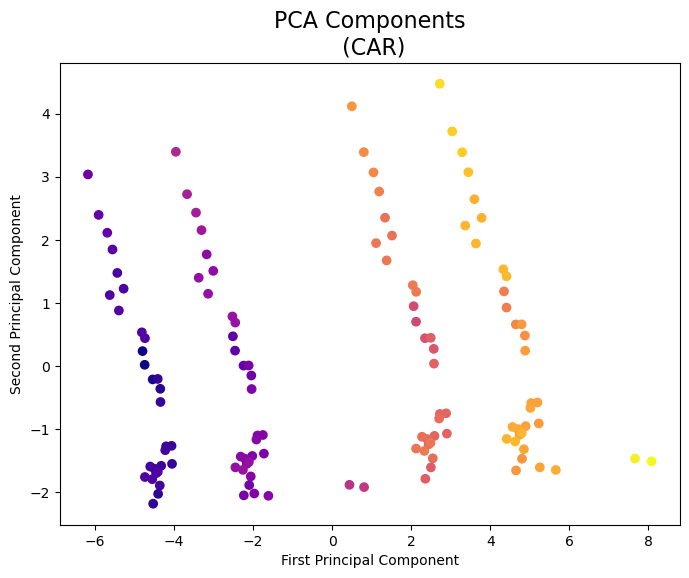

In [182]:
plt.figure(figsize = (8, 6))
  
plt.scatter(x_pca[:, 0], x_pca[:, 1], c = mldf2_CAR1['IE_CAR'], cmap ='plasma')
# Title
plt.title('PCA Components\n (CAR)', fontsize=16)

  
# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component');

In [183]:
# Display components
pcaComponents = pca.components_, pca.explained_variance_ratio_
pcaComponents

(array([[ 0.25250628,  0.26180812,  0.24321413,  0.21214331,  0.26031768,
          0.24602258,  0.19248385,  0.23184437,  0.26396734,  0.25178832,
          0.21578964,  0.25588079,  0.25317172,  0.26322363,  0.15137627,
          0.1970852 ,  0.24695898,  0.20784609],
        [ 0.1441807 ,  0.06374642,  0.19780802,  0.33988971,  0.11390313,
         -0.04545173, -0.40719512, -0.07402419, -0.02364162,  0.1768251 ,
         -0.22829518,  0.12185619,  0.17657035,  0.02247755, -0.44889781,
         -0.38389245,  0.1934286 , -0.34262923],
        [ 0.15604252, -0.15154564,  0.11311533, -0.2051278 , -0.05937389,
          0.43561874,  0.06602137,  0.41317438, -0.02680508, -0.15828554,
          0.48229411, -0.10087341, -0.09115208, -0.07009309, -0.36332688,
         -0.13819831, -0.1349357 , -0.2799301 ]]),
 array([0.78482662, 0.15409201, 0.02796258]))

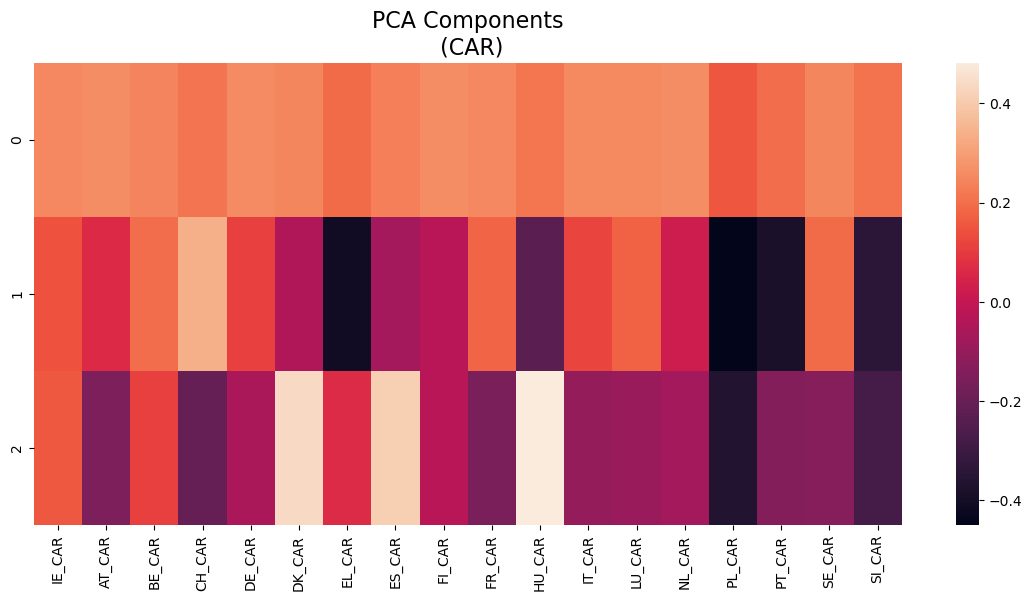

In [184]:
df_comp = pd.DataFrame(pca.components_, columns = mldf2_CAR1.columns)
  
plt.figure(figsize =(14, 6))

# Title
plt.title('PCA Components\n (CAR)', fontsize=16)

  
# plotting heatmap
sns.heatmap(df_comp);

# Elbow Method

6361.2687921874995
2806.0640708699902
2004.9451844827586
1369.4983945623585
1132.7075823357814
961.5674408423047
787.9164269620744
691.5613942866693
620.0404208546352
569.3336905772006


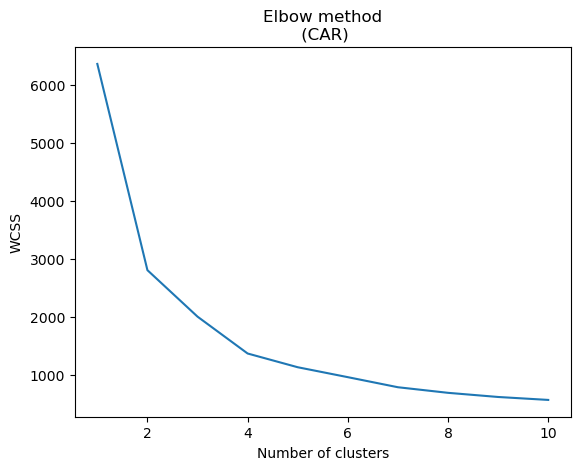

In [185]:
# Finding the optimum number of clusters for k-means classification
wcss = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    print(kmeans.inertia_)
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow method\n (CAR)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

## Silhouette Score
Near +1: Indicates that the sample is far away from the neighboring clusters.

0: Indicates that the sample is on or very close to the decision boundary between two neighboring clusters.

Near -1: Indicates that those samples might have been assigned to the wrong cluster.

In [186]:
# Instantiate the KMeans models
km = KMeans(n_clusters = 2, random_state=42)

# Fit the KMeans model
km.fit_predict(X)

# Calculate Silhoutte Score
silhouettescore = silhouette_score(X, km.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % silhouettescore)

Silhouetter Score: 0.490


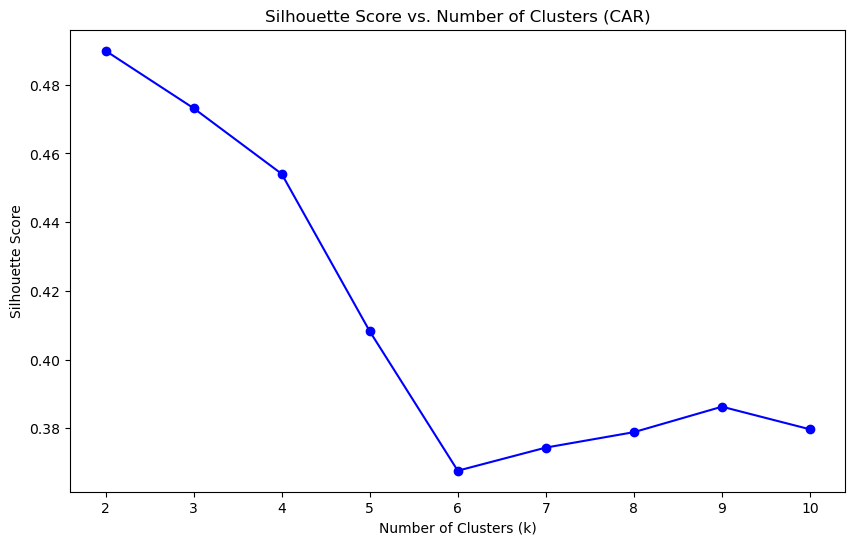

In [187]:
# Storing silhouette scores
silhouettescore = []

# Redifining X for later reproducibility

Xs =X

# Setting the range of clusters we want to test
k_values = range(2, 11)

# Calculating silhouette scores for each value of k
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels = km.fit_predict(Xs)
    silhouettescore.append(silhouette_score(Xs, km_labels, metric='euclidean'))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouettescore, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (CAR)')


plt.show()

## BUS

In [188]:
mldf2_BUS1.head(4)

Year  Quarter  IE_BUS  AT_BUS  BE_BUS  CH_BUS  DE_BUS  DK_BUS  EL_BUS  \
0  1990        1    2.65    2.53    2.44    0.85    2.09    2.60    7.45   
1  1990        2    3.11    2.97    2.86    1.00    2.46    3.05    8.75   
2  1990        3    2.76    2.64    2.54    0.89    2.18    2.71    7.78   
3  1990        4    2.99    2.86    2.76    0.96    2.37    2.94    8.42   

   ES_BUS  FI_BUS  FR_BUS  HU_BUS  IT_BUS  LU_BUS  NL_BUS  PL_BUS  PT_BUS  \
0    3.43    3.10    1.38    5.70    2.97    2.35    1.86    6.49    4.23   
1    4.02    3.65    1.62    6.70    3.48    2.75    2.19    7.61    4.97   
2    3.58    3.24    1.44    5.95    3.10    2.45    1.94    6.77    4.42   
3    3.87    3.51    1.56    6.45    3.35    2.65    2.11    7.33    4.78   

   SE_BUS  SI_BUS  
0    2.19    7.04  
1    2.57    8.26  
2    2.28    7.34  
3    2.47    7.96

In [189]:
# distributing the dataset into two components X and Y
X = mldf2_BUS1.iloc[:, 2:].values
y = mldf2_BUS1.iloc[:, 1].values

In [190]:
# Split the data set into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [191]:
# performing preprocessing part
# Create and initialise an object (sc) by calling a method named as StandardScaler()
sc = StandardScaler()

# Train the model by calling a method fit_transform()
X_train = sc.fit_transform(X_train)

# Transform the data into standised form
X_test = sc.transform(X_test)

In [192]:
# Create and initialise an object (pca) by calling a method PCA
pca = PCA(n_components = 3)

# Transform the data into traning and testing
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
# Store the explauned variance
explained_variance1 = pca.explained_variance_ratio_

print(explained_variance1)

[0.52207334 0.2149303  0.09974296]


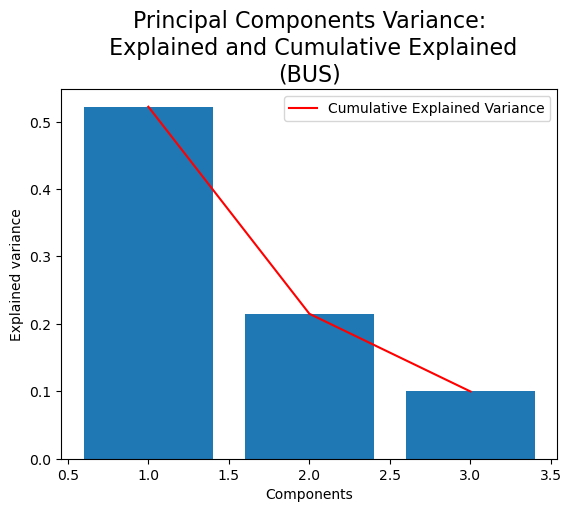

In [193]:
plt.bar(range(1,len(explained_variance1 ) + 1), explained_variance1)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(explained_variance1 ) + 1), explained_variance1,
         c = 'red',
         label = "Cumulative Explained Variance")
# Title
plt.title('Principal Components Variance:\n Explained and Cumulative Explained\n(BUS)', fontsize=16)
plt.legend(loc = 'best');

In [194]:
# Dropping columns 'Year' and 'Quarter' we don't need them. Unit of measurement for this dataset is percentage
mldf2_BUS1 = mldf2_BUS1.drop(['Year', 'Quarter'], axis=1).reset_index(drop=True)

In [195]:
scalar = StandardScaler()
  
# fitting
scalar.fit(mldf2_BUS1)
scaled_data = scalar.transform(mldf2_BUS1)
  
# Selecting 3 components
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca1 = pca.transform(scaled_data)
  
x_pca1.shape

(128, 3)

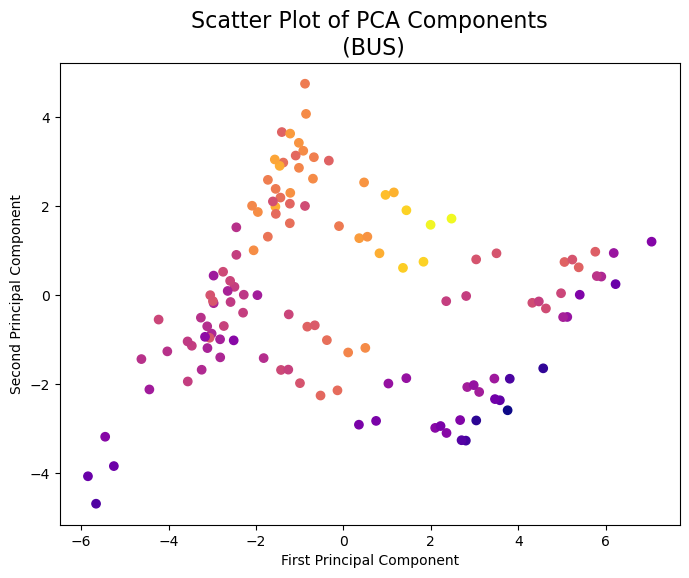

In [196]:
plt.figure(figsize = (8, 6))
  
plt.scatter(x_pca1[:, 0], x_pca1[:, 1], c = mldf2_BUS1['IE_BUS'], cmap ='plasma')
# Title
plt.title('Scatter Plot of PCA Components\n (BUS)', fontsize=16)

# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component');

In [197]:
# Display components
pcaComponents1 = pca.components_, pca.explained_variance_ratio_
pcaComponents1

(array([[-0.04088104,  0.23846982,  0.02523198, -0.22332556,  0.24229343,
          0.28047854,  0.32382048,  0.21344194,  0.31534742,  0.07181177,
          0.24852177,  0.01264526, -0.11724277,  0.31132331,  0.27180891,
          0.3050637 ,  0.26420304,  0.29869598],
        [ 0.37349917,  0.24176766,  0.3542866 ,  0.29985071,  0.22634786,
         -0.01144435, -0.05366496,  0.07901682,  0.05367524,  0.32393603,
          0.21729935,  0.39369997,  0.42783207, -0.10452225, -0.00084377,
         -0.13430982,  0.02558321, -0.05861425],
        [-0.31052635, -0.1465382 , -0.36393158,  0.08939946,  0.27373584,
         -0.25101687, -0.01736811, -0.34804208,  0.06124345,  0.47376885,
         -0.28818789,  0.11176435,  0.2171894 ,  0.04998056,  0.11852808,
          0.02591439,  0.21920079,  0.21469935]]),
 array([0.51629069, 0.21873972, 0.09872859]))

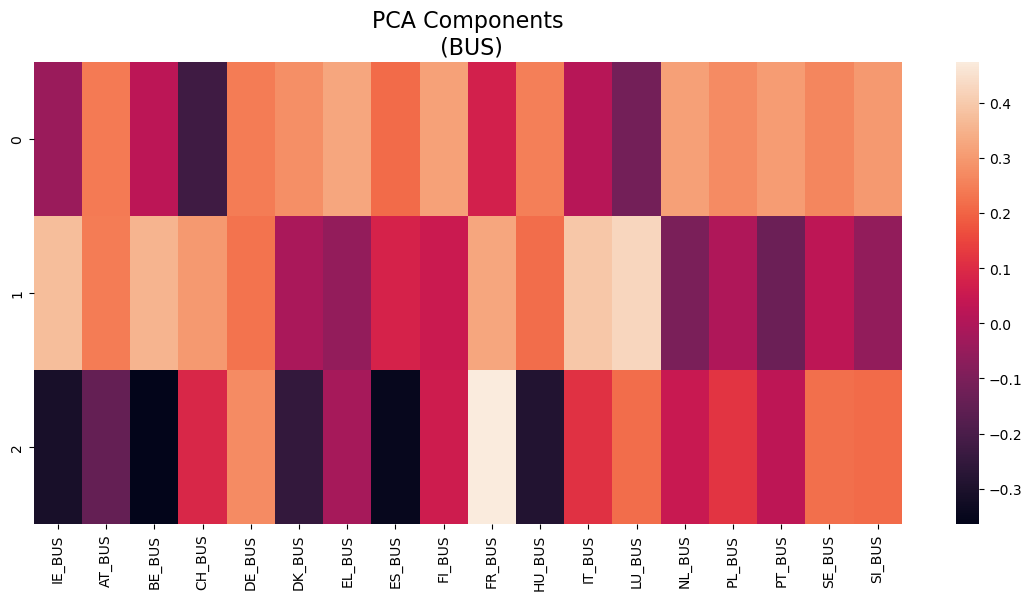

In [198]:
df_comp1 = pd.DataFrame(pca.components_, columns = mldf2_BUS1.columns)
  
plt.figure(figsize =(14, 6))

# Title
plt.title('PCA Components\n (BUS)', fontsize=16)

  
# plotting heatmap
sns.heatmap(df_comp1);

1424.4776429687502
582.7184572510823
421.40435776397516
329.2528003488843
270.9998750155019
235.75255592105265
200.63284357448103
171.89789825757578
148.98456741071428
134.7327332251082


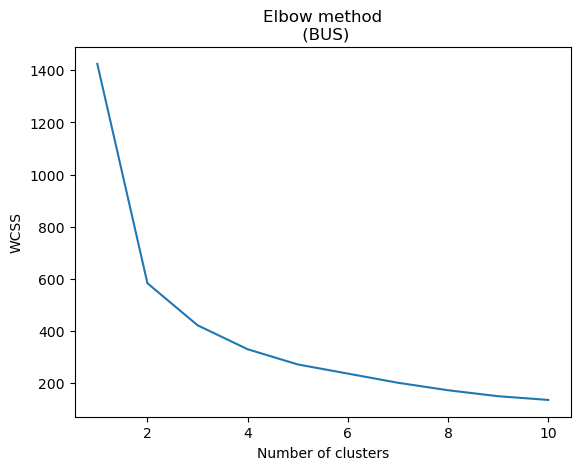

In [199]:
# Finding the optimum number of clusters for k-means classification
wcss1 = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss1.append(kmeans.inertia_)
    print(kmeans.inertia_)
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss1)
plt.title('Elbow method\n (BUS)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

In [200]:
# Instantiate the KMeans models
km = KMeans(n_clusters=3, random_state=42)

# Fit the KMeans model
km.fit_predict(X)

# Calculate Silhoutte Score
silhouette_score1 = silhouette_score(X, km.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % silhouette_score1)

Silhouetter Score: 0.412


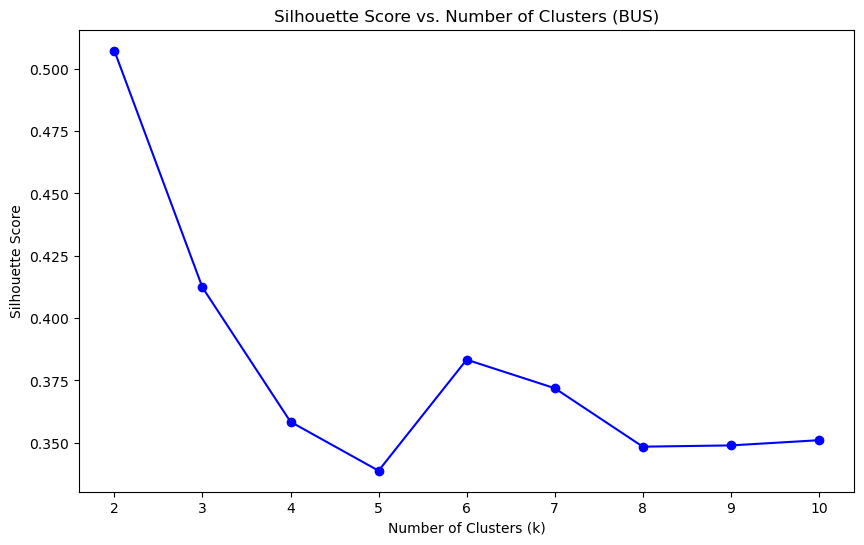

In [201]:
# Storing silhouette scores
silhouettescore1 = []

# Redifining X for later reproducibility

Xs1 =X

# Setting the range of clusters we want to test
k_values = range(2, 11)

# Calculating silhouette scores for each value of k
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels1 = km.fit_predict(Xs1)
    silhouettescore1.append(silhouette_score(Xs1, km_labels1, metric='euclidean'))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouettescore1, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (BUS)')


plt.show()

# TRN

In [202]:
mldf2_TRN1.head(8)

Year  Quarter  IE_TRN  AT_TRN  BE_TRN  CH_TRN  DE_TRN  DK_TRN  EL_TRN  \
0  1990        1    0.83    2.74    1.40    3.27    1.24    1.45    0.83   
1  1990        2    0.97    3.21    1.65    3.83    1.46    1.70    0.97   
2  1990        3    0.86    2.86    1.46    3.41    1.30    1.51    0.86   
3  1990        4    0.94    3.09    1.59    3.69    1.40    1.64    0.94   
4  1991        1    0.85    2.85    1.40    3.45    1.59    1.38    0.83   
5  1991        2    1.00    3.35    1.65    4.05    1.86    1.62    0.97   
6  1991        3    0.89    2.98    1.46    3.60    1.66    1.44    0.86   
7  1991        4    0.96    3.22    1.59    3.90    1.79    1.56    0.94   

   ES_TRN  FI_TRN  FR_TRN  HU_TRN  IT_TRN  LU_TRN  NL_TRN  PL_TRN  PT_TRN  \
0    1.59    1.22    2.14    3.38    1.59    1.01    1.59    7.02    2.32   
1    1.86    1.43    2.51    3.97    1.86    1.19    1.86    8.24    2.73   
2    1.66    1.27    2.23    3.53    1.66    1.06    1.66    7.32    2.42   
3    1.79    1.38    2.42    3.82    1.79    1.14    1.79    7.93    2.63   
4    1.33    1.20    2.02    3.06    1.54    1.04    2.05    5.66    2.28   
5    1.57    1.40    2.38    3.59    1.81    1.22    2.40    6.64    2.67   
6    1.39    1.25    2.11    3.19    1.61    1.08    2.14    5.90    2.38   
7    1.51    1.35    2.29    3.46    1.74    1.17    2.31    6.40    2.57   

   SE_TRN  SI_TRN  
0    1.50    1.54  
1    1.76    1.81  
2    1.56    1.61  
3    1.69    1.74  
4    1.36    0.99  
5    1.59    1.16  
6    1.42    1.03  
7    1.53    1.12

In [203]:
# distributing the dataset into two components X and Y
X = mldf2_TRN1.iloc[:, 2:].values
y = mldf2_TRN1.iloc[:, 1].values

In [204]:
# Split the data set into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [205]:
# performing preprocessing part
# Create and initialise an object (sc) by calling a method named as StandardScaler()
sc = StandardScaler()

# Train the model by calling a method fit_transform()
X_train = sc.fit_transform(X_train)

# Transform the data into standised form
X_test = sc.transform(X_test)

In [206]:
# Create and initialise an object (pca) by calling a method PCA
pca = PCA(n_components = 3)

# Transform the data into traning and testing
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
# Store the explauned variance
explained_variance2 = pca.explained_variance_ratio_

print(explained_variance2)

[0.44371637 0.33012741 0.07419443]


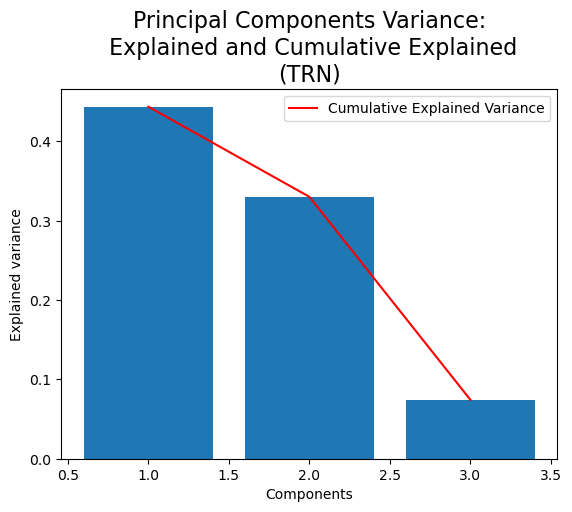

In [207]:
plt.bar(range(1,len(explained_variance2 ) + 1), explained_variance2)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(explained_variance2 ) + 1), explained_variance2,
         c = 'red',
         label = "Cumulative Explained Variance")
# Title
plt.title('Principal Components Variance:\n Explained and Cumulative Explained\n(TRN)', fontsize=16)
plt.legend(loc = 'best');

In [208]:
# Dropping columns 'Year' and 'Quarter' we don't need them. Unit of measurement for this dataset is percentage
mldf2_TRN1 = mldf2_TRN1.drop(['Year', 'Quarter'], axis=1).reset_index(drop=True)

In [209]:
scalar = StandardScaler()
  
# fitting
scalar.fit(mldf2_TRN1)
scaled_data = scalar.transform(mldf2_TRN1)
  
# Selecting 3 components
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca2 = pca.transform(scaled_data)
  
x_pca2.shape

(128, 3)

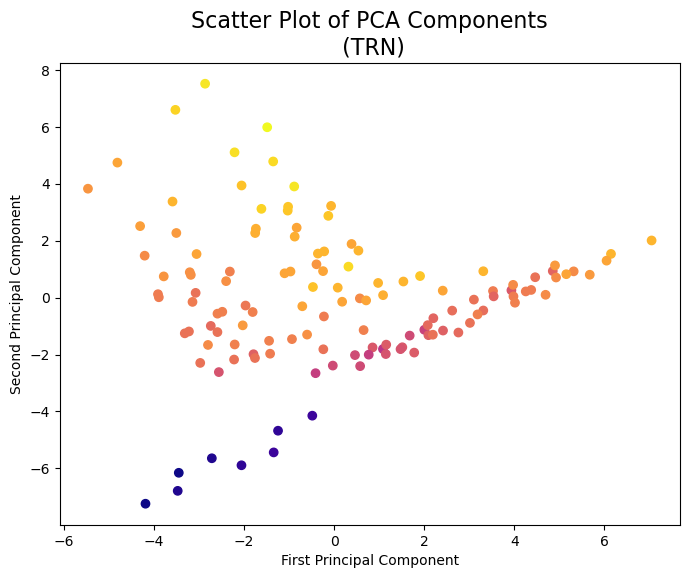

In [210]:
plt.figure(figsize = (8, 6))
  
plt.scatter(x_pca2[:, 0], x_pca2[:, 1], c = mldf2_TRN1['IE_TRN'], cmap ='plasma')
# Title
plt.title('Scatter Plot of PCA Components\n (TRN)', fontsize=16)

# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component');

In [211]:
# Display components
pcaComponents2 = pca.components_, pca.explained_variance_ratio_
pcaComponents2

(array([[ 0.03164137,  0.21565828,  0.32734813,  0.33533778,  0.33192604,
          0.24946635, -0.20921598,  0.15536064,  0.23732553,  0.30966614,
         -0.11296593,  0.16417316,  0.08025272,  0.33295188, -0.18075212,
         -0.13878677,  0.33235607, -0.1447195 ],
        [ 0.35282729,  0.23704219, -0.02261941,  0.01549766,  0.04302363,
         -0.00121151,  0.31862644,  0.20404729,  0.27446235,  0.06616482,
          0.29679436,  0.33270918,  0.27967141,  0.00815595,  0.32177111,
          0.34503354, -0.0647123 ,  0.30002787],
        [ 0.28790696, -0.38065743, -0.03949407, -0.05882618,  0.11446764,
          0.53996749, -0.01125643, -0.33704573, -0.03640333,  0.0039459 ,
          0.49336832,  0.09255377, -0.06354142,  0.03924011, -0.16048652,
         -0.2220019 , -0.06648278,  0.10216481]]),
 array([0.43701101, 0.33511125, 0.07510726]))

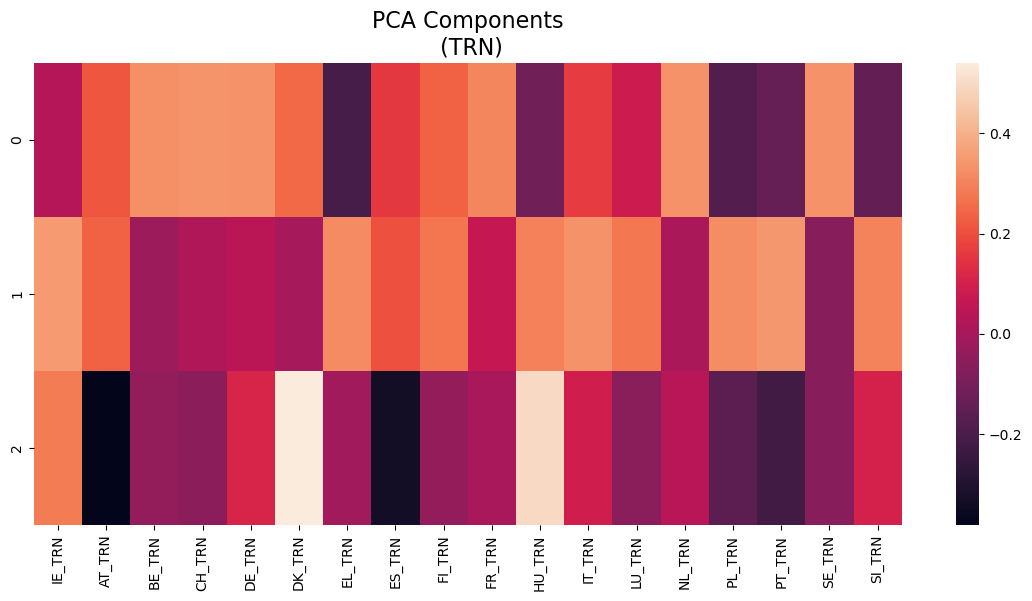

In [212]:
df_comp2 = pd.DataFrame(pca.components_, columns = mldf2_TRN1.columns)
  
plt.figure(figsize =(14, 6))

# Title
plt.title('PCA Components\n (TRN)', fontsize=16)

  
# plotting heatmap
sns.heatmap(df_comp2);

510.2068585937501
256.3881221153847
170.42063947802197
130.58263793290044
96.78603577504929
80.8375265321613
68.81094025832556
59.179065
52.53512703703704
47.988238214285715


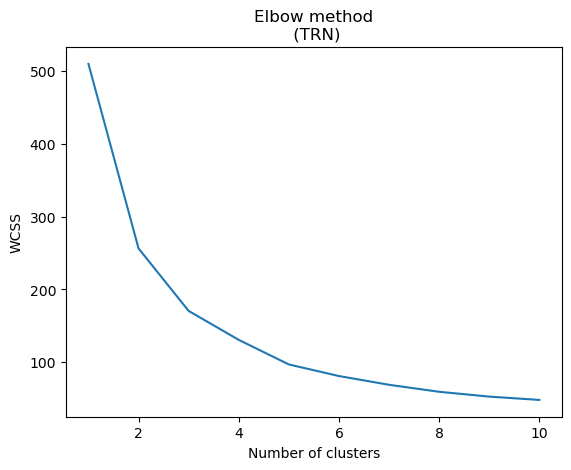

In [213]:
# Finding the optimum number of clusters for k-means classification
wcss2 = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss2.append(kmeans.inertia_)
    print(kmeans.inertia_)
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss2)
plt.title('Elbow method\n (TRN)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

In [214]:
# Instantiate the KMeans models
km = KMeans(n_clusters=3, random_state=42)

# Fit the KMeans model
km.fit_predict(X)

# Calculate Silhoutte Score
silhouette_score1 = silhouette_score(X, km.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % silhouette_score1)

Silhouetter Score: 0.386


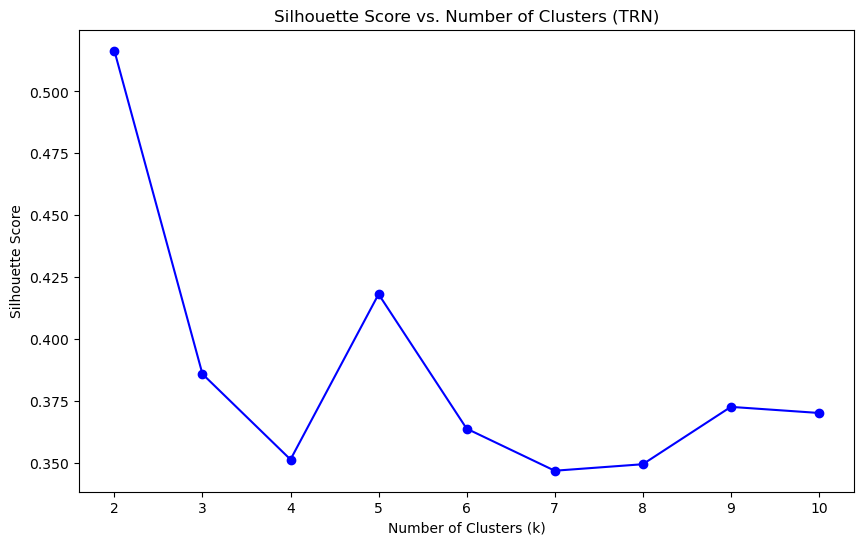

In [215]:
# Storing silhouette scores
silhouettescore2 = []

# Redifining X for later reproducibility

Xs2 =X

# Setting the range of clusters we want to test
k_values = range(2, 11)

# Calculating silhouette scores for each value of k
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels2 = km.fit_predict(Xs2)
    silhouettescore2.append(silhouette_score(Xs2, km_labels2, metric='euclidean'))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouettescore2, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (TRN)')


plt.show()

In [216]:
# Figure X....
# Data
output6 = {
    'Vehicle': ['CAR', 'BUS', 'TRN'],
    'First, Second and Third Component (PCA)': [
        [0.77171509, 0.16514322, 0.02878059],
        [0.52207334, 0.2149303, 0.09974296],
        [0.44371637, 0.33012741, 0.07419443]
    ]
}

# Create DataFrame
unsup_ML_Results6 = pd.DataFrame(output6)
unsup_ML_Results6 

Vehicle First, Second and Third Component (PCA)
0     CAR    [0.77171509, 0.16514322, 0.02878059]
1     BUS     [0.52207334, 0.2149303, 0.09974296]
2     TRN    [0.44371637, 0.33012741, 0.07419443]

In [217]:
# Figure X....
# Data
output7 = {
    'Vehicle': ['CAR', 'BUS', 'TRN'],
    'Silhouetter_Score': [0.490, 0.412,0.386]
}

# Create DataFrame
unsup_ML_Results7 = pd.DataFrame(output7)
unsup_ML_Results7 

Vehicle  Silhouetter_Score
0     CAR               0.49
1     BUS               0.41
2     TRN               0.39

# Enriching data  monthly values

In [218]:
mldf2b = mldf2.copy() # Dataset for Unsupervised ML Enriched

In [219]:
mldf2.head()

Year  AT_BUS  AT_CAR  AT_TRN  BE_BUS  BE_CAR  BE_TRN  CH_BUS  CH_CAR  \
0  1990   11.00   77.10   11.90   10.60   83.30    6.10    3.70   82.10   
1  1991   10.60   77.00   12.40   10.70   83.30    6.10    3.90   81.10   
2  1992   10.50   77.00   12.50   10.70   83.30    6.00    4.00   81.40   
3  1993   10.70   77.20   12.10   10.90   83.30    5.90    3.90   80.90   
4  1994   10.60   77.80   11.60   11.80   82.60    5.60    4.00   79.80   

   CH_TRN  ...  PL_TRN  PT_BUS  PT_CAR  PT_TRN  SE_BUS  SE_CAR  SE_TRN  \
0   14.20  ...   30.50   18.40   71.50   10.10    9.50   84.10    6.50   
1   15.00  ...   24.60   18.60   71.40    9.90    9.50   84.70    5.90   
2   14.60  ...   20.30   22.70   68.20    9.00    9.40   84.80    5.80   
3   15.20  ...   17.70   19.30   72.20    8.50    9.30   84.40    6.30   
4   16.20  ...   15.60   17.90   74.30    7.80    9.30   84.40    6.30   

   SI_BUS  SI_CAR  SI_TRN  
0   30.60   62.70    6.70  
1   29.30   66.40    4.30  
2   23.00   73.90    3.00  
3   21.10   75.80    3.10  
4   20.40   76.60    3.00  

[5 rows x 55 columns]

In [220]:
import pandas as pd

def addMonUnsuMl(mldf2b, weights):
    # Create a list to store the transformed data
    transformed_rows = []

    for index, row in mldf2b.iterrows():
        year = row['Year']

        # Iterate through each country and mode of transport
        for column_name in mldf2b.columns[1:]:  # Exclude the 'Year' column
            # Check if the column name has the expected format
            if '_' in column_name:
                country, mode = column_name.split('_')

                # Calculate values for each month based on weights
                at_value = row[column_name]
                values = [round(at_value * weight, 2) for weight in weights]

                # Add rows to the transformed list
                for month, value in enumerate(values, start=1):
                    transformed_rows.append({'Year': year, 'Month': month, column_name: value})

    # Create the transformed DataFrame
    transformed_df = pd.DataFrame(transformed_rows)

    return transformed_df

weights = [0.09, 0.08, 0.07, 0.11, 0.06, 0.12, 0.07, 0.03, 0.13, 0.09, 0.07, 0.08]

mldf2b = addMonUnsuMl(mldf2b, weights)
mldf2b = mldf2b.pivot_table(index=['Year', 'Month'], aggfunc='sum').reset_index()
mldf2b


Year  Month  AT_BUS  AT_CAR  AT_TRN  BE_BUS  BE_CAR  BE_TRN  CH_BUS  \
0    1990      1    0.99    6.94    1.07    0.95    7.50    0.55    0.33   
1    1990      2    0.88    6.17    0.95    0.85    6.66    0.49    0.30   
2    1990      3    0.77    5.40    0.83    0.74    5.83    0.43    0.26   
3    1990      4    1.21    8.48    1.31    1.17    9.16    0.67    0.41   
4    1990      5    0.66    4.63    0.71    0.64    5.00    0.37    0.22   
..    ...    ...     ...     ...     ...     ...     ...     ...     ...   
379  2021      8    0.27    2.44    0.29    0.25    2.57    0.19    0.18   
380  2021      9    1.17   10.56    1.27    1.07   11.13    0.81    0.77   
381  2021     10    0.81    7.31    0.88    0.74    7.70    0.56    0.53   
382  2021     11    0.63    5.68    0.69    0.57    5.99    0.43    0.41   
383  2021     12    0.72    6.50    0.78    0.66    6.85    0.50    0.47   

     CH_CAR  ...  PL_TRN  PT_BUS  PT_CAR  PT_TRN  SE_BUS  SE_CAR  SE_TRN  \
0      7.39  ...    2.75    1.66    6.43    0.91    0.85    7.57    0.58   
1      6.57  ...    2.44    1.47    5.72    0.81    0.76    6.73    0.52   
2      5.75  ...    2.14    1.29    5.01    0.71    0.67    5.89    0.46   
3      9.03  ...    3.35    2.02    7.87    1.11    1.04    9.25    0.71   
4      4.93  ...    1.83    1.10    4.29    0.61    0.57    5.05    0.39   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
379    2.38  ...    0.18    0.17    2.74    0.09    0.25    2.52    0.22   
380   10.34  ...    0.77    0.74   11.87    0.38    1.08   10.93    0.98   
381    7.15  ...    0.53    0.51    8.22    0.26    0.75    7.57    0.67   
382    5.57  ...    0.41    0.40    6.39    0.20    0.58    5.89    0.53   
383    6.36  ...    0.47    0.46    7.30    0.23    0.66    6.73    0.60   

     SI_BUS  SI_CAR  SI_TRN  
0      2.75    5.64    0.60  
1      2.45    5.02    0.54  
2      2.14    4.39    0.47  
3      3.37    6.90    0.74  
4      1.84    3.76    0.40  
..      ...     ...     ...  
379    0.25    2.70    0.05  
380    1.07   11.70    0.23  
381    0.74    8.10    0.16  
382    0.57    6.30    0.13  
383    0.66    7.20    0.14  

[384 rows x 56 columns]

In [221]:
mldf2b.head(12)

Year  Month  AT_BUS  AT_CAR  AT_TRN  BE_BUS  BE_CAR  BE_TRN  CH_BUS  \
0   1990      1    0.99    6.94    1.07    0.95    7.50    0.55    0.33   
1   1990      2    0.88    6.17    0.95    0.85    6.66    0.49    0.30   
2   1990      3    0.77    5.40    0.83    0.74    5.83    0.43    0.26   
3   1990      4    1.21    8.48    1.31    1.17    9.16    0.67    0.41   
4   1990      5    0.66    4.63    0.71    0.64    5.00    0.37    0.22   
5   1990      6    1.32    9.25    1.43    1.27   10.00    0.73    0.44   
6   1990      7    0.77    5.40    0.83    0.74    5.83    0.43    0.26   
7   1990      8    0.33    2.31    0.36    0.32    2.50    0.18    0.11   
8   1990      9    1.43   10.02    1.55    1.38   10.83    0.79    0.48   
9   1990     10    0.99    6.94    1.07    0.95    7.50    0.55    0.33   
10  1990     11    0.77    5.40    0.83    0.74    5.83    0.43    0.26   
11  1990     12    0.88    6.17    0.95    0.85    6.66    0.49    0.30   

    CH_CAR  ...  PL_TRN  PT_BUS  PT_CAR  PT_TRN  SE_BUS  SE_CAR  SE_TRN  \
0     7.39  ...    2.75    1.66    6.43    0.91    0.85    7.57    0.58   
1     6.57  ...    2.44    1.47    5.72    0.81    0.76    6.73    0.52   
2     5.75  ...    2.14    1.29    5.01    0.71    0.67    5.89    0.46   
3     9.03  ...    3.35    2.02    7.87    1.11    1.04    9.25    0.71   
4     4.93  ...    1.83    1.10    4.29    0.61    0.57    5.05    0.39   
5     9.85  ...    3.66    2.21    8.58    1.21    1.14   10.09    0.78   
6     5.75  ...    2.14    1.29    5.01    0.71    0.67    5.89    0.46   
7     2.46  ...    0.91    0.55    2.15    0.30    0.28    2.52    0.20   
8    10.67  ...    3.97    2.39    9.29    1.31    1.24   10.93    0.84   
9     7.39  ...    2.75    1.66    6.43    0.91    0.85    7.57    0.58   
10    5.75  ...    2.14    1.29    5.01    0.71    0.67    5.89    0.46   
11    6.57  ...    2.44    1.47    5.72    0.81    0.76    6.73    0.52   

    SI_BUS  SI_CAR  SI_TRN  
0     2.75    5.64    0.60  
1     2.45    5.02    0.54  
2     2.14    4.39    0.47  
3     3.37    6.90    0.74  
4     1.84    3.76    0.40  
5     3.67    7.52    0.80  
6     2.14    4.39    0.47  
7     0.92    1.88    0.20  
8     3.98    8.15    0.87  
9     2.75    5.64    0.60  
10    2.14    4.39    0.47  
11    2.45    5.02    0.54  

[12 rows x 56 columns]

In [222]:
# Filter columns for CAR
mldf2b_CAR = mldf2b.filter(['Year', 'Month'] + [col for col in mldf2b.columns if '_CAR' in col])
# Move 'IE_CAR' column to the thrid position
mldf2b_CAR.insert(2, 'IE_CAR', mldf2b_CAR.pop('IE_CAR'))


# Filter columns for BUS
mldf2b_BUS = mldf2b.filter(['Year', 'Month'] + [col for col in mldf2b.columns if '_BUS' in col])
# Move 'IE_BUS' column to the thrid position
mldf2b_BUS.insert(2, 'IE_BUS', mldf2b_BUS.pop('IE_BUS'))


# Filter columns for TRN
mldf2b_TRN = mldf2b.filter(['Year', 'Month'] + [col for col in mldf2b.columns if '_TRN' in col])
# Move 'IE_TRN' column to the thrid position
mldf2b_TRN.insert(2, 'IE_TRN', mldf2b_TRN.pop('IE_TRN'))


# CAR

In [223]:
mldf2b_CAR

Year  Month  IE_CAR  AT_CAR  BE_CAR  CH_CAR  DE_CAR  DK_CAR  EL_CAR  \
0    1990      1    7.64    6.94    7.50    7.39    7.69    7.42    5.76   
1    1990      2    6.79    6.17    6.66    6.57    6.83    6.59    5.12   
2    1990      3    5.94    5.40    5.83    5.75    5.98    5.77    4.48   
3    1990      4    9.34    8.48    9.16    9.03    9.39    9.06    7.04   
4    1990      5    5.09    4.63    5.00    4.93    5.12    4.94    3.84   
..    ...    ...     ...     ...     ...     ...     ...     ...     ...   
379  2021      8    2.57    2.44    2.57    2.38    2.66    2.60    2.61   
380  2021      9   11.14   10.56   11.13   10.34   11.54   11.27   11.32   
381  2021     10    7.71    7.31    7.70    7.15    7.99    7.80    7.84   
382  2021     11    6.00    5.68    5.99    5.57    6.22    6.07    6.10   
383  2021     12    6.86    6.50    6.85    6.36    7.10    6.94    6.97   

     ES_CAR  FI_CAR  FR_CAR  HU_CAR  IT_CAR  LU_CAR  NL_CAR  PL_CAR  PT_CAR  \
0      7.03    7.31    7.63    5.44    7.22    7.68    7.66    3.72    6.43   
1      6.25    6.50    6.78    4.84    6.42    6.82    6.81    3.30    5.72   
2      5.47    5.68    5.94    4.24    5.61    5.97    5.96    2.89    5.01   
3      8.59    8.93    9.33    6.66    8.82    9.38    9.36    4.54    7.87   
4      4.69    4.87    5.09    3.63    4.81    5.12    5.11    2.48    4.29   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
379    2.62    2.63    2.58    2.38    2.48    2.59    2.68    2.59    2.74   
380   11.36   11.40   11.18   10.31   10.76   11.22   11.62   11.22   11.87   
381    7.87    7.89    7.74    7.14    7.45    7.77    8.05    7.77    8.22   
382    6.12    6.14    6.02    5.55    5.80    6.04    6.26    6.04    6.39   
383    6.99    7.02    6.88    6.34    6.62    6.90    7.15    6.90    7.30   

     SE_CAR  SI_CAR  
0      7.57    5.64  
1      6.73    5.02  
2      5.89    4.39  
3      9.25    6.90  
4      5.05    3.76  
..      ...     ...  
379    2.52    2.70  
380   10.93   11.70  
381    7.57    8.10  
382    5.89    6.30  
383    6.73    7.20  

[384 rows x 20 columns]

In [224]:
# distributing the dataset into two components X and Y
X = mldf2b_CAR.iloc[:, 2:].values
y = mldf2b_CAR.iloc[:, 1].values

In [225]:
X

array([[7.64, 6.94, 7.5 , ..., 6.43, 7.57, 5.64],
       [6.79, 6.17, 6.66, ..., 5.72, 6.73, 5.02],
       [5.94, 5.4 , 5.83, ..., 5.01, 5.89, 4.39],
       ...,
       [7.71, 7.31, 7.7 , ..., 8.22, 7.57, 8.1 ],
       [6.  , 5.68, 5.99, ..., 6.39, 5.89, 6.3 ],
       [6.86, 6.5 , 6.85, ..., 7.3 , 6.73, 7.2 ]])

In [226]:
y

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10

In [227]:
# Splitting the X and Y into the Training set and Testing set

# Split the data set into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [228]:
# performing preprocessing part

# Create and initialise an object (sc) by calling a method named as StandardScaler()
sc = StandardScaler()

# Train the model by calling a method fit_transform()
X_train = sc.fit_transform(X_train)

# Transform the data into standised form
X_test = sc.transform(X_test)

In [229]:
# Applying PCA function on training and testing set of X component
# Create and initialise an object (pca) by calling a method PCA
pca = PCA(n_components = 3)

# Transform the data into traning and testing
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
# Store the explauned variance
explained_variance3 = pca.explained_variance_ratio_

print(explained_variance3)

[0.97747751 0.0174295  0.00246979]


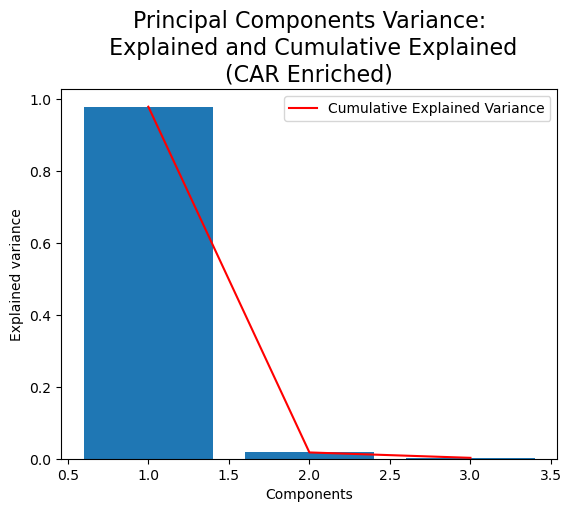

In [230]:
plt.bar(range(1,len(explained_variance3) + 1), explained_variance3)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(explained_variance3) + 1), explained_variance3,
         c = 'red',
         label = "Cumulative Explained Variance")
# Title
plt.title('Principal Components Variance:\n Explained and Cumulative Explained\n(CAR Enriched)', fontsize=16)
plt.legend(loc = 'best');

# PCA for Machine Learning Model

In [231]:
# Dropping columns 'Year' and 'Month' we don't need them. 
mldf2b_CAR = mldf2b_CAR.drop(['Year', 'Month'], axis=1).reset_index(drop=True)

In [232]:
scalar = StandardScaler()
  
# fitting
scalar.fit(mldf2b_CAR)
scaled_data = scalar.transform(mldf2b_CAR)
  

# Selecting 3 componets
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca3 = pca.transform(scaled_data)
  
x_pca3.shape

(384, 3)

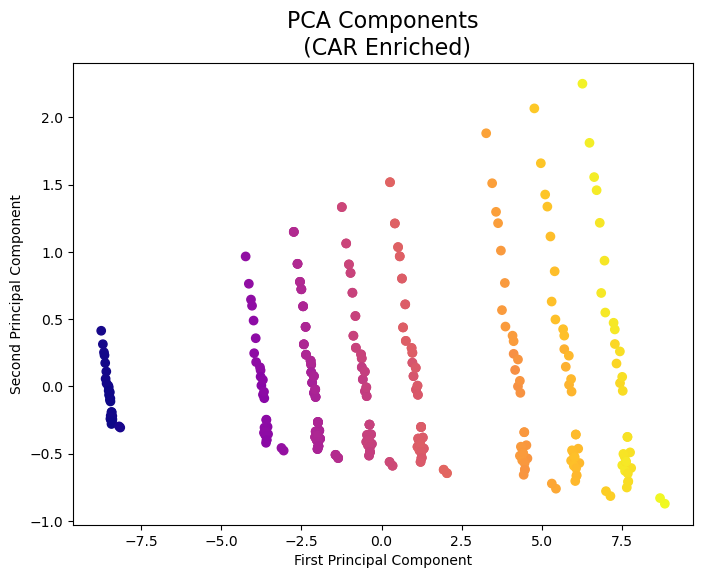

In [233]:
# giving a larger plot
plt.figure(figsize = (8, 6))
  
plt.scatter(x_pca3[:, 0], x_pca3[:, 1], c = mldf2b_CAR['IE_CAR'], cmap ='plasma')

# Title
plt.title('PCA Components\n (CAR Enriched)', fontsize=16)
  
# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component');

In [234]:
# Display components
pcaComponents3 = pca.components_, pca.explained_variance_ratio_
pcaComponents3

(array([[ 0.2373199 ,  0.23797147,  0.23676399,  0.23471383,  0.23776647,
          0.23740566,  0.23266717,  0.23655335,  0.23828255,  0.23723834,
          0.23538113,  0.23756514,  0.23729223,  0.23812996,  0.22142474,
          0.23370991,  0.23696313,  0.23494451],
        [ 0.1548794 ,  0.09386296,  0.18753781,  0.28698932,  0.12735812,
          0.03974957, -0.36381031,  0.01656165,  0.04395983,  0.16528384,
         -0.13080589,  0.13085598,  0.16667576,  0.07149099, -0.62308363,
         -0.32559062,  0.17965452, -0.27630021],
        [-0.07785565,  0.12160929, -0.01041309,  0.2737605 ,  0.07117094,
         -0.35156466, -0.26178384, -0.35546096,  0.00319884,  0.15516572,
         -0.53611123,  0.11688325,  0.1093496 ,  0.04356825,  0.44146963,
         -0.02077674,  0.12816526,  0.17256187]]),
 array([0.97712228, 0.01789817, 0.00241525]))

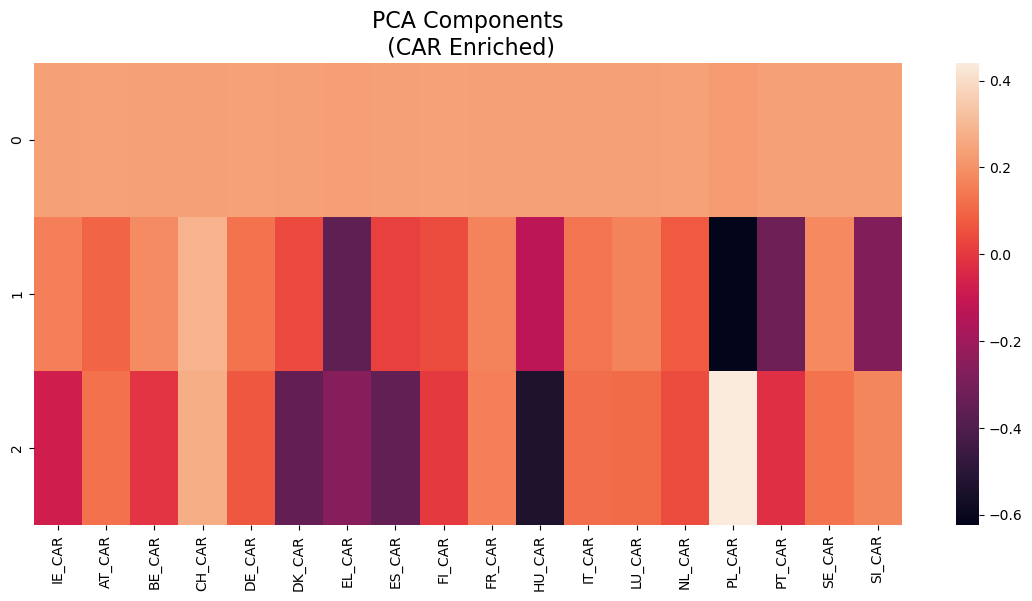

In [235]:
df_comp3 = pd.DataFrame(pca.components_, columns = mldf2b_CAR.columns)
  
plt.figure(figsize =(14, 6))

plt.title('PCA Components\n (CAR Enriched)', fontsize=16)
  
# plotting heatmap
sns.heatmap(df_comp3);

32246.552233072915
11863.333363450707
4677.995356119791
2352.612543878299
1705.912460059099
1315.889511364678
1046.8512422224662
881.2684538021622
771.7039700031956
682.1531757987967


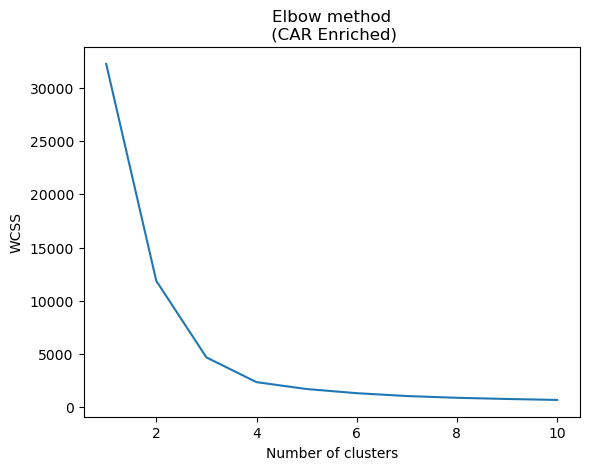

In [236]:
# Finding the optimum number of clusters for k-means classification
wcss3 = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss3.append(kmeans.inertia_)
    print(kmeans.inertia_)
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss3)
plt.title('Elbow method\n (CAR Enriched)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

## Silhouette Score

In [237]:
# Instantiate the KMeans models
km = KMeans(n_clusters=3, random_state=42)

# Fit the KMeans model
km.fit_predict(X)

# Calculate Silhoutte Score
silhouette_score3 = silhouette_score(X, km.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % silhouette_score3)

Silhouetter Score: 0.671


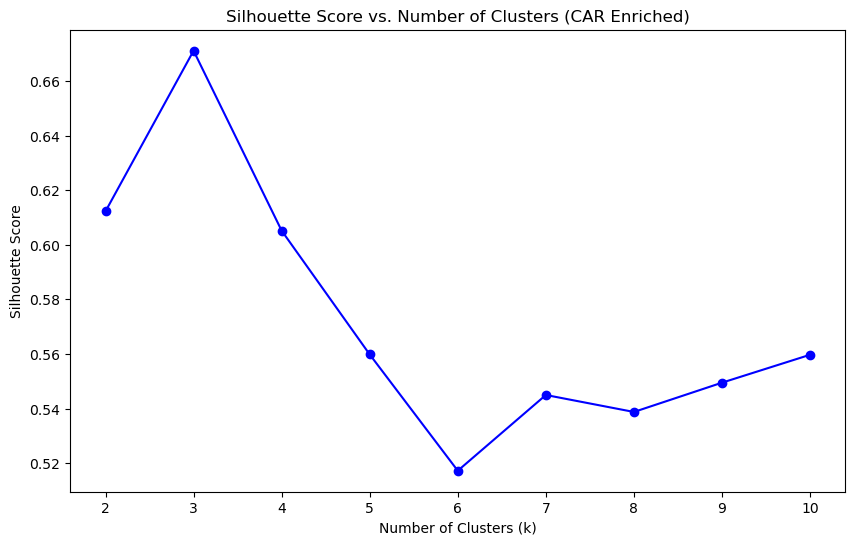

In [238]:
# Storing silhouette scores
silhouettescore3 = []

# Redifining X for later reproducibility

Xs3 =X

# Setting the range of clusters we want to test
k_values = range(2, 11)

# Calculating silhouette scores for each value of k
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels3 = km.fit_predict(Xs3)
    silhouettescore3.append(silhouette_score(Xs3, km_labels3, metric='euclidean'))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouettescore3, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (CAR Enriched)')


plt.show()

# BUS Enriched

In [239]:
mldf2b_BUS

Year  Month  IE_BUS  AT_BUS  BE_BUS  CH_BUS  DE_BUS  DK_BUS  EL_BUS  \
0    1990      1    1.03    0.99    0.95    0.33    0.82    1.02    2.92   
1    1990      2    0.92    0.88    0.85    0.30    0.73    0.90    2.59   
2    1990      3    0.81    0.77    0.74    0.26    0.64    0.79    2.27   
3    1990      4    1.26    1.21    1.17    0.41    1.00    1.24    3.56   
4    1990      5    0.69    0.66    0.64    0.22    0.55    0.68    1.94   
..    ...    ...     ...     ...     ...     ...     ...     ...     ...   
379  2021      8    0.39    0.27    0.25    0.18    0.14    0.21    0.37   
380  2021      9    1.69    1.17    1.07    0.77    0.62    0.92    1.60   
381  2021     10    1.17    0.81    0.74    0.53    0.43    0.64    1.11   
382  2021     11    0.91    0.63    0.57    0.41    0.34    0.50    0.86   
383  2021     12    1.04    0.72    0.66    0.47    0.38    0.57    0.98   

     ES_BUS  FI_BUS  FR_BUS  HU_BUS  IT_BUS  LU_BUS  NL_BUS  PL_BUS  PT_BUS  \
0      1.34    1.21    0.54    2.23    1.16    0.92    0.73    2.54    1.66   
1      1.19    1.08    0.48    1.98    1.03    0.82    0.65    2.26    1.47   
2      1.04    0.95    0.42    1.74    0.90    0.71    0.57    1.97    1.29   
3      1.64    1.49    0.66    2.73    1.42    1.12    0.89    3.10    2.02   
4      0.89    0.81    0.36    1.49    0.77    0.61    0.49    1.69    1.10   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
379    0.22    0.25    0.15    0.43    0.38    0.31    0.07    0.23    0.17   
380    0.95    1.08    0.64    1.86    1.66    1.33    0.30    1.01    0.74   
381    0.66    0.75    0.44    1.29    1.15    0.92    0.21    0.70    0.51   
382    0.51    0.58    0.34    1.00    0.90    0.71    0.16    0.55    0.40   
383    0.58    0.66    0.39    1.14    1.02    0.82    0.18    0.62    0.46   

     SE_BUS  SI_BUS  
0      0.85    2.75  
1      0.76    2.45  
2      0.67    2.14  
3      1.04    3.37  
4      0.57    1.84  
..      ...     ...  
379    0.25    0.25  
380    1.08    1.07  
381    0.75    0.74  
382    0.58    0.57  
383    0.66    0.66  

[384 rows x 20 columns]

In [240]:
# distributing the dataset into two components X and Y
X = mldf2b_BUS.iloc[:, 2:].values
y = mldf2b_BUS.iloc[:, 1].values

In [241]:
# Splitting the X and Y into the Training set and Testing set

# Split the data set into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [242]:
# performing preprocessing part

# Create and initialise an object (sc) by calling a method named as StandardScaler()
sc = StandardScaler()

# Train the model by calling a method fit_transform()
X_train = sc.fit_transform(X_train)

# Transform the data into standised form
X_test = sc.transform(X_test)

In [243]:
# Applying PCA function on training and testing set of X component
# Create and initialise an object (pca) by calling a method PCA
pca = PCA(n_components = 3)

# Transform the data into traning and testing
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
# Store the explauned variance
explained_variance4 = pca.explained_variance_ratio_

print(explained_variance4)

[0.78418364 0.14665355 0.02593078]


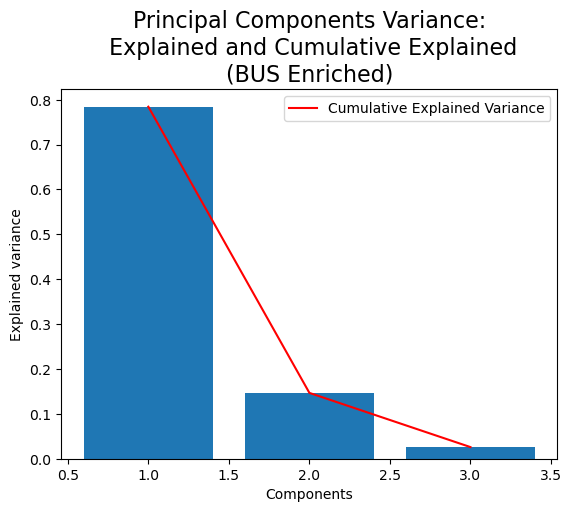

In [244]:
plt.bar(range(1,len(explained_variance4) + 1), explained_variance4)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(explained_variance4) + 1), explained_variance4,
         c = 'red',
         label = "Cumulative Explained Variance")
# Title
plt.title('Principal Components Variance:\n Explained and Cumulative Explained\n(BUS Enriched)', fontsize=16)
plt.legend(loc = 'best');

In [245]:
# Dropping columns 'Year' and 'Month' we don't need them. 
mldf2b_BUS = mldf2b_BUS.drop(['Year', 'Month'], axis=1).reset_index(drop=True)

In [246]:
scalar = StandardScaler()
  
# fitting
scalar.fit(mldf2b_BUS)
scaled_data = scalar.transform(mldf2b_BUS)
  

# Selecting 3 componets
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca4 = pca.transform(scaled_data)
  
x_pca4.shape

(384, 3)

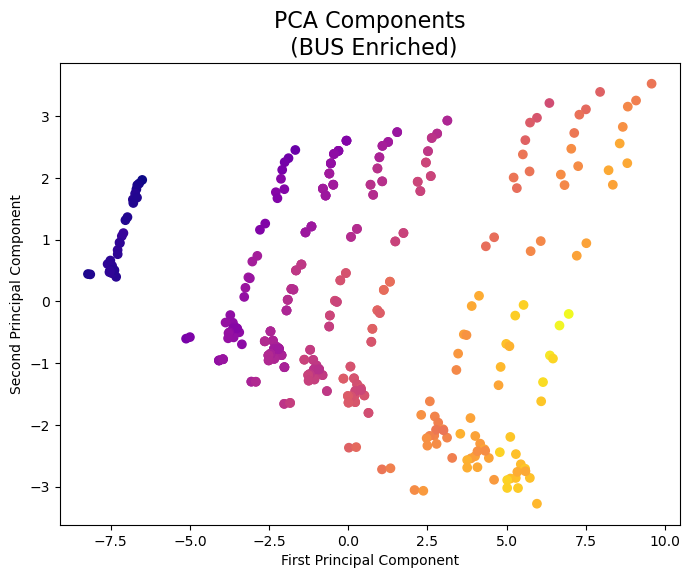

In [247]:
# giving a larger plot
plt.figure(figsize = (8, 6))
  
plt.scatter(x_pca4[:, 0], x_pca4[:, 1], c = mldf2b_BUS['IE_BUS'], cmap ='plasma')

# Title
plt.title('PCA Components\n (BUS Enriched)', fontsize=16)
  
# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component');

In [248]:
# Display components
pcaComponents4 = pca.components_, pca.explained_variance_ratio_
pcaComponents4

(array([[ 0.23654942,  0.26016196,  0.23331453,  0.19105716,  0.25915159,
          0.24142709,  0.24001212,  0.22626815,  0.26320996,  0.24554495,
          0.25990243,  0.24291085,  0.22617081,  0.21012941,  0.22186532,
          0.19130463,  0.25806638,  0.21752618],
        [-0.25177889, -0.09584168, -0.21302573, -0.40771092, -0.03328676,
          0.1494591 ,  0.2604446 ,  0.0738004 ,  0.05132845, -0.17714244,
         -0.04384102, -0.2142183 , -0.30736211,  0.35897769,  0.23420226,
          0.40569537, -0.01336365,  0.30709876],
        [ 0.11420625,  0.02863921,  0.2694783 , -0.17287237, -0.21065991,
          0.34980005,  0.02391188,  0.65062198, -0.03971104, -0.26015213,
          0.18719984, -0.05606692, -0.14509923, -0.04205633, -0.21174018,
         -0.08236525, -0.14978316, -0.29781886]]),
 array([0.78346379, 0.14775425, 0.02598322]))

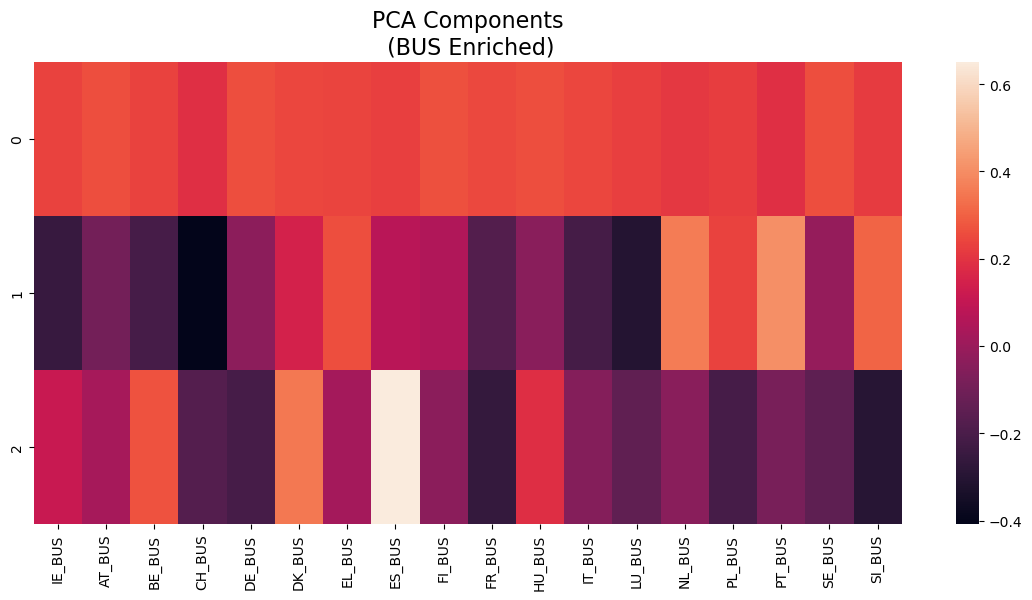

In [249]:
df_comp4 = pd.DataFrame(pca.components_, columns = mldf2b_BUS.columns)
  
plt.figure(figsize =(14, 6))

# Title
plt.title('PCA Components\n (BUS Enriched)', fontsize=16)
  
# plotting heatmap
sns.heatmap(df_comp4);

1251.8184526041666
608.1439848767432
440.3549491071429
325.149836375489
240.5692456442577
204.81287222446161
180.3209515835266
157.48890033290556
146.84482326469887
136.59947170388614


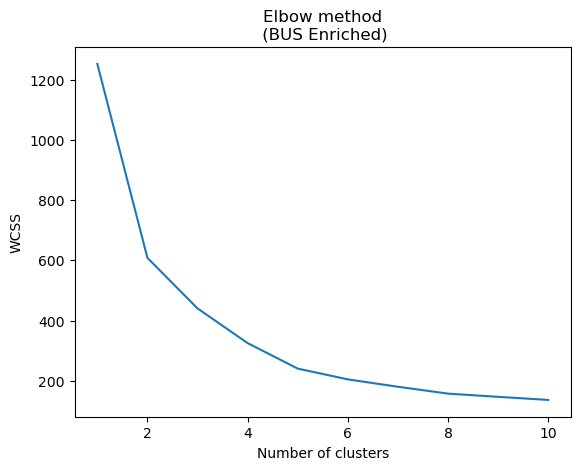

In [250]:
# Finding the optimum number of clusters for k-means classification
wcss4 = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss4.append(kmeans.inertia_)
    print(kmeans.inertia_)
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss4)
plt.title('Elbow method\n (BUS Enriched)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

In [251]:

# Instantiate the KMeans models
km = KMeans(n_clusters=3, random_state=42)

# Fit the KMeans model
km.fit_predict(X)

# Calculate Silhoutte Score
silhouette_score4 = silhouette_score(X, km.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % silhouette_score4)

Silhouetter Score: 0.328


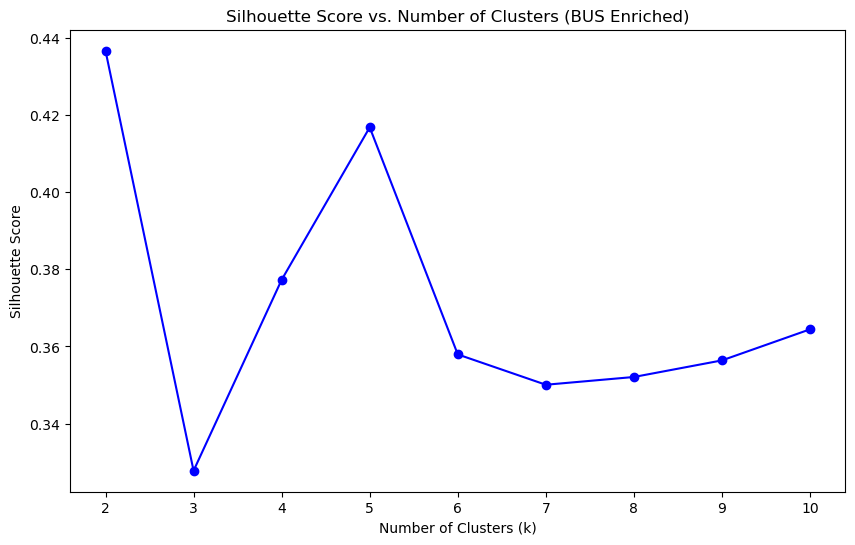

In [252]:
# Storing silhouette scores
silhouettescore4 = []

# Redifining X for later reproducibility

Xs4 =X

# Setting the range of clusters we want to test
k_values = range(2, 11)

# Calculating silhouette scores for each value of k
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels4 = km.fit_predict(Xs4)
    silhouettescore4.append(silhouette_score(Xs4, km_labels4, metric='euclidean'))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouettescore4, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (BUS Enriched)')


plt.show()

# TRN Enriched

In [253]:
mldf2b_TRN

Year  Month  IE_TRN  AT_TRN  BE_TRN  CH_TRN  DE_TRN  DK_TRN  EL_TRN  \
0    1990      1    0.32    1.07    0.55    1.28    0.49    0.57    0.32   
1    1990      2    0.29    0.95    0.49    1.14    0.43    0.50    0.29   
2    1990      3    0.25    0.83    0.43    0.99    0.38    0.44    0.25   
3    1990      4    0.40    1.31    0.67    1.56    0.59    0.69    0.40   
4    1990      5    0.22    0.71    0.37    0.85    0.32    0.38    0.22   
..    ...    ...     ...     ...     ...     ...     ...     ...     ...   
379  2021      8    0.04    0.29    0.19    0.44    0.20    0.19    0.02   
380  2021      9    0.18    1.27    0.81    1.90    0.84    0.81    0.08   
381  2021     10    0.13    0.88    0.56    1.31    0.58    0.56    0.05   
382  2021     11    0.10    0.69    0.43    1.02    0.46    0.43    0.04   
383  2021     12    0.11    0.78    0.50    1.17    0.52    0.50    0.05   

     ES_TRN  FI_TRN  FR_TRN  HU_TRN  IT_TRN  LU_TRN  NL_TRN  PL_TRN  PT_TRN  \
0      0.62    0.48    0.84    1.32    0.62    0.40    0.62    2.75    0.91   
1      0.55    0.42    0.74    1.18    0.55    0.35    0.55    2.44    0.81   
2      0.48    0.37    0.65    1.03    0.48    0.31    0.48    2.14    0.71   
3      0.76    0.58    1.02    1.62    0.76    0.48    0.76    3.35    1.11   
4      0.41    0.32    0.56    0.88    0.41    0.26    0.41    1.83    0.61   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
379    0.16    0.12    0.27    0.19    0.13    0.10    0.25    0.18    0.09   
380    0.69    0.52    1.18    0.83    0.57    0.46    1.09    0.77    0.38   
381    0.48    0.36    0.82    0.58    0.40    0.32    0.76    0.53    0.26   
382    0.37    0.28    0.64    0.45    0.31    0.25    0.59    0.41    0.20   
383    0.42    0.32    0.73    0.51    0.35    0.28    0.67    0.47    0.23   

     SE_TRN  SI_TRN  
0      0.58    0.60  
1      0.52    0.54  
2      0.46    0.47  
3      0.71    0.74  
4      0.39    0.40  
..      ...     ...  
379    0.22    0.05  
380    0.98    0.23  
381    0.67    0.16  
382    0.53    0.13  
383    0.60    0.14  

[384 rows x 20 columns]

In [254]:
# distributing the dataset into two components X and Y
X = mldf2b_TRN.iloc[:, 2:].values
y = mldf2b_TRN.iloc[:, 1].values

In [255]:
# Split the data set into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [256]:
# Create and initialise an object (sc) by calling a method named as StandardScaler()
sc = StandardScaler()

# Train the model by calling a method fit_transform()
X_train = sc.fit_transform(X_train)

# Transform the data into standised form
X_test = sc.transform(X_test)

In [257]:
# Applying PCA function on training and testing set of X component
# Create and initialise an object (pca) by calling a method PCA
pca = PCA(n_components = 3)

# Transform the data into traning and testing
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
# Store the explauned variance
explained_variance5 = pca.explained_variance_ratio_

print(explained_variance5)

[0.76860845 0.16637195 0.02241525]


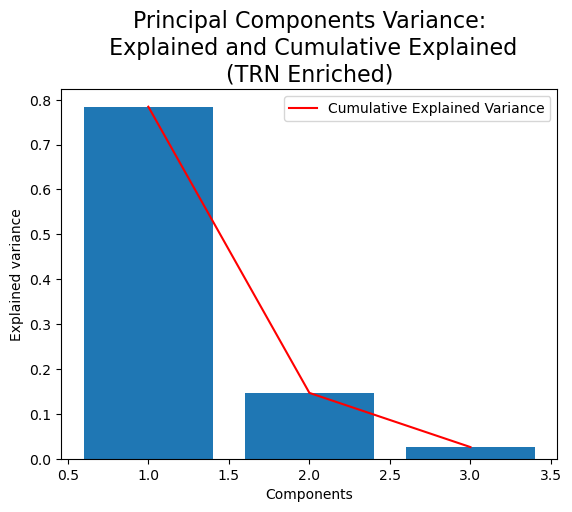

In [258]:
plt.bar(range(1,len(explained_variance5) + 1), explained_variance4)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(explained_variance5) + 1), explained_variance4,
         c = 'red',
         label = "Cumulative Explained Variance")
# Title
plt.title('Principal Components Variance:\n Explained and Cumulative Explained\n(TRN Enriched)', fontsize=16)
plt.legend(loc = 'best');

In [259]:
# Dropping columns 'Year' and 'Month' we don't need them. 
mldf2b_TRN = mldf2b_TRN.drop(['Year', 'Month'], axis=1).reset_index(drop=True)

In [260]:
scalar = StandardScaler()
  
# fitting
scalar.fit(mldf2b_TRN)
scaled_data = scalar.transform(mldf2b_TRN)
  

# Selecting 3 componets
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca5 = pca.transform(scaled_data)
  
x_pca5.shape

(384, 3)

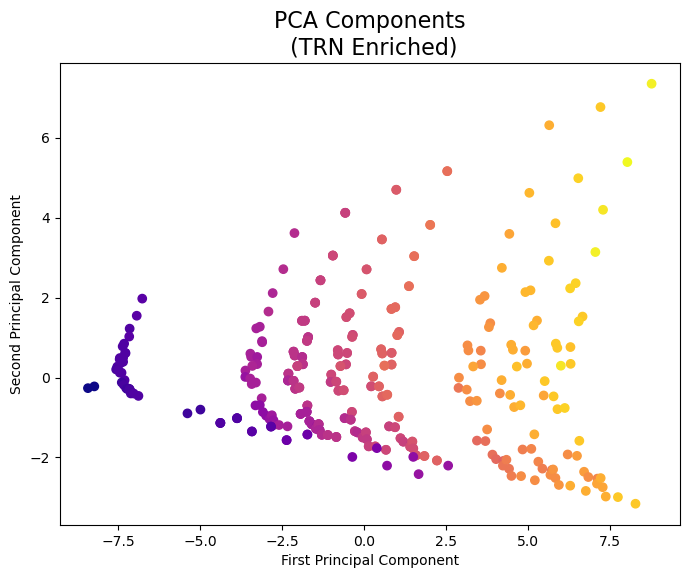

In [261]:
# giving a larger plot
plt.figure(figsize = (8, 6))
  
plt.scatter(x_pca5[:, 0], x_pca5[:, 1], c = mldf2b_TRN['IE_TRN'], cmap ='plasma')

# Title
plt.title('PCA Components\n (TRN Enriched)', fontsize=16)
  
# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component');

In [262]:
# Display components
pcaComponents5 = pca.components_, pca.explained_variance_ratio_
pcaComponents5

(array([[ 0.25337808,  0.26079834,  0.25009986,  0.24776478,  0.25451335,
          0.23983935,  0.1531432 ,  0.24590846,  0.26642228,  0.25749292,
          0.23411734,  0.26679862,  0.25488702,  0.24724274,  0.15030341,
          0.19259839,  0.2258513 ,  0.19379469],
        [ 0.11260359, -0.03800363, -0.18491121, -0.19957359, -0.17125468,
         -0.18118917,  0.45645636, -0.02864518, -0.0420973 , -0.13138205,
          0.19289837,  0.01319012,  0.03104597, -0.20405916,  0.45625386,
          0.37101125, -0.28773475,  0.33599754],
        [ 0.23282259, -0.32109368, -0.03651919, -0.10513443,  0.04131906,
          0.44005827,  0.03731368, -0.33115248, -0.0467158 ,  0.00181801,
          0.5453599 ,  0.0399704 , -0.0777413 , -0.02081207, -0.22414965,
         -0.32386697, -0.12154316,  0.2151966 ]]),
 array([0.76705927, 0.16934531, 0.02197171]))

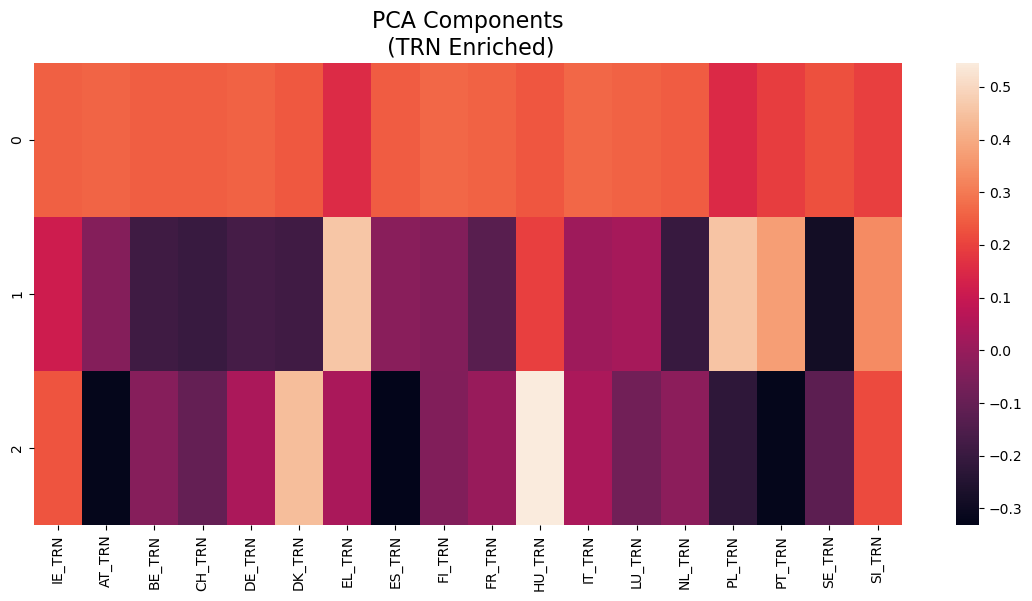

In [263]:
df_comp5 = pd.DataFrame(pca.components_, columns = mldf2b_TRN.columns)
  
plt.figure(figsize =(14, 6))

# Title
plt.title('PCA Components\n (TRN Enriched)', fontsize=16)
  
# plotting heatmap
sns.heatmap(df_comp5);

489.19756536458334
271.7538144741314
200.49989755658436
136.9451476746219
112.0351746026144
88.31280208913896
73.00795060708111
63.23808442006093
55.80794841414018
50.214458651248044


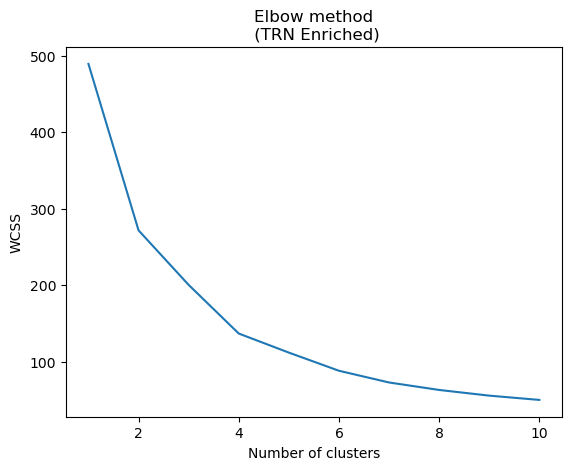

In [264]:
# Finding the optimum number of clusters for k-means classification
wcss5 = []                  # Declare an array

# Set the loop from the minimum and maximum values
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss5.append(kmeans.inertia_)
    print(kmeans.inertia_)
# inertia_float: Sum of squared distances of samples to their closest cluster center.

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss5)
plt.title('Elbow method\n (TRN Enriched)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')    # within cluster sum of squares
plt.show()

In [265]:
# Instantiate the KMeans models
km = KMeans(n_clusters=3, random_state=42)

# Fit the KMeans model
km.fit_predict(X)

# Calculate Silhoutte Score
silhouette_score5 = silhouette_score(X, km.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % silhouette_score5)

Silhouetter Score: 0.441


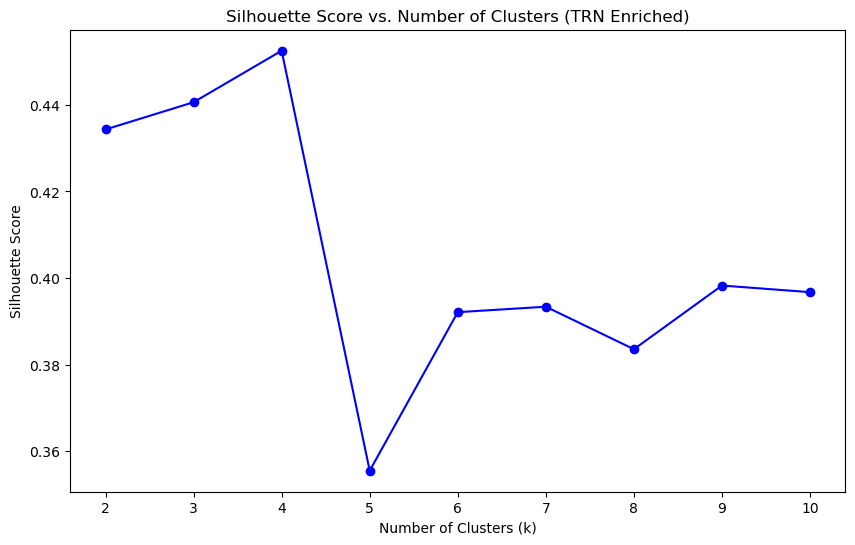

In [266]:
# Storing silhouette scores
silhouettescore5 = []

# Redifining X for later reproducibility

Xs5 =X

# Setting the range of clusters we want to test
k_values = range(2, 11)

# Calculating silhouette scores for each value of k
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels5 = km.fit_predict(Xs5)
    silhouettescore5.append(silhouette_score(Xs5, km_labels5, metric='euclidean'))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouettescore5, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (TRN Enriched)')


plt.show()

# Summarising results: 

## PCA variance results:
*Principal Component Analysis* (PCA) is by far the most popular dimensionality reduction algorithm. We are projecting results in three bars, always the left bar preserves the maximum variance, while the other two have less variance. It seems logic to select the bar that preserves the maximum amount of variance, as it will likely lose less information than the other projections.<br>
**Source:** Aurelien-Geron-Hands-On-Machine-Learning page 222, Chapter 8: Dimensionality Reduction.

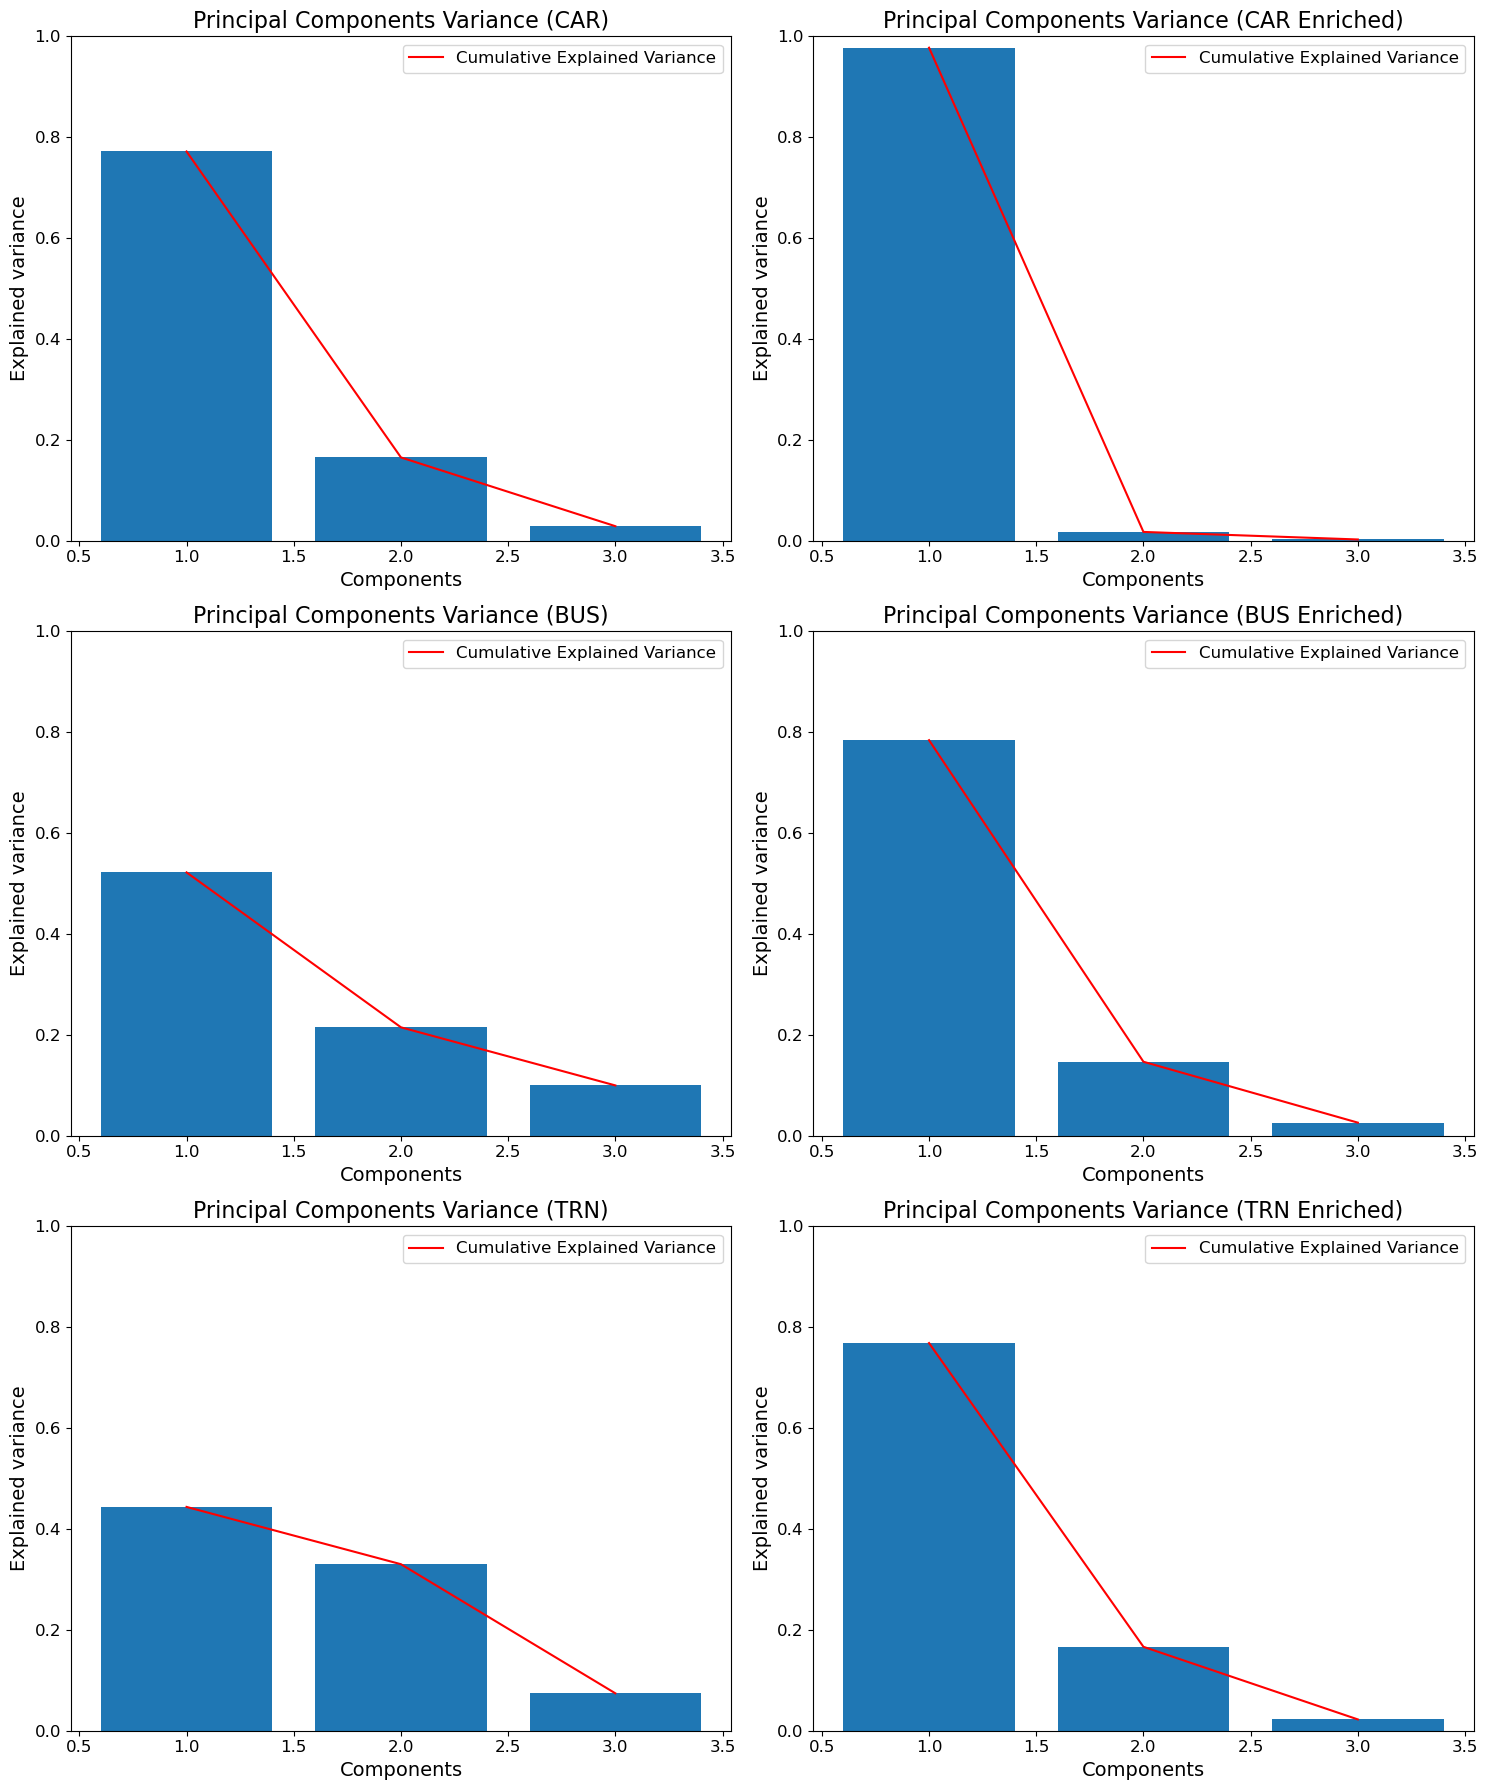

In [267]:
# Plotting 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot 1
axes[0, 0].bar(range(1, len(explained_variance) + 1), explained_variance)
axes[0, 0].plot(range(1, len(explained_variance) + 1), explained_variance,
               c='red', label="Cumulative Explained Variance")
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_ylabel('Explained variance', fontsize=14)
axes[0, 0].set_xlabel('Components', fontsize=14)
axes[0, 0].set_title('Principal Components Variance (CAR)', fontsize=16)
axes[0, 0].tick_params(axis='both', labelsize=12)
axes[0, 0].legend(loc='best', fontsize=12)


# Plot 2
axes[0, 1].bar(range(1, len(explained_variance3) + 1), explained_variance3)
axes[0, 1].plot(range(1, len(explained_variance3) + 1), explained_variance3,
               c='red', label="Cumulative Explained Variance")
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_ylabel('Explained variance', fontsize=14)
axes[0, 1].set_xlabel('Components', fontsize=14)
axes[0, 1].set_title('Principal Components Variance (CAR Enriched)', fontsize=16)
axes[0, 1].tick_params(axis='both', labelsize=12)
axes[0, 1].legend(loc='best', fontsize=12)

# Plot 3
axes[1, 0].bar(range(1, len(explained_variance1) + 1), explained_variance1)
axes[1, 0].plot(range(1, len(explained_variance1) + 1), explained_variance1,
               c='red', label="Cumulative Explained Variance")
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_ylabel('Explained variance', fontsize=14)
axes[1, 0].set_xlabel('Components', fontsize=14)
axes[1, 0].set_title('Principal Components Variance (BUS)', fontsize=16)
axes[1, 0].tick_params(axis='both', labelsize=12)
axes[1, 0].legend(loc='best', fontsize=12)

# Plot 4
axes[1, 1].bar(range(1, len(explained_variance4) + 1), explained_variance4)
axes[1, 1].plot(range(1, len(explained_variance4) + 1), explained_variance4,
               c='red', label="Cumulative Explained Variance")
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_ylabel('Explained variance', fontsize=14)
axes[1, 1].set_xlabel('Components', fontsize=14)
axes[1, 1].set_title('Principal Components Variance (BUS Enriched)', fontsize=16)
axes[1, 1].tick_params(axis='both', labelsize=12)
axes[1, 1].legend(loc='best', fontsize=12)

# Plot 5
axes[2, 0].bar(range(1, len(explained_variance2) + 1), explained_variance2)
axes[2, 0].plot(range(1, len(explained_variance2) + 1), explained_variance2,
               c='red', label="Cumulative Explained Variance")
axes[2, 0].set_ylim(0, 1)
axes[2, 0].set_ylabel('Explained variance', fontsize=14)
axes[2, 0].set_xlabel('Components', fontsize=14)
axes[2, 0].set_title('Principal Components Variance (TRN)', fontsize=16)
axes[2, 0].tick_params(axis='both', labelsize=12)
axes[2, 0].legend(loc='best', fontsize=12)

# Plot 6
axes[2, 1].bar(range(1, len(explained_variance5) + 1), explained_variance5)
axes[2, 1].plot(range(1, len(explained_variance5) + 1), explained_variance5,
               c='red', label="Cumulative Explained Variance")
axes[2, 1].set_ylim(0, 1)
axes[2, 1].set_ylabel('Explained variance', fontsize=14)
axes[2, 1].set_xlabel('Components', fontsize=14)
axes[2, 1].set_title('Principal Components Variance (TRN Enriched)', fontsize=16)
axes[2, 1].tick_params(axis='both', labelsize=12)
axes[2, 1].legend(loc='best', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

In [268]:
print('PCV CAR:',explained_variance)
print('PCV CAR Enriched:',explained_variance3)
print('PCV BUS:',explained_variance2)
print('PCV BUS Enriched:',explained_variance4)
print('PCV TRN:',explained_variance2)
print('PCV TRN Enriched:',explained_variance5)

PCV CAR: [0.77171509 0.16514322 0.02878059]
PCV CAR Enriched: [0.97747751 0.0174295  0.00246979]
PCV BUS: [0.44371637 0.33012741 0.07419443]
PCV BUS Enriched: [0.78418364 0.14665355 0.02593078]
PCV TRN: [0.44371637 0.33012741 0.07419443]
PCV TRN Enriched: [0.76860845 0.16637195 0.02241525]


## PCA Components scatter plot and heat map

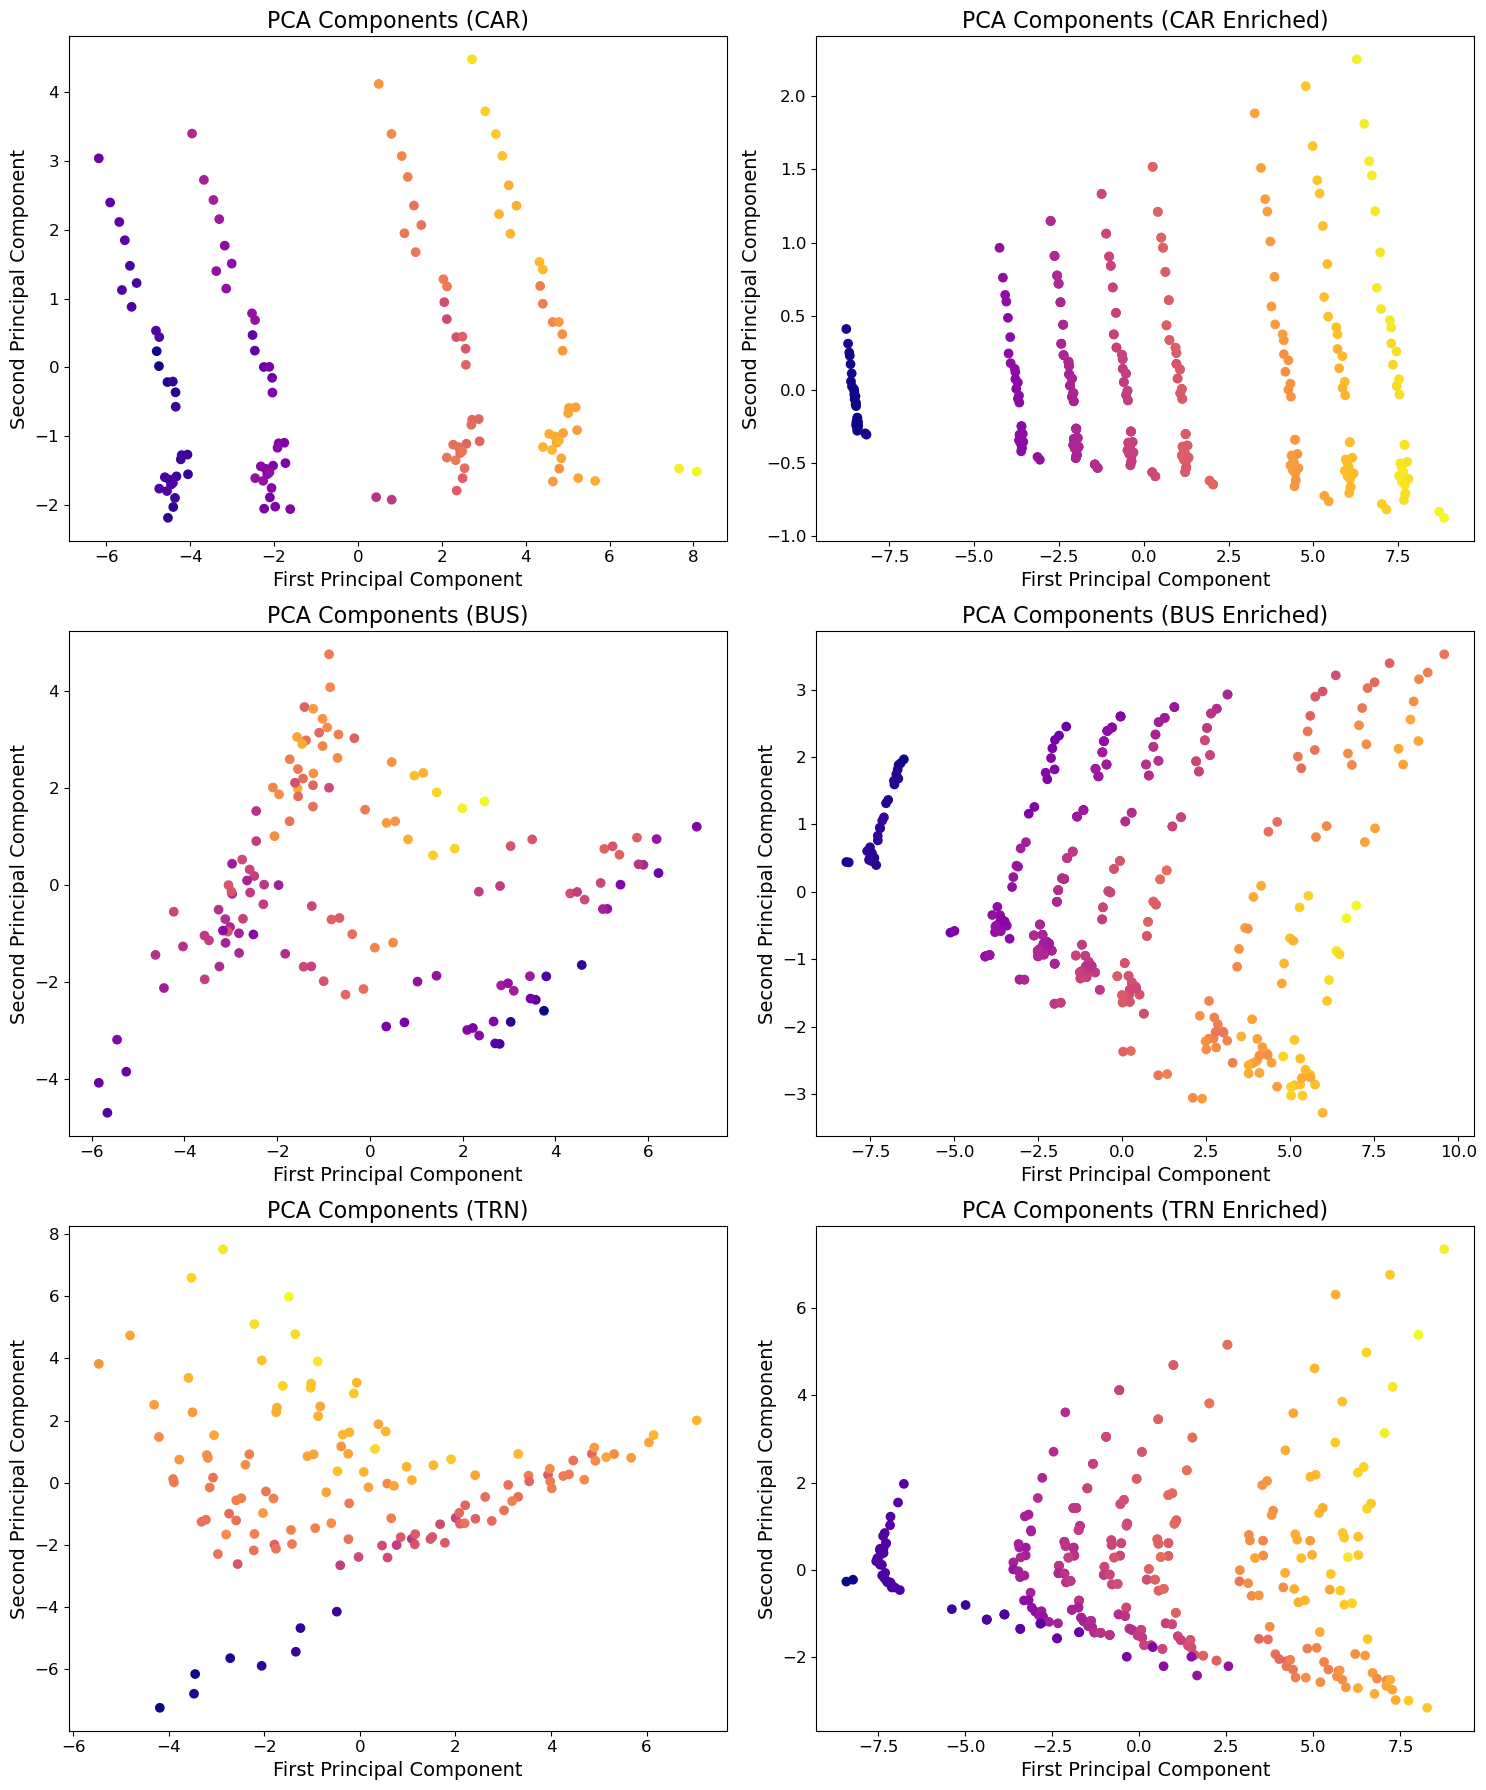

In [269]:
# Plot 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot 1
axes[0, 0].scatter(x_pca[:, 0], x_pca[:, 1], c=mldf2_CAR1['IE_CAR'], cmap='plasma')
axes[0, 0].set_title('PCA Components (CAR)', fontsize=16)
axes[0, 0].set_xlabel('First Principal Component', fontsize=14)
axes[0, 0].set_ylabel('Second Principal Component', fontsize=14)
axes[0, 0].tick_params(axis='both', labelsize=12)

# Plot 2
axes[0, 1].scatter(x_pca3[:, 0], x_pca3[:, 1], c=mldf2b_CAR['IE_CAR'], cmap='plasma')
axes[0, 1].set_title('PCA Components (CAR Enriched)', fontsize=16)
axes[0, 1].set_xlabel('First Principal Component', fontsize=14)
axes[0, 1].set_ylabel('Second Principal Component', fontsize=14)
axes[0, 1].tick_params(axis='both', labelsize=12)

# Plot 3
axes[1, 0].scatter(x_pca1[:, 0], x_pca1[:, 1], c=mldf2_BUS1['IE_BUS'], cmap='plasma')
axes[1, 0].set_title('PCA Components (BUS)', fontsize=16)
axes[1, 0].set_xlabel('First Principal Component', fontsize=14)
axes[1, 0].set_ylabel('Second Principal Component', fontsize=14)
axes[1, 0].tick_params(axis='both', labelsize=12)

# Plot 4
axes[1, 1].scatter(x_pca4[:, 0], x_pca4[:, 1], c=mldf2b_BUS['IE_BUS'], cmap='plasma')
axes[1, 1].set_title('PCA Components (BUS Enriched)', fontsize=16)
axes[1, 1].set_xlabel('First Principal Component', fontsize=14)
axes[1, 1].set_ylabel('Second Principal Component', fontsize=14)
axes[1, 1].tick_params(axis='both', labelsize=12)

# Plot 5
axes[2, 0].scatter(x_pca2[:, 0], x_pca2[:, 1], c=mldf2_TRN1['IE_TRN'], cmap='plasma')
axes[2, 0].set_title('PCA Components (TRN)', fontsize=16)
axes[2, 0].set_xlabel('First Principal Component', fontsize=14)
axes[2, 0].set_ylabel('Second Principal Component', fontsize=14)
axes[2, 0].tick_params(axis='both', labelsize=12)

# Plot 6
axes[2, 1].scatter(x_pca5[:, 0], x_pca5[:, 1], c=mldf2b_TRN['IE_TRN'], cmap='plasma')
axes[2, 1].set_title('PCA Components (TRN Enriched)', fontsize=16)
axes[2, 1].set_xlabel('First Principal Component', fontsize=14)
axes[2, 1].set_ylabel('Second Principal Component', fontsize=14)
axes[2, 1].tick_params(axis='both', labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()


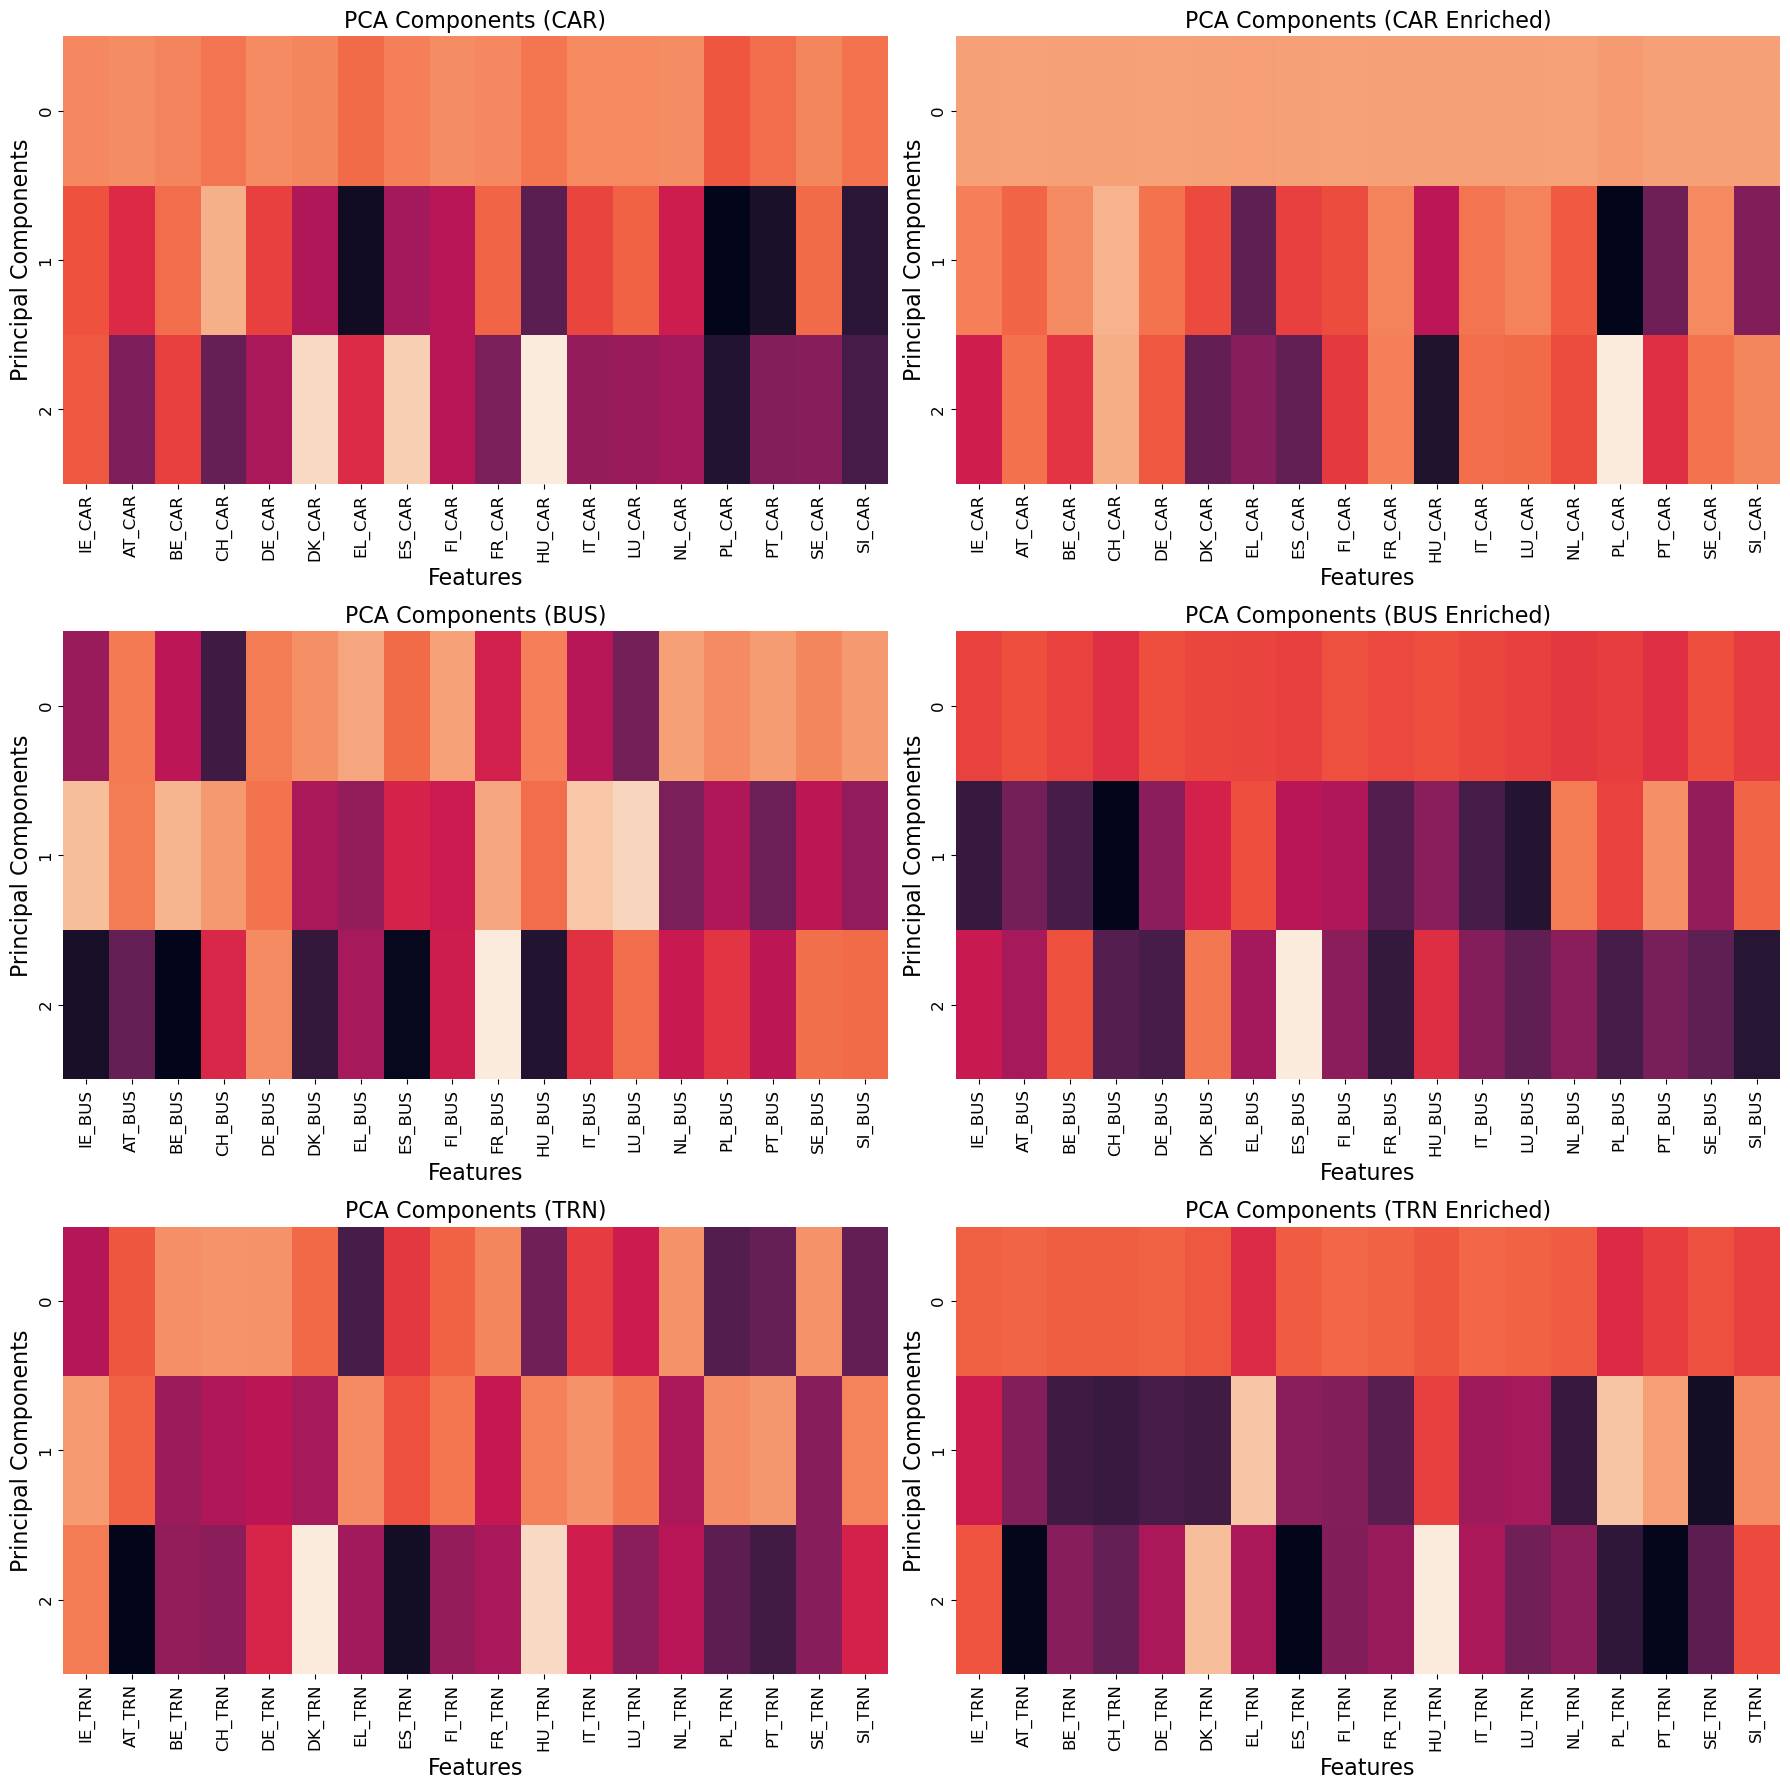

In [270]:
# Plotting 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Plot 1
sns.heatmap(df_comp, ax=axes[0, 0], cbar=False)
axes[0, 0].set_title('PCA Components (CAR)', fontsize=16)
axes[0, 0].set_xlabel('Features', fontsize=16)
axes[0, 0].set_ylabel('Principal Components', fontsize=16)
axes[0, 0].tick_params(axis='both', labelsize=12)

# Plot 2
sns.heatmap(df_comp3, ax=axes[0, 1], cbar=False)
axes[0, 1].set_title('PCA Components (CAR Enriched)', fontsize=16)
axes[0, 1].set_xlabel('Features', fontsize=16)
axes[0, 1].set_ylabel('Principal Components', fontsize=16)
axes[0, 1].tick_params(axis='both', labelsize=12)

# Plot 3
sns.heatmap(df_comp1, ax=axes[1, 0], cbar=False)
axes[1, 0].set_title('PCA Components (BUS)', fontsize=16)
axes[1, 0].set_xlabel('Features', fontsize=16)
axes[1, 0].set_ylabel('Principal Components', fontsize=16)
axes[1, 0].tick_params(axis='both', labelsize=12)

# Plot 4
sns.heatmap(df_comp4, ax=axes[1, 1], cbar=False)
axes[1, 1].set_title('PCA Components (BUS Enriched)', fontsize=16)
axes[1, 1].set_xlabel('Features', fontsize=16)
axes[1, 1].set_ylabel('Principal Components', fontsize=16)
axes[1, 1].tick_params(axis='both', labelsize=12)

# Plot 5
sns.heatmap(df_comp2, ax=axes[2, 0], cbar=False)
axes[2, 0].set_title('PCA Components (TRN)', fontsize=16)
axes[2, 0].set_xlabel('Features', fontsize=16)
axes[2, 0].set_ylabel('Principal Components', fontsize=16)
axes[2, 0].tick_params(axis='both', labelsize=12)

# Plot 6
sns.heatmap(df_comp5, ax=axes[2, 1], cbar=False)
axes[2, 1].set_title('PCA Components (TRN Enriched)', fontsize=16)
axes[2, 1].set_xlabel('Features', fontsize=16)
axes[2, 1].set_ylabel('Principal Components', fontsize=16)
axes[2, 1].tick_params(axis='both', labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()


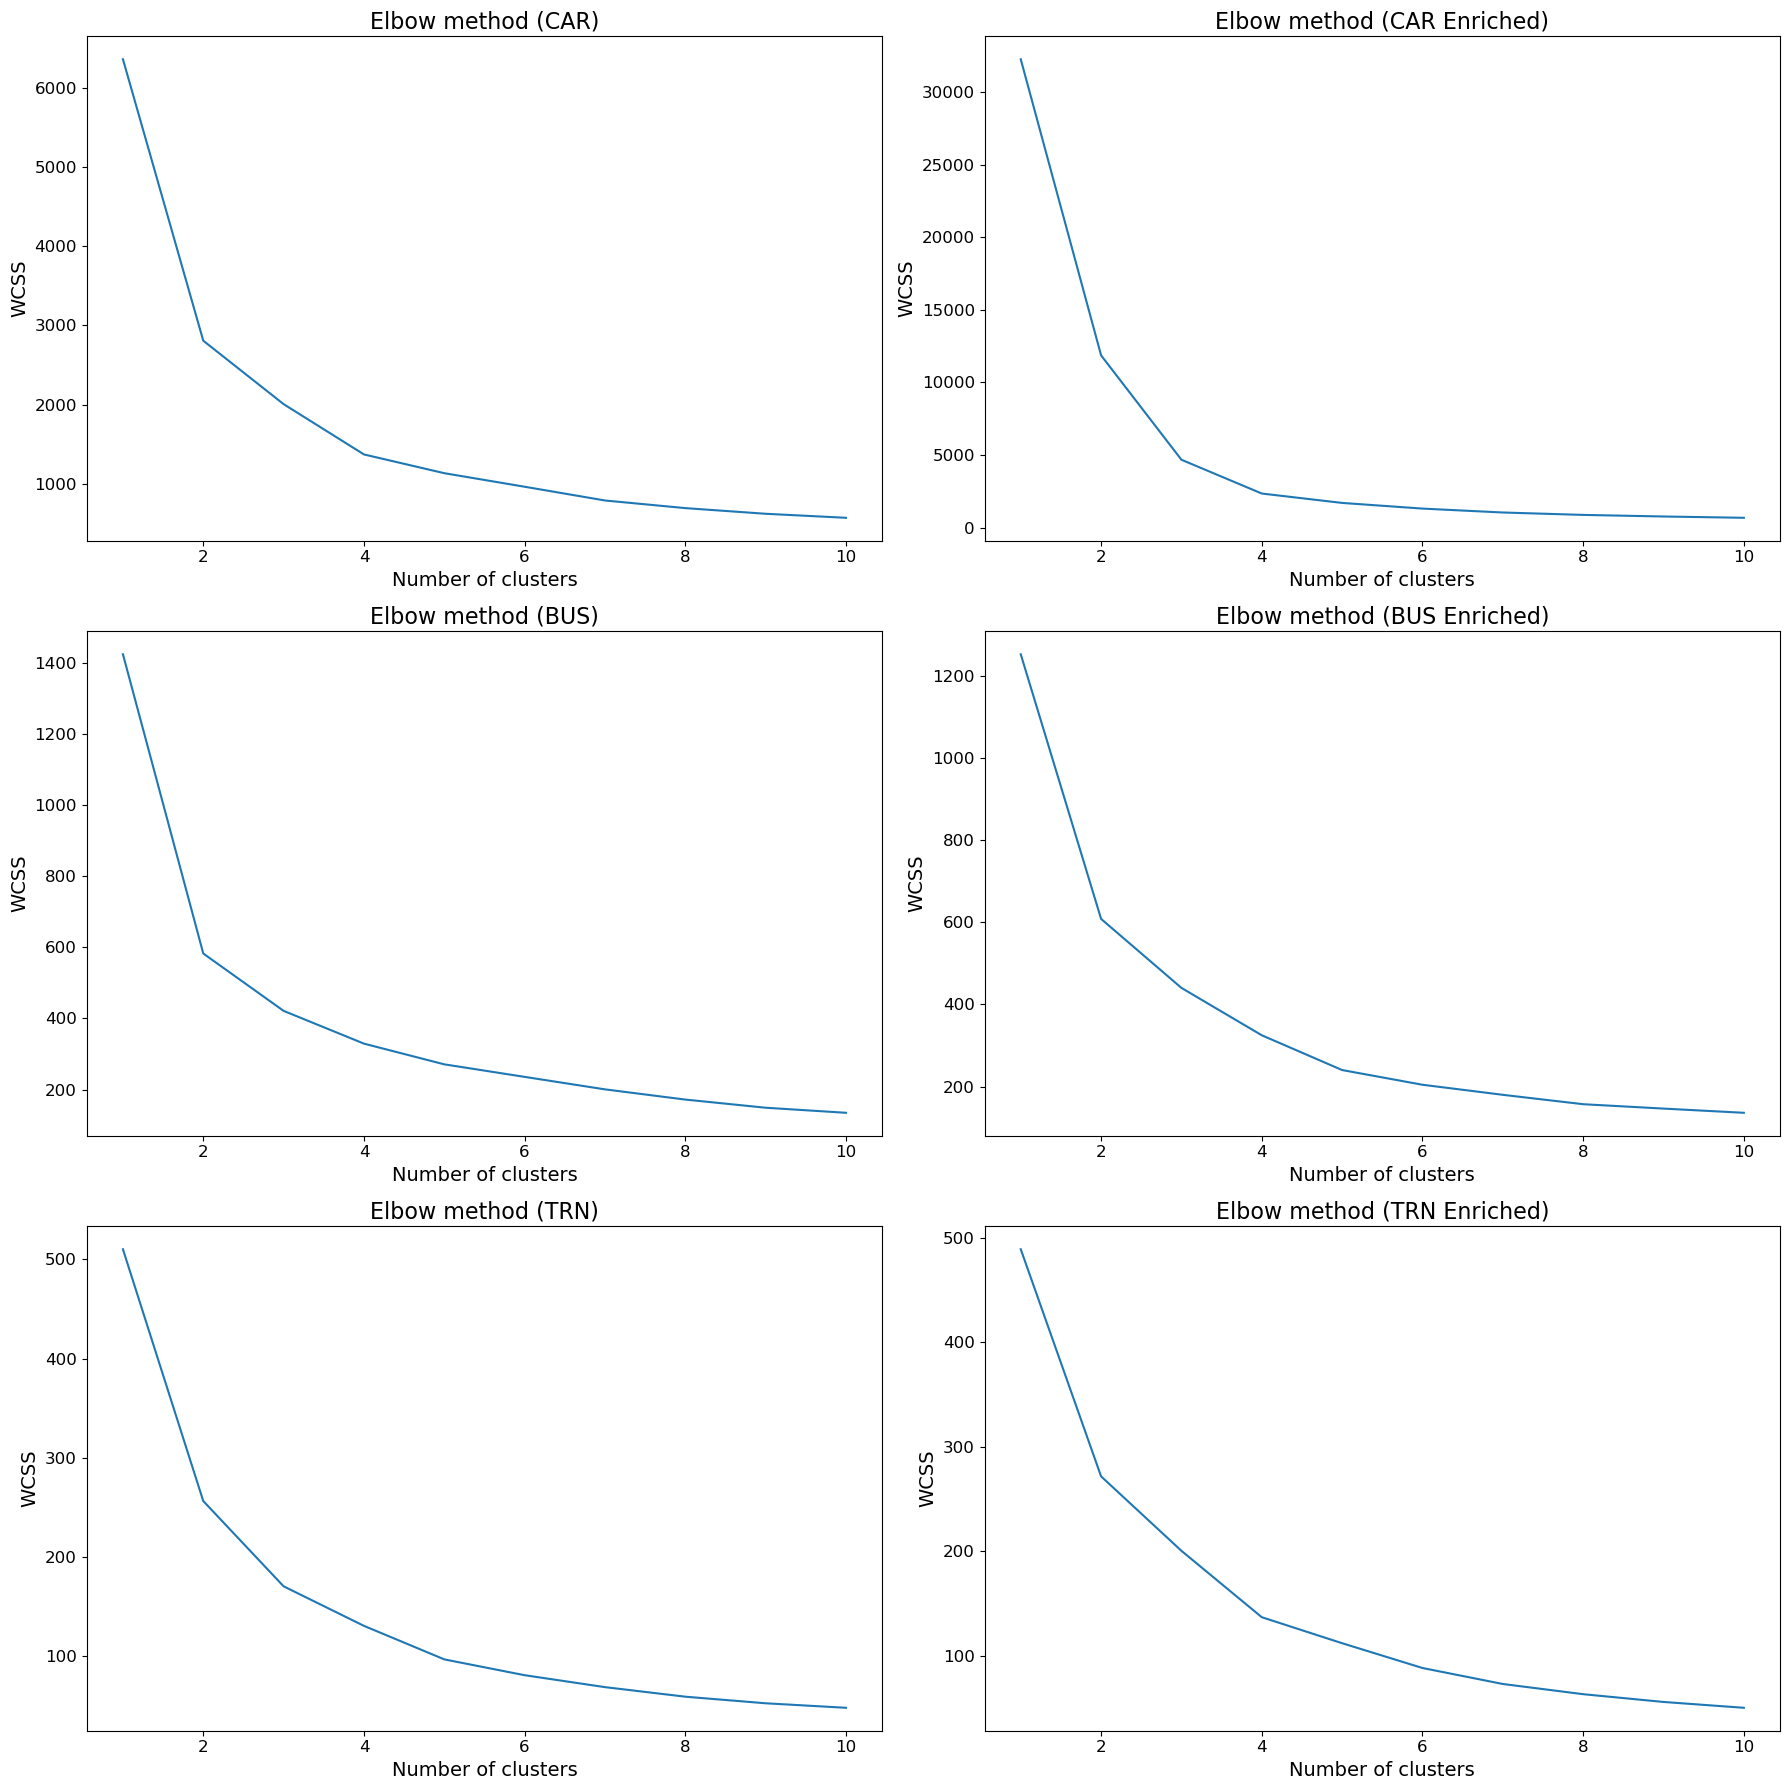

In [271]:
# Plotting 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Plot 1
axes[0, 0].plot(range(1, 11), wcss)
axes[0, 0].set_title('Elbow method (CAR)', fontsize=16)
axes[0, 0].set_xlabel('Number of clusters', fontsize=14)
axes[0, 0].set_ylabel('WCSS', fontsize=14)  # within cluster sum of squares
axes[0, 0].tick_params(axis='both', labelsize=12)

# Plot 2
axes[0, 1].plot(range(1, 11), wcss3)
axes[0, 1].set_title('Elbow method (CAR Enriched)', fontsize=16)
axes[0, 1].set_xlabel('Number of clusters', fontsize=14)
axes[0, 1].set_ylabel('WCSS', fontsize=14)  # within cluster sum of squares
axes[0, 1].tick_params(axis='both', labelsize=12)

# Plot 3
axes[1, 0].plot(range(1, 11), wcss1)
axes[1, 0].set_title('Elbow method (BUS)', fontsize=16)
axes[1, 0].set_xlabel('Number of clusters', fontsize=14)
axes[1, 0].set_ylabel('WCSS', fontsize=14)  # within cluster sum of squares
axes[1, 0].tick_params(axis='both', labelsize=12)

# Plot 4
axes[1, 1].plot(range(1, 11), wcss4)
axes[1, 1].set_title('Elbow method (BUS Enriched)', fontsize=16)
axes[1, 1].set_xlabel('Number of clusters', fontsize=14)
axes[1, 1].set_ylabel('WCSS', fontsize=14)  # within cluster sum of squares
axes[1, 1].tick_params(axis='both', labelsize=12)

# Plot 5
axes[2, 0].plot(range(1, 11), wcss2)
axes[2, 0].set_title('Elbow method (TRN)', fontsize=16)
axes[2, 0].set_xlabel('Number of clusters', fontsize=14)
axes[2, 0].set_ylabel('WCSS', fontsize=14)  # within cluster sum of squares
axes[2, 0].tick_params(axis='both', labelsize=12)

# Plot 6
axes[2, 1].plot(range(1, 11), wcss5)
axes[2, 1].set_title('Elbow method (TRN Enriched)', fontsize=16)
axes[2, 1].set_xlabel('Number of clusters', fontsize=14)
axes[2, 1].set_ylabel('WCSS', fontsize=14)  # within cluster sum of squares
axes[2, 1].tick_params(axis='both', labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

Let's perform *Silhouette score* to confirm above *k* results.

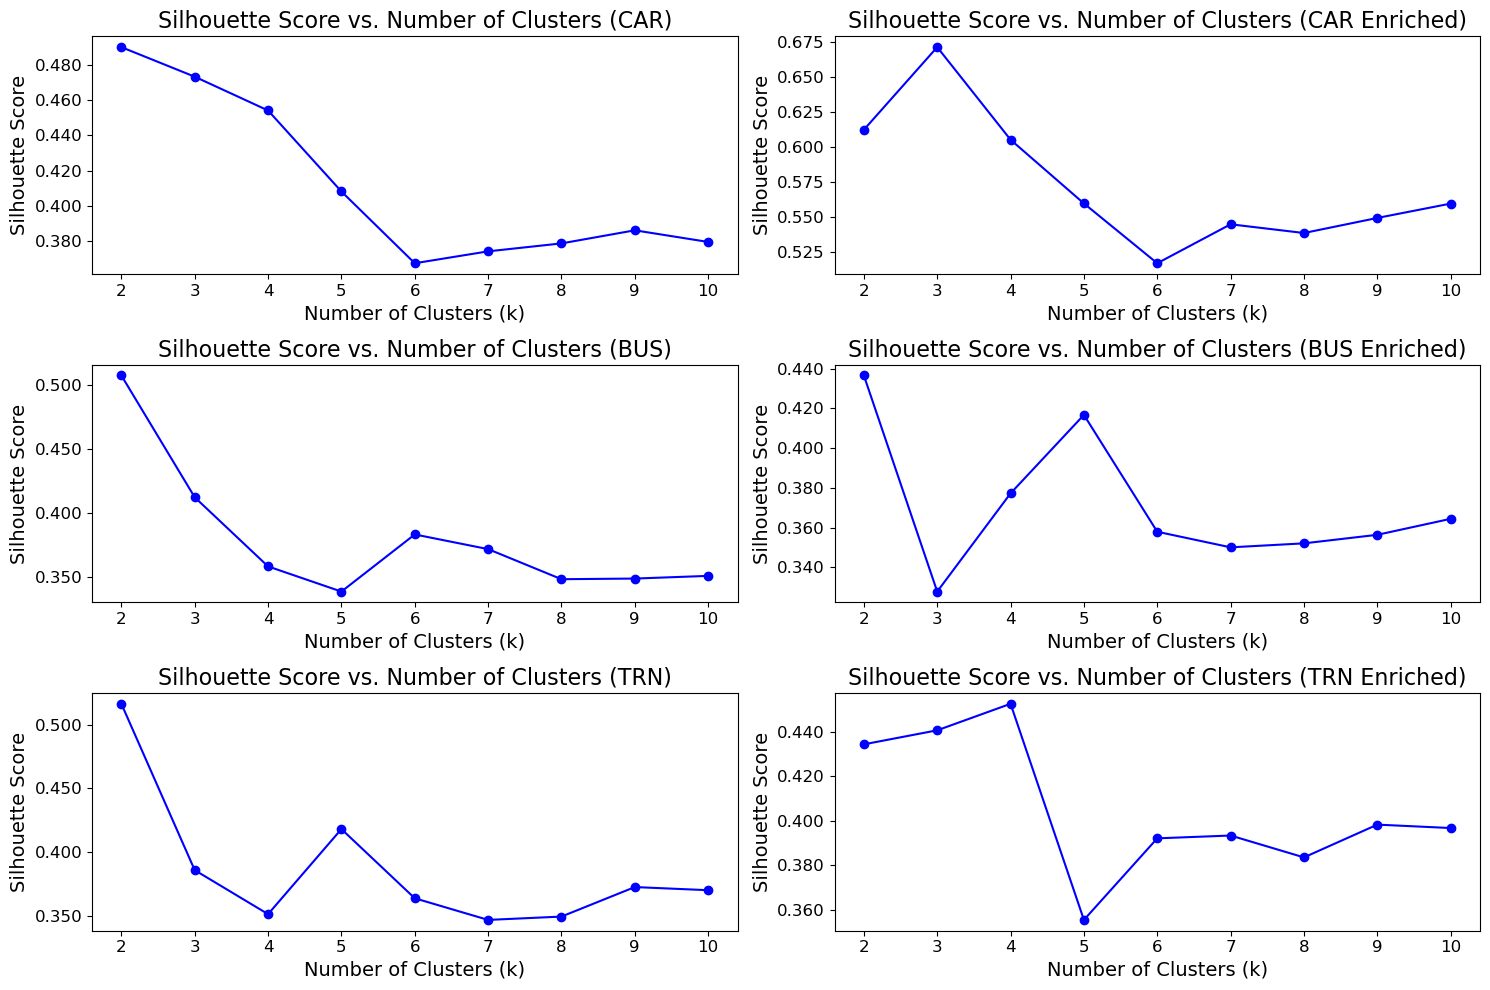

In [272]:
# Set the range of clusters we want to test
k_values = range(2, 11)

# Plotting the silhouette scores for each case
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Function to format y-axis ticks with three decimals
def format_yaxis_ticks(value, pos):
    return "{:.3f}".format(value)

# Plot 1
silhouettescore1 = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels = km.fit_predict(Xs)
    silhouettescore1.append(silhouette_score(Xs, km_labels, metric='euclidean'))

axes[0, 0].plot(k_values, silhouettescore1, marker='o', linestyle='-', color='b')
axes[0, 0].set_title('Silhouette Score vs. Number of Clusters (CAR)', fontsize=16)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=14)
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(format_yaxis_ticks))
axes[0, 0].tick_params(axis='both', labelsize=12)

# Plot 2
silhouettescore3 = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels3 = km.fit_predict(Xs3)
    silhouettescore3.append(silhouette_score(Xs3, km_labels3, metric='euclidean'))

axes[0, 1].plot(k_values, silhouettescore3, marker='o', linestyle='-', color='b')
axes[0, 1].set_title('Silhouette Score vs. Number of Clusters (CAR Enriched)', fontsize=16)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=14)
axes[0, 1].yaxis.set_major_formatter(FuncFormatter(format_yaxis_ticks))
axes[0, 1].tick_params(axis='both', labelsize=12)

# Plot 3
silhouettescore1 = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels1 = km.fit_predict(Xs1)
    silhouettescore1.append(silhouette_score(Xs1, km_labels1, metric='euclidean'))

axes[1, 0].plot(k_values, silhouettescore1, marker='o', linestyle='-', color='b')
axes[1, 0].set_title('Silhouette Score vs. Number of Clusters (BUS)', fontsize=16)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[1, 0].set_ylabel('Silhouette Score', fontsize=14)
axes[1, 0].yaxis.set_major_formatter(FuncFormatter(format_yaxis_ticks))
axes[1, 0].tick_params(axis='both', labelsize=12)

# Plot 4
silhouettescore4 = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels4 = km.fit_predict(Xs4)
    silhouettescore4.append(silhouette_score(Xs4, km_labels4, metric='euclidean'))

axes[1, 1].plot(k_values, silhouettescore4, marker='o', linestyle='-', color='b')
axes[1, 1].set_title('Silhouette Score vs. Number of Clusters (BUS Enriched)', fontsize=16)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[1, 1].set_ylabel('Silhouette Score', fontsize=14)
axes[1, 1].yaxis.set_major_formatter(FuncFormatter(format_yaxis_ticks))
axes[1, 1].tick_params(axis='both', labelsize=12)

# Plot 5
silhouettescore2 = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels2 = km.fit_predict(Xs2)
    silhouettescore2.append(silhouette_score(Xs2, km_labels2, metric='euclidean'))

axes[2, 0].plot(k_values, silhouettescore2, marker='o', linestyle='-', color='b')
axes[2, 0].set_title('Silhouette Score vs. Number of Clusters (TRN)', fontsize=16)
axes[2, 0].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[2, 0].set_ylabel('Silhouette Score', fontsize=14)
axes[2, 0].yaxis.set_major_formatter(FuncFormatter(format_yaxis_ticks))
axes[2, 0].tick_params(axis='both', labelsize=12)

# Plot 6
silhouettescore5 = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels5 = km.fit_predict(Xs5)
    silhouettescore5.append(silhouette_score(Xs5, km_labels5, metric='euclidean'))

axes[2, 1].plot(k_values, silhouettescore5, marker='o', linestyle='-', color='b')
axes[2, 1].set_title('Silhouette Score vs. Number of Clusters (TRN Enriched)', fontsize=16)
axes[2, 1].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[2, 1].set_ylabel('Silhouette Score', fontsize=14)
axes[2, 1].yaxis.set_major_formatter(FuncFormatter(format_yaxis_ticks))
axes[2, 1].tick_params(axis='both', labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

Now we can see more accurate values for K.

In [273]:
# Figure X....
# Data
output8 = {
    'Vehicle_Enriched': ['CAR', 'BUS', 'TRN'],
    'First, Second and Third Component (PCA)': [
        [0.97747751, 0.0174295,  0.00246979],
        [0.97557712, 0.01888167, 0.00272318],
        [0.76860845, 0.16637195, 0.02241525]
    ]
}

# Create DataFrame
unsup_ML_Results8 = pd.DataFrame(output8)
unsup_ML_Results8 

Vehicle_Enriched First, Second and Third Component (PCA)
0              CAR     [0.97747751, 0.0174295, 0.00246979]
1              BUS    [0.97557712, 0.01888167, 0.00272318]
2              TRN    [0.76860845, 0.16637195, 0.02241525]

In [274]:
# Figure X....
# Data
output9 = {
    'Vehicle': ['CAR', 'BUS', 'TRN'],
    'Silhouetter_Score': [0.671,0.667, 0.441]
}

# Create DataFrame
unsup_ML_Results9 = pd.DataFrame(output9)
unsup_ML_Results9 

Vehicle  Silhouetter_Score
0     CAR               0.67
1     BUS               0.67
2     TRN               0.44

In [275]:
# Figure X....
# Data
output10 = {
    'Vehicle': ['CAR', 'BUS', 'TRN'],
     'PCA': [
        [0.77171509, 0.16514322, 0.02878059],
        [0.52207334, 0.2149303, 0.09974296],
        [0.44371637, 0.33012741, 0.07419443]
    ],
    'PCA Enriched': [
        [0.97747751, 0.0174295,  0.00246979],
        [0.97557712, 0.01888167, 0.00272318],
        [0.76860845, 0.16637195, 0.02241525]
    ]
}

# Create DataFrame
unsup_ML_Results10 = pd.DataFrame(output10)
unsup_ML_Results10 

Vehicle                                   PCA  \
0     CAR  [0.77171509, 0.16514322, 0.02878059]   
1     BUS   [0.52207334, 0.2149303, 0.09974296]   
2     TRN  [0.44371637, 0.33012741, 0.07419443]   

                           PCA Enriched  
0   [0.97747751, 0.0174295, 0.00246979]  
1  [0.97557712, 0.01888167, 0.00272318]  
2  [0.76860845, 0.16637195, 0.02241525]

After enriching the data, the first principal component explains almost 97% of the variability for the CAR and BUS datasets, while the TRN dataset exhibits 76.86% variability on the first component. This demonstrates a clear improvement.

In [276]:
# Figure X....
# Data
output11 = {
    'Vehicle': ['CAR', 'BUS', 'TRN'],
    'Silhouetter_Score': [0.490, 0.412,0.386],
    'Silhouetter_Score_Enriched': [0.671,0.667, 0.441]
}

# Create DataFrame
unsup_ML_Results11 = pd.DataFrame(output11)
unsup_ML_Results11 

Vehicle  Silhouetter_Score  Silhouetter_Score_Enriched
0     CAR               0.49                        0.67
1     BUS               0.41                        0.67
2     TRN               0.39                        0.44

- **Closer to +1:** Well-defined clusters.
- **Around 0:** Overlapping clusters.
- **Closer to -1:** Samples may have been assigned to the wrong cluster.

Therefore, a higher silhouette score is generally indicative of a better-defined clustering.


# 4.4. Sentiment analysis.

Comparing Ryanair reviews with tweets from various USA airlines to determine which dataset classifies better in terms of positive, negative, and neutral sentiments.

In [277]:
# Source: https://www.tripadvisor.es/Airline_Review-d8729141-Reviews-Ryanair
# Licence: none, I've developed this dataset on my own. As I'm not collecting any personal data GDPR doesn't apply.
# Just creating a dataset for sentiment analysis based on Ryanair reviews.
mldf3 = pd.read_csv('Sentiment_Analysis_Ryanair_Reviews.csv')

In [278]:
# Source: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
# Licence: https://creativecommons.org/licenses/by-nc-sa/4.0/
mldf4 = pd.read_csv('Tweets.csv')

In [279]:
mldf3

Number   Rating                                             Review
0         1      Bad  Not on time. Not to destination or back home. ...
1         2      Bad  Checkin If you are trying to verify your booki...
2         3      Bad  Terrible delays. Stealing people's time. 2 hou...
3         4      Bad  The staff members were friendly and there was ...
4         5      Bad  I took a flight from Italy to Romania and they...
..      ...      ...                                                ...
595     596  Neutral  OK, whenever you pay less than 100€ for your t...
596     597  Neutral  I use this normal fairly regularly and it does...
597     598  Neutral  I use this normal fairly regularly and it does...
598     599  Neutral  ok service do not announce gate departures or ...
599     600  Neutral  The normal was okay. Enough leg room, just did...

[600 rows x 3 columns]

In [280]:
mldf3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Number  600 non-null    int64 
 1   Rating  600 non-null    object
 2   Review  600 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.2+ KB


In [281]:
mldf4

tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                          1.00   
1      570301130888122368          positive                          0.35   
2      570301083672813571           neutral                          0.68   
3      570301031407624196          negative                          1.00   
4      570300817074462722          negative                          1.00   
...                   ...               ...                           ...   
14635  569587686496825344          positive                          0.35   
14636  569587371693355008          negative                          1.00   
14637  569587242672398336           neutral                          1.00   
14638  569587188687634433          negative                          1.00   
14639  569587140490866689           neutral                          0.68   

               negativereason  negativereason_confidence         airline  \
0                         NaN                        NaN  Virgin America   
1                         NaN                       0.00  Virgin America   
2                         NaN                        NaN  Virgin America   
3                  Bad Flight                       0.70  Virgin America   
4                  Can't Tell                       1.00  Virgin America   
...                       ...                        ...             ...   
14635                     NaN                       0.00        American   
14636  Customer Service Issue                       1.00        American   
14637                     NaN                        NaN        American   
14638  Customer Service Issue                       0.67        American   
14639                     NaN                       0.00        American   

      airline_sentiment_gold             name negativereason_gold  \
0                        NaN          cairdin                 NaN   
1                        NaN         jnardino                 NaN   
2                        NaN       yvonnalynn                 NaN   
3                        NaN         jnardino                 NaN   
4                        NaN         jnardino                 NaN   
...                      ...              ...                 ...   
14635                    NaN  KristenReenders                 NaN   
14636                    NaN         itsropes                 NaN   
14637                    NaN         sanyabun                 NaN   
14638                    NaN       SraJackson                 NaN   
14639                    NaN        daviddtwu                 NaN   

       retweet_count                                               text  \
0                  0                @VirginAmerica What @dhepburn said.   
1                  0  @VirginAmerica plus you've added commercials t...   
2                  0  @VirginAmerica I didn't today... Must mean I n...   
3                  0  @VirginAmerica it's really aggressive to blast...   
4                  0  @VirginAmerica and it's a really big bad thing...   
...              ...                                                ...   
14635              0  @AmericanAir thank you we got on a different f...   
14636              0  @AmericanAir leaving over 20 minutes Late Flig...   
14637              0  @AmericanAir Please bring American Airlines to...   
14638              0  @AmericanAir you have my money, you change my ...   
14639              0  @AmericanAir we have 8 ppl so we need 2 know h...   

      tweet_coord              tweet_created tweet_location  \
0             NaN  2015-02-24 11:35:52 -0800            NaN   
1             NaN  2015-02-24 11:15:59 -0800            NaN   
2             NaN  2015-02-24 11:15:48 -0800      Lets Play   
3             NaN  2015-02-24 11:15:36 -0800            NaN   
4             NaN  2015-02-24 11:14:45 -0800            NaN   
...           ...                        ...            ...   
14635   

In [282]:
mldf4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Cleaning a bit *Tweets.csv* dataset:

In [283]:
# Dropping several columns as they are irrelevant for the analysis:
sdf_col_drop = ['airline_sentiment_confidence','negativereason','negativereason_confidence','airline','airline_sentiment_gold',
               'name','negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone']
mldf4.drop(sdf_col_drop ,axis=1, inplace=True) 
mldf4.head()

tweet_id airline_sentiment  \
0  570306133677760513           neutral   
1  570301130888122368          positive   
2  570301083672813571           neutral   
3  570301031407624196          negative   
4  570300817074462722          negative   

                                                text  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...  
2  @VirginAmerica I didn't today... Must mean I n...  
3  @VirginAmerica it's really aggressive to blast...  
4  @VirginAmerica and it's a really big bad thing...

In [284]:
mldf4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet_id           14640 non-null  int64 
 1   airline_sentiment  14640 non-null  object
 2   text               14640 non-null  object
dtypes: int64(1), object(2)
memory usage: 343.3+ KB


Encoding Ryanair rating:

In [285]:
label_encoder = LabelEncoder()
mldf3['Rating'] = label_encoder.fit_transform(mldf3['Rating'])
mldf3.groupby('Rating').describe()

Number                                                
        count   mean   std    min    25%    50%    75%    max
Rating                                                       
0      200.00 100.50 57.88   1.00  50.75 100.50 150.25 200.00
1      200.00 300.50 57.88 201.00 250.75 300.50 350.25 400.00
2      200.00 500.50 57.88 401.00 450.75 500.50 550.25 600.00

Encoding *Tweets.csv* airline_sentiment:

In [286]:
label_encoder = LabelEncoder()
mldf4['airline_sentiment'] = label_encoder.fit_transform(mldf4['airline_sentiment'])
mldf4.groupby('airline_sentiment').describe()

tweet_id                                           \
                     count                  mean                std   
airline_sentiment                                                     
0                  9178.00 569260233957160320.00 757247434435229.75   
1                  3099.00 569184128116730176.00 806840548645713.62   
2                  2363.00 569100562667636032.00 811247569553973.88   

                                                               \
                                    min                   25%   
airline_sentiment                                               
0                 567590027375702016.00 568651131501547520.00   
1                 567588278875213824.00 568485192930881536.00   
2                 567655489119326208.00 568433082700840960.00   

                                                               \
                                    50%                   75%   
airline_sentiment                                               
0                 569535505821460480.00 569879787570912256.00   
1                 569307978798645248.00 569930464634531840.00   
2                 569197967959154688.00 569878823237519360.00   

                                         
                                    max  
airline_sentiment                        
0                 570310600460525568.00  
1                 570309340952993792.00  
2                 570309345281486848.00

Vectorising Ryanair reviews:

In [287]:
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
x = vectorizer.fit_transform(mldf3['Review'])
y = mldf3['Rating']

In [288]:
print(x)

  (0, 16720)	1
  (0, 4703)	1
  (0, 7923)	1
  (0, 12233)	1
  (0, 6900)	1
  (0, 11304)	1
  (0, 7136)	1
  (0, 7894)	1
  (0, 2237)	1
  (0, 8696)	1
  (0, 17829)	1
  (0, 9322)	1
  (0, 2389)	1
  (0, 10544)	1
  (0, 17863)	1
  (0, 6860)	1
  (0, 16754)	1
  (0, 4709)	1
  (0, 7932)	1
  (0, 12234)	1
  (0, 6901)	1
  (0, 11306)	1
  (0, 7144)	1
  (0, 7896)	1
  (0, 2238)	1
  :	:
  (598, 11033)	1
  (598, 16831)	1
  (598, 15169)	1
  (598, 4478)	1
  (598, 13493)	1
  (598, 16756)	1
  (599, 8696)	1
  (599, 9126)	1
  (599, 14747)	1
  (599, 9255)	1
  (599, 12372)	1
  (599, 1474)	1
  (599, 13584)	1
  (599, 9129)	1
  (599, 10729)	1
  (599, 11058)	1
  (599, 14827)	1
  (599, 4806)	1
  (599, 10786)	1
  (599, 11068)	1
  (599, 13598)	1
  (599, 8712)	1
  (599, 4807)	1
  (599, 9289)	1
  (599, 12377)	1


In [289]:
print(y)

0      0
1      0
2      0
3      0
4      0
      ..
595    2
596    2
597    2
598    2
599    2
Name: Rating, Length: 600, dtype: int32


Vectorising Ryanair reviews:

In [290]:
# Removing stop words through the vectorization process.
vectvectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
x = vectorizer.fit_transform(mldf3['Review'])
y = mldf3['Rating']

In [291]:
print(x)

  (0, 16720)	1
  (0, 4703)	1
  (0, 7923)	1
  (0, 12233)	1
  (0, 6900)	1
  (0, 11304)	1
  (0, 7136)	1
  (0, 7894)	1
  (0, 2237)	1
  (0, 8696)	1
  (0, 17829)	1
  (0, 9322)	1
  (0, 2389)	1
  (0, 10544)	1
  (0, 17863)	1
  (0, 6860)	1
  (0, 16754)	1
  (0, 4709)	1
  (0, 7932)	1
  (0, 12234)	1
  (0, 6901)	1
  (0, 11306)	1
  (0, 7144)	1
  (0, 7896)	1
  (0, 2238)	1
  :	:
  (598, 11033)	1
  (598, 16831)	1
  (598, 15169)	1
  (598, 4478)	1
  (598, 13493)	1
  (598, 16756)	1
  (599, 8696)	1
  (599, 9126)	1
  (599, 14747)	1
  (599, 9255)	1
  (599, 12372)	1
  (599, 1474)	1
  (599, 13584)	1
  (599, 9129)	1
  (599, 10729)	1
  (599, 11058)	1
  (599, 14827)	1
  (599, 4806)	1
  (599, 10786)	1
  (599, 11068)	1
  (599, 13598)	1
  (599, 8712)	1
  (599, 4807)	1
  (599, 9289)	1
  (599, 12377)	1


In [292]:
print(y)

0      0
1      0
2      0
3      0
4      0
      ..
595    2
596    2
597    2
598    2
599    2
Name: Rating, Length: 600, dtype: int32


Vectorising Airlines *Tweets.csv* :

In [293]:
vectorizer1 = CountVectorizer(ngram_range=(1,2), stop_words='english')
x1 = vectorizer1.fit_transform(mldf4['text'])
y1 = mldf4['airline_sentiment']

In [294]:
print(x1)

  (0, 94806)	1
  (0, 26789)	1
  (0, 74375)	1
  (0, 94876)	1
  (0, 26790)	1
  (1, 94806)	1
  (1, 67415)	1
  (1, 94331)	1
  (1, 6237)	1
  (1, 20861)	1
  (1, 31364)	1
  (1, 83247)	1
  (1, 95004)	1
  (1, 67458)	1
  (1, 94339)	1
  (1, 6242)	1
  (1, 20864)	1
  (1, 31463)	1
  (2, 94806)	1
  (2, 27062)	1
  (2, 86661)	1
  (2, 57507)	1
  (2, 60547)	1
  (2, 88409)	1
  (2, 94878)	1
  :	:
  (14638, 10359)	1
  (14638, 28494)	1
  (14638, 9086)	1
  (14638, 59586)	1
  (14638, 66146)	1
  (14638, 82272)	1
  (14638, 56627)	1
  (14639, 60547)	1
  (14639, 33556)	2
  (14639, 75693)	1
  (14639, 51700)	1
  (14639, 67460)	1
  (14639, 65231)	1
  (14639, 65293)	1
  (14639, 80916)	1
  (14639, 8413)	1
  (14639, 68071)	1
  (14639, 51882)	1
  (14639, 60692)	1
  (14639, 75762)	1
  (14639, 34731)	1
  (14639, 9186)	1
  (14639, 68088)	1
  (14639, 67473)	1
  (14639, 80941)	1


In [295]:
print(y1)

0        1
1        2
2        1
3        0
4        0
        ..
14635    2
14636    0
14637    1
14638    0
14639    1
Name: airline_sentiment, Length: 14640, dtype: int32


Splitting Ryanair dataset so that 70% can be used for training and 30% for testing.

In [296]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)
x.shape, y.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((600, 18550), (600,), (420, 18550), (180, 18550), (420,), (180,))

Splitting Airlines *Tweets.csv* dataset so that 70% can be used for training and 30% for testing

In [297]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.30, random_state = 0)
x1.shape, y1.shape, x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape

((14640, 100073), (14640,), (10248, 100073), (4392, 100073), (10248,), (4392,))

## Train a Naive Bayes Classifier

The next step is to train a Naive Bayes classifier. We'll use scikit-learn's [MultinomialDB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier, which is ideal for datasets vectorized by `CountVectorizer`.

In [298]:
# Ryanair:
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [299]:
# uSA Airlines :
model1 = MultinomialNB()
model1.fit(x1_train, y1_train)

MultinomialNB()

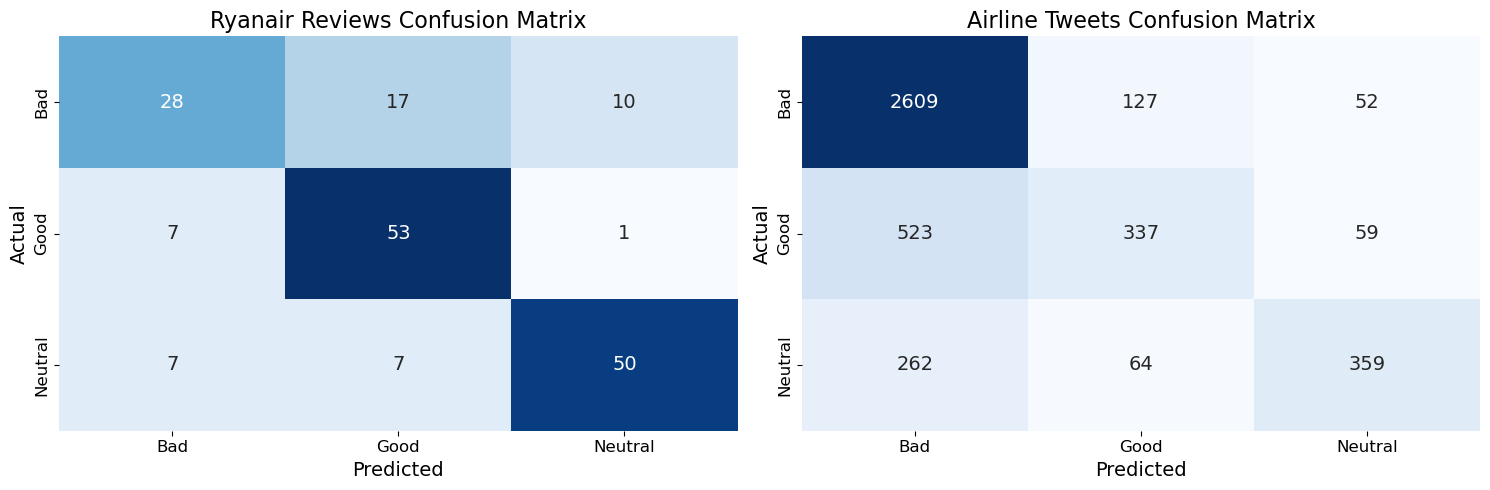

In [300]:
# Function to plot confusion matrix as a heatmap
def plot_cm(ax, model, x_test, y_test, labels, title):
    y_pred = model.predict(x_test)
    
    conMtx = confusion_matrix(y_test, y_pred, labels=labels)
    
    sns.heatmap(conMtx, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False, annot_kws={"size": 14})
    ax.set_xlabel('Predicted', fontsize=14)
    ax.set_ylabel('Actual', fontsize=14)
    ax.set_title(title, fontsize=16)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ryanair Reviews Confusion Matrix
plot_cm(axes[0], model, x_test, y_test, labels=[0, 1, 2], title='Ryanair Reviews Confusion Matrix')

# American and United Reviews Confusion Matrix
plot_cm(axes[1], model1, x1_test, y1_test, labels=[0, 1, 2], title='Airline Tweets Confusion Matrix')

# Adjusting x-axis and y-axis labels to display the specified labels
axes[0].set_xticklabels(['Bad', 'Good', 'Neutral'], fontsize=12)
axes[0].set_yticklabels(['Bad', 'Good', 'Neutral'], fontsize=12)
axes[1].set_xticklabels(['Bad', 'Good', 'Neutral'], fontsize=12)
axes[1].set_yticklabels(['Bad', 'Good', 'Neutral'], fontsize=12)

plt.tight_layout()
plt.show()


Ryanair model is correctly classifiying:<br>
**Bad:** 28 Reviews<br>
**Good:** 53 Reviews<br>
**Neutral:** 50 Reviews<br>

Airline Tweets model is correctly classifiying:<br>
**Bad:** 2609 Reviews<br>
**Good:** 337 Reviews<br>
**Neutral:** 359 Reviews<br>
Let's use the `score` method to get a rough measure of the model's accuracy.

In [301]:
a= model.score(x_test, y_test)
b = model1.score(x1_test, y1_test)
print(f'Model Accuracy Score for Ryanair: {a:.2f}')
print(f'Model Accuracy Score for Airline Tweets: {b:.2f}')

Model Accuracy Score for Ryanair: 0.73
Model Accuracy Score for Airline Tweets: 0.75


Use Scikit’s [RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) class to visualize the ROC curve.

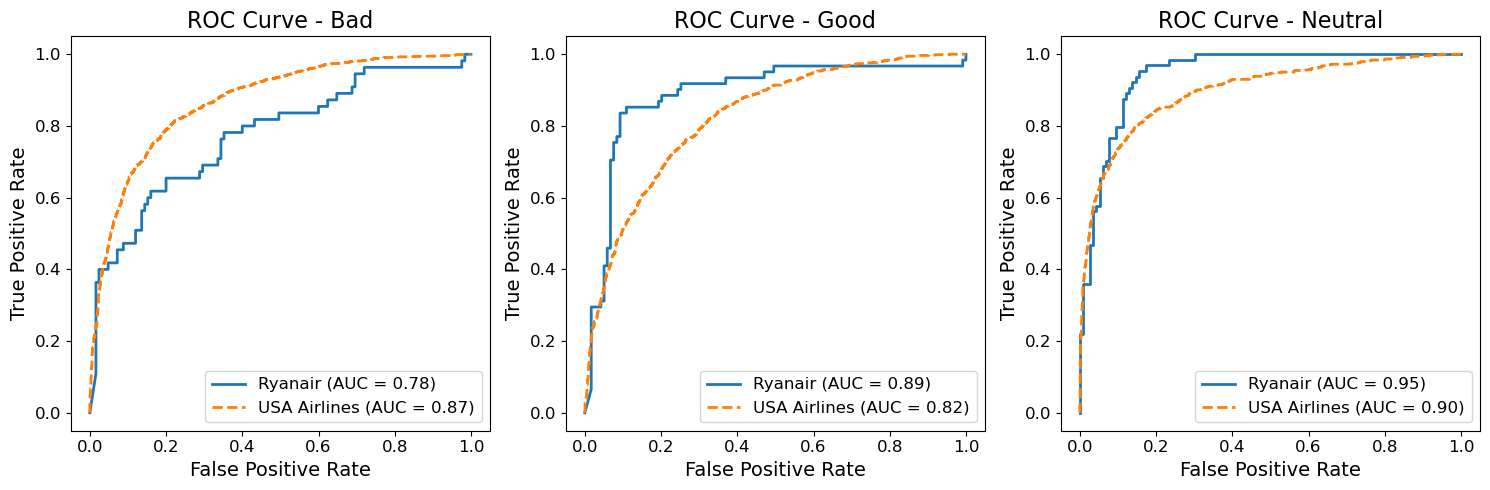

In [302]:
# ROC Curve: Receiver Operating Characteristic
# AUC: Area Under the Curve
# Assuming `model` is a trained classifier for Ryanair
# `X_test` is the test set features, and `y_test` is the true labels

# Get predicted probabilities for each class
y_score_ryanair = model.predict_proba(x_test)

# Assuming `model1` is a trained classifier Airline Tweets
# `X1_test` is the test set features, and `y1_test` is the true labels

# Get predicted probabilities for each class
y_score_Airlines_Tweets_csv = model1.predict_proba(x1_test)

# Setting num_classes 3 in this case
num_classes = 3

# Define class labels
class_labels = ['Bad', 'Good', 'Neutral']

# Plot ROC curves for each class
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(15, 5))

# Plot ROC curve for Ryanair
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_score_ryanair[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, label=f'Ryanair (AUC = {roc_auc:.2f})', linewidth=2)
    axes[i].set_xlabel('False Positive Rate', fontsize=14)
    axes[i].set_ylabel('True Positive Rate', fontsize=14)
    axes[i].set_title(f'ROC Curve - {class_labels[i]}', fontsize=16)
    axes[i].legend(fontsize=12)

# Plot ROC curve for USA airlines:
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y1_test == i, y_score_Airlines_Tweets_csv[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, label=f'USA Airlines (AUC = {roc_auc:.2f})', linestyle='--', linewidth=2)
    axes[i].legend(fontsize=12)

# Increase font size for x and y-axis tick labels
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


Both models are quite close in terms of accuracy and ROC. However, we want to test how each model classifies a simulated review when inputted.

## Classifying a Simulated Negative Review:
Desired output = 0

Ryanair:

In [303]:
msg = 'Bad and terrible experience, will not fly again with Ryanair'
input = vectorizer.transform([msg])
model.predict(input)[0]

0

In [304]:
msg = 'Dirty plane, poor experience overall'
input = vectorizer.transform([msg])
model.predict(input)[0]

0

In [305]:
msg = 'Worst company to fly with ever'
input = vectorizer.transform([msg])
model.predict(input)[0]

0

USA Airlines:

In [306]:
msg = 'Bad and terrible experience, will not fly again with American Airlines'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

0

In [307]:
msg = 'Dirty plane, poor experience overall'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

0

In [308]:
msg = 'Worst company to fly with ever'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

0

## Classifying a Simulated Positive Review:
Desired output = 1

Ryanair:

In [309]:
msg = 'Amazing experience flying with Ryanair, I will recommend this company!!'
input = vectorizer.transform([msg])
model.predict(input)[0]

1

In [310]:
msg = 'Friendly staff, clean airplane and great snacks on board'
input = vectorizer.transform([msg])
model.predict(input)[0]

1

In [311]:
msg = 'Great company to fly with, I highly recommend it, good value for money'
input = vectorizer.transform([msg])
model.predict(input)[0]

1

USA Airlines:

In [312]:
msg = 'Amazing experience flying with United, I will recommend this company!!'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

0

In [313]:
msg = 'Friendly staff, clean airplane and great snacks on board'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

2

In [314]:
msg = 'Great company to fly with, I highly recommend it, good value for money'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

0

## Classifying a Simulated Neutral Review:
Desired output = 2

Ryanair:

In [315]:
msg = 'Normal company, it gets you from point A to point B'
input = vectorizer.transform([msg])
model.predict(input)[0]

2

In [316]:
msg = 'Just another company to fly with, neutral experience'
input = vectorizer.transform([msg])
model.predict(input)[0]

2

In [317]:
msg = 'Always on time, clean plane and not bad coffe'
input = vectorizer.transform([msg])
model.predict(input)[0]

1

USA Airlines:

In [318]:
msg = 'Normal company, it gets you from point A to point B'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

0

In [319]:
msg = 'Just another company to fly with, neutral experience'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

0

In [320]:
msg = 'Always on time, clean plane and not bad coffe'
input = vectorizer1.transform([msg])
model1.predict(input)[0]

0

In [321]:
# Creating a df to plot the Sentiment Analysis prediction:
review = {
    'Airline': ['Ryanair', 'Airline_Tweets', 'Ryanair', 'Airline_Tweets', 'Ryanair', 'Airline_Tweets'],
    'Sentiment': ['Bad', 'Bad', 'Good', 'Good', 'Neutral', 'Neutral'],
    'Score': [3, 3, 3, 0, 2, 0]
}

review = pd.DataFrame(review)

review = pd.crosstab(review['Sentiment'], review['Airline'], values=review['Score'], aggfunc='sum', margins=False)
review

Airline    Airline_Tweets  Ryanair
Sentiment                         
Bad                     3        3
Good                    0        3
Neutral                 0        2

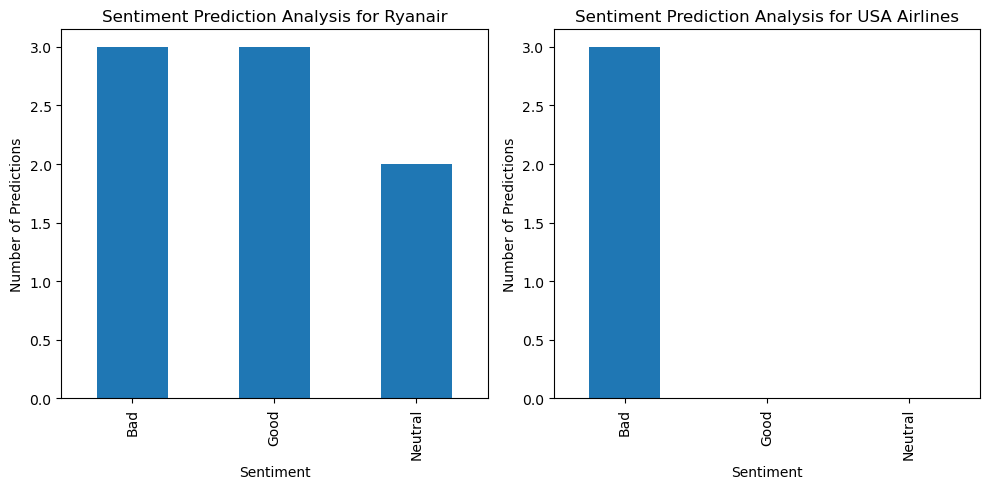

In [322]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot for Ryanair
review['Ryanair'].plot(kind='bar', ax=axes[0], title='Sentiment Prediction Analysis for Ryanair')
axes[0].set_ylabel('Number of Predictions')
# Plot for Airline Tweets
review['Airline_Tweets'].plot(kind='bar', ax=axes[1], title='Sentiment Prediction Analysis for USA Airlines')
axes[1].set_ylabel('Number of Predictions')
plt.tight_layout()
plt.show()